In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import Counter
import scanpy as sc
import anndata as an
import os
import ast
import seaborn as sns
from tqdm import tqdm  
import subprocess
import sys
import scycle

sys.path.append('/home/zinovyev/google-cloud-sdk/bin/')
folder = './data/cellline_drug_analysis/'


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
result = subprocess.run(['/home/zinovyev/google-cloud-sdk/bin/gsutil','ls','gs://tahoe100m_bycelllines/cellline_drug_analysis/'], capture_output=True, text=True)
out = result.stdout[:-1]

In [5]:
k = len('gs://tahoe100m_bycelllines/cellline_drug_analysis/')
l = [f[k:].split('_')[0]+'_'+f[k:].split('_')[1] for f in out.split('\n') if len(f[k:].split('_'))>1]
l = list(set(l))
cell_lines = l

In [2]:
cell_lines = ['CVCL_1098','CVCL_1381','CVCL_0480']

In [6]:
print(cell_lines)

['CVCL_0546', 'CVCL_1715', 'CVCL_0099', 'CVCL_1098', 'CVCL_1666', 'CVCL_1239', 'CVCL_1716', 'CVCL_1717', 'CVCL_0480', 'CVCL_1381', 'CVCL_0459']


In [23]:
# download data
for c in cell_lines:
    os.system(f'/home/zinovyev/google-cloud-sdk/bin/gsutil -m cp gs://tahoe100m_bycelllines/cellline_drug_analysis/{c}*.* ./data/cellline_drug_analysis/')

Copying gs://tahoe100m_bycelllines/cellline_drug_analysis/CVCL_1715_(R)-Verapamil (hydrochloride)_ICA.h5ad...
Copying gs://tahoe100m_bycelllines/cellline_drug_analysis/CVCL_1715_(S)-Crizotinib_ICA.h5ad...
Copying gs://tahoe100m_bycelllines/cellline_drug_analysis/CVCL_1715_4EGI-1_ICA.h5ad...
Copying gs://tahoe100m_bycelllines/cellline_drug_analysis/CVCL_1715_18β-Glycyrrhetinic acid_ICA.h5ad...
Copying gs://tahoe100m_bycelllines/cellline_drug_analysis/CVCL_1715_5-Azacytidine_ICA.h5ad...
Copying gs://tahoe100m_bycelllines/cellline_drug_analysis/CVCL_1715_5-Fluorouracil_ICA.h5ad...
/ [6/6 files][   30.0 B/   30.0 B] 100% Done                                    
Operation completed over 6 objects/30.0 B.                                       
Copying gs://tahoe100m_bycelllines/cellline_drug_analysis/CVCL_0459_(R)-Verapamil (hydrochloride)_ICA.h5ad...
Copying gs://tahoe100m_bycelllines/cellline_drug_analysis/CVCL_0459_(R)-Verapamil (hydrochloride)_distances.txt...
Copying gs://tahoe100m_byce

In [9]:
cell_line = cell_lines[0]

In [7]:
# Extract all distances
files = os.listdir(folder)
cellline_names = []
drugnames = []
drugconcs = []
distance_types = []
distances = []
for f in tqdm(files):
    if f.endswith('txt'):
        cl = f.split('_')[0]+'_'+f.split('_')[1]
        dr = f.split('_')[2]
        with open(folder+f) as p:
            l = p.readlines()
            dc = ast.literal_eval(l[0])
            #print(dc)
            for k in dc:
                for dose in dc[k]:
                    cellline_names.append(cl)
                    drugnames.append(dr)
                    drugconcs.append(dose)
                    distance_types.append(k)
                    #print(k)
                    if k=='mmd':
                        distances.append(np.log10(dc[k][dose]/10+1))    
                    elif k=='edistance':
                        distances.append(np.log10(dc[k][dose]*2+1))    
                    elif k=='wassertein':
                        distances.append(np.log10(dc[k][dose]/20+1))    
                    else:
                        print('ERROR: UNKNOWN TYPE "'+k+'"')
                    #distances.append(np.log10(dc[k][dose]+1))
                    #distances.append(dc[k][dose])
df = pd.DataFrame(data={'CELL_LINE':cellline_names,'DRUG':drugnames,'DOSE':drugconcs,'METRICS':distance_types,'DISTANCE':distances})
display(df)

  0%|          | 0/3966 [00:00<?, ?it/s]

100%|██████████| 3966/3966 [00:07<00:00, 545.88it/s]


CELL_LINE                           DRUG  DOSE     METRICS  DISTANCE
0      CVCL_0099  (R)-Verapamil (hydrochloride)  0.00   edistance  0.000000
1      CVCL_0099  (R)-Verapamil (hydrochloride)  0.05   edistance  0.332593
2      CVCL_0099  (R)-Verapamil (hydrochloride)  5.00   edistance  0.431707
3      CVCL_0099  (R)-Verapamil (hydrochloride)  0.00  wassertein  0.000000
4      CVCL_0099  (R)-Verapamil (hydrochloride)  0.05  wassertein  1.229599
...          ...                            ...   ...         ...       ...
14890  CVCL_1717                      Amsacrine  5.00  wassertein  1.073514
14891  CVCL_1717                      Amsacrine  0.00         mmd  0.000000
14892  CVCL_1717                      Amsacrine  0.05         mmd  0.208841
14893  CVCL_1717                      Amsacrine  0.50         mmd  0.280284
14894  CVCL_1717                      Amsacrine  5.00         mmd  0.485561

[14895 rows x 5 columns]

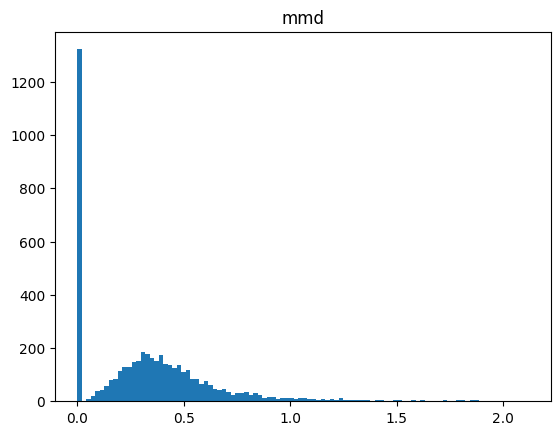

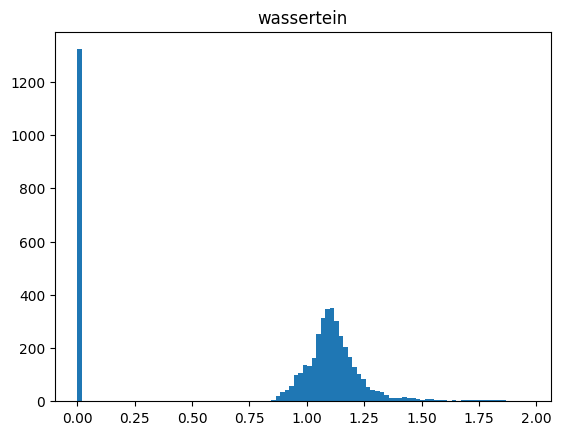

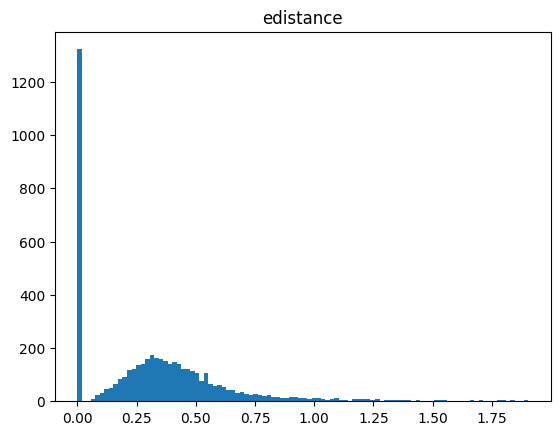

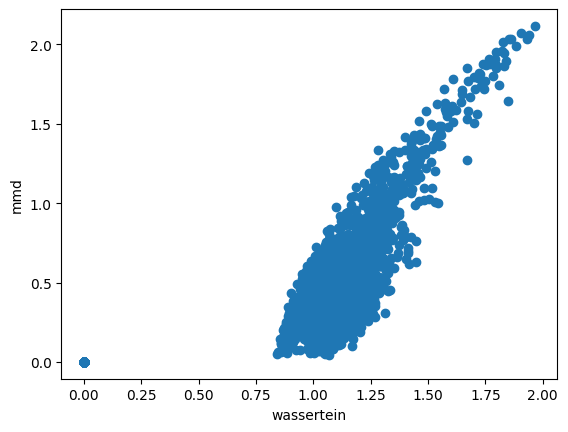

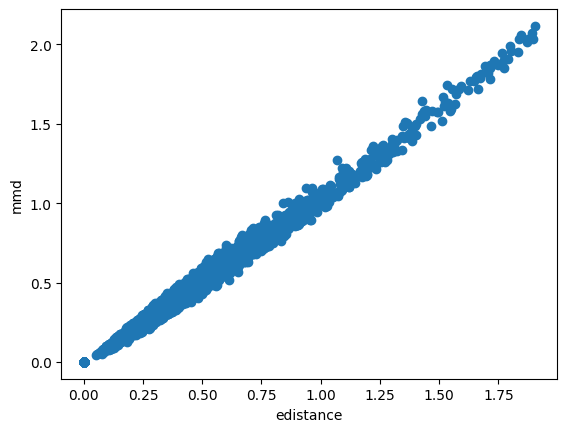

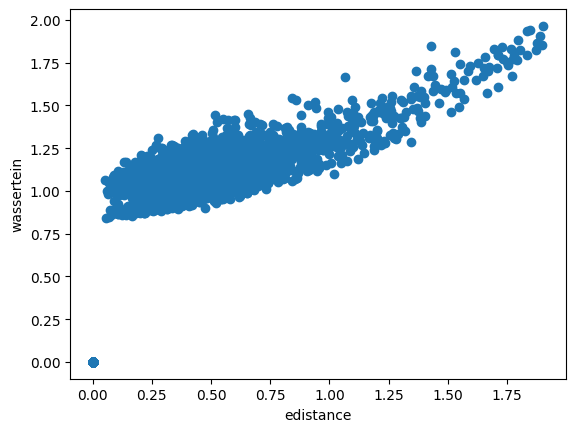

In [8]:
metrics = ['mmd','wassertein','edistance']
for m in metrics:
    plt.hist(df[df['METRICS']==m]['DISTANCE'],bins=100)
    plt.title(m)
    plt.show()
for i,m1 in enumerate(metrics):
    for j,m2 in enumerate(metrics):
        if i>j:
            plt.scatter(df[df['METRICS']==m1]['DISTANCE'],df[df['METRICS']==m2]['DISTANCE'])
            plt.xlabel(m1)
            plt.ylabel(m2)
            plt.show()

CELL_LINE          DRUG  DOSE METRICS  DISTANCE
79     CVCL_0480      9-ING-41  0.50     mmd  1.227803
158    CVCL_0480   Abemaciclib  5.00     mmd  1.214156
350    CVCL_0480     Auranofin  5.00     mmd  1.407836
398    CVCL_0480    Belinostat  5.00     mmd  1.717906
419    CVCL_0480    Belzutifan  5.00     mmd  1.079021
...          ...           ...   ...     ...       ...
14172  CVCL_1666  Panobinostat  0.05     mmd  1.497403
14173  CVCL_1666  Panobinostat  0.50     mmd  1.770769
14174  CVCL_1666  Panobinostat  5.00     mmd  1.814305
14671  CVCL_1717      9-ING-41  0.50     mmd  1.160763
14750  CVCL_1717   Abemaciclib  5.00     mmd  1.236878

[205 rows x 5 columns]

<Axes: xlabel='DOSE', ylabel='DISTANCE'>

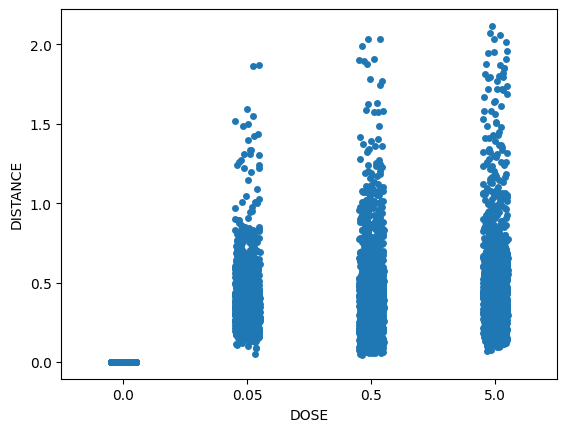

In [9]:
df1 = df[df['METRICS']=='edistance']
df1 = df[df['METRICS']=='mmd']
#df1 = df[df['METRICS']=='wassertein']
display(df1[df1['DISTANCE']>1])
sns.stripplot(df1,x='DOSE',y='DISTANCE')

/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


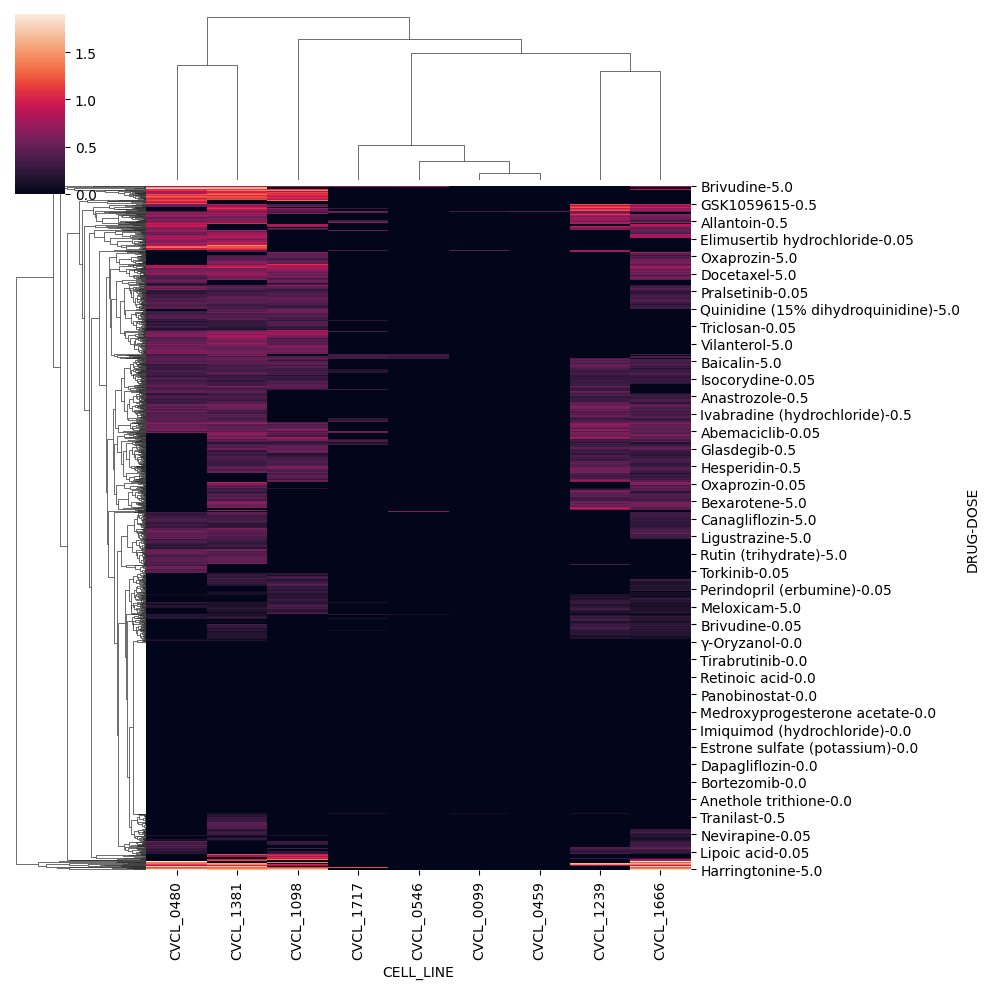

In [10]:
m = 'edistance'
df1 = df[df['METRICS']==m]
pivoted_df = df1.pivot_table(
    index=['DRUG', 'DOSE'],
    columns='CELL_LINE',
    values='DISTANCE',
    fill_value=0
)
sns.clustermap(pivoted_df)
pivoted_df.to_csv('data/cell_drug_response_'+m+'.tsv',sep='\t')

In [28]:
# Extract all signatures
import pickle
folder = './data/cellline_drug_analysis/'
files = os.listdir(folder)
cellline_names = []
drugnames = []
drugconcs = []
distance_types = []
distances = []
for f in tqdm(files):
    if f.endswith('pkl'):
        cl = f.split('_')[0]+'_'+f.split('_')[1]
        dr = f.split('_')[2]
        with open(folder+f,'rb') as p:
            dc = pickle.load(p)
            print(dc)
            break
            #print(dc)


  0%|          | 2/3966 [00:00<02:01, 32.70it/s]

{'plate4': {'params': {'groupby': 'drugname_drugconc', 'reference': "[('DMSO_TF', 0.0, 'uM')]", 'method': 'wilcoxon', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}, 'names': rec.array([('C1QTNF7-AS1',), ('EPIC1',), ('PRELID2',), ..., ('WDR43',),
           ('TALAM1',), ('EPS8',)],
          dtype=[("[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]", 'O')]), 'scores': rec.array([( 8.202456 ,), ( 7.1347466,), ( 6.9678226,), ...,
           (-5.4899426,), (-5.4916353,), (-5.53263  ,)],
          dtype=[("[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]", '<f4')]), 'pvals': rec.array([(2.35524648e-16,), (9.69656556e-13,), (3.21883661e-12,), ...,
           (4.02064860e-08,), (3.98229337e-08,), (3.15464171e-08,)],
          dtype=[("[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]", '<f8')]), 'pvals_adj': rec.array([(2.35524648e-12,), (4.84828278e-09,), (1.07294554e-08,), ...,
           (1.74810809e-05,), (1.74810809e-05,), (1.50221034e-05,)],
          dtype=[("[('(R)

dict_keys(['plate4', 'plate6'])
dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])
{'params': {'groupby': 'drugname_drugconc', 'reference': "[('DMSO_TF', 0.0, 'uM')]", 'method': 'wilcoxon', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}, 'names': rec.array([('C1QTNF7-AS1',), ('EPIC1',), ('PRELID2',), ..., ('WDR43',),
           ('TALAM1',), ('EPS8',)],
          dtype=[("[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]", 'O')]), 'scores': rec.array([( 8.202456 ,), ( 7.1347466,), ( 6.9678226,), ...,
           (-5.4899426,), (-5.4916353,), (-5.53263  ,)],
          dtype=[("[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]", '<f4')]), 'pvals': rec.array([(2.35524648e-16,), (9.69656556e-13,), (3.21883661e-12,), ...,
           (4.02064860e-08,), (3.98229337e-08,), (3.15464171e-08,)],
          dtype=[("[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]", '<f8')]), 'pvals_adj': rec.array([(2.35524648e-12,), (4.84828278e-09,), (1.07294554e-08,

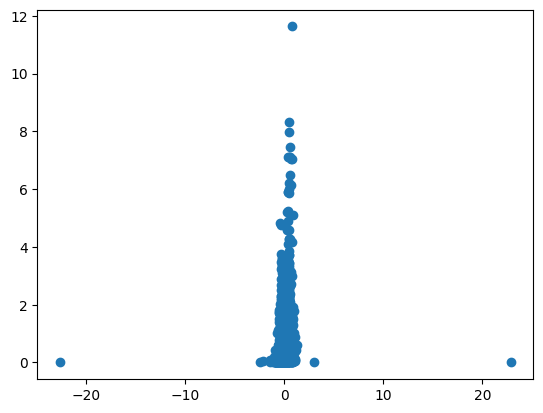

In [29]:
print(dc.keys())
print(dc['plate4'].keys())
print(dc['plate4'])
names = [r[0] for r in list(dc['plate4']['names'])]
scores = [r[0] for r in list(dc['plate4']['scores'])]
logfoldchanges = [r[0] for r in list(dc['plate4']['logfoldchanges'])]
pvals_adj = [r[0] for r in list(dc['plate4']['pvals_adj'])]
plt.scatter(logfoldchanges,np.clip(-np.log10(pvals_adj),a_min=0,a_max=30))
plt.show()
#plt.scatter(scores,np.clip(-np.log10(pvals_adj),a_min=0,a_max=30))
#plt.show()
#plt.scatter(scores,logfoldchanges)
#plt.show()

In [49]:
cc_indices

{'G1-S': 0, 'G2-M': 1, 'G2-M-': 16, 'Histone': 23}

In [13]:
# Extract all ICA components
class DimRedObject:
    def __init__(self, S_):
        self.S_ = S_

files = os.listdir(folder)
cellline_names = []
drugnames = []
drugconcs = []
distance_types = []
distances = []
data = {}
gene_names = set()
comp_names = []
cell_lines = []
drugs = []
cell_cycle_comps = []
not_found_cc_components = []
k = 0
for f in tqdm(files):
    if f.endswith('h5ad'):
        cl = f.split('_')[0]+'_'+f.split('_')[1]
        dr = f.split('_')[2]
        ica = sc.read_h5ad(folder+f)
        metagenes = ica.uns['Metagenes']
        gn = ica.uns['gene_names']
        current_genes = set()

        S = ica.uns['Metagenes']
        A = ica.X
        icat = an.AnnData(X=np.zeros([ica.n_obs,S.shape[0]]))
        icat.var_names = ica.uns['gene_names']
        icat.uns['dimRed'] = DimRedObject(ica.uns['Metagenes'].T)
        icat.obsm["X_dimRed"] = ica.X
        icat.uns['scycle'] = {}
        icat.uns['scycle']['find_cc_components'] = {}
        v = ['other']*S.shape[1]

        try:
            scycle.tl.find_cc_components(icat,thr=0.8)
            cc_indices = icat.uns['scycle']['find_cc_components']['indices'].copy()
            del(icat)

            if 'G1-S' in cc_indices:
                v[cc_indices['G1-S']] = 'G1-S'
            if 'G2-M' in cc_indices:
                v[cc_indices['G2-M']] = 'G2-M'
            if 'G2-M-' in cc_indices:
                v[cc_indices['G2-M-']] = 'G2-M-'
            if 'Histone' in cc_indices:
                v[cc_indices['Histone']] = 'Histone'        
        except:
            print('ERROR: Could not detect cell cycle components for ',cl,dr)
            not_found_cc_components.append(cl+'_'+dr)

        cell_cycle_comps+=v

        for i,g in enumerate(gn):
            current_genes.add(g)
            if g in data:
                v = data[g]
                for j in range(metagenes.shape[1]):
                    v.append(metagenes[i,j])
                data[g] = v
                #print('e',data[g])
            else:
                v = [0.0]*k
                for j in range(metagenes.shape[1]):
                    v.append(metagenes[i,j])
                data[g] = v
                #print(data[g])
        for g in data:
            if not g in current_genes:
                v = data[g]
                for j in range(metagenes.shape[1]):
                    v.append(0.0)
                data[g] = v
        for j in range(metagenes.shape[1]):
            comp_names.append(cl+'_'+dr+'_'+str(j+1))
            cell_lines.append(cl)
            drugs.append(dr)
        k+=metagenes.shape[1]
        #if k>6000:
        #    break
print('NOT FOUND CC COMPONENTS:',not_found_cc_components)

  0%|          | 1/3966 [00:00<13:42,  4.82it/s]

--- Selected components:
G1-S: 1 (score=3.608670)
G2-M: 0 (score=6.414601)


  0%|          | 4/3966 [00:00<06:38,  9.95it/s]

--- Selected components:
G1-S: 14 (score=2.262019)
G2-M: 0 (score=6.742358)
Histones: 20 (score=1.573307)


  0%|          | 7/3966 [00:00<06:09, 10.71it/s]

--- Selected components:
G1-S: 4 (score=4.795239)
G2-M: 0 (score=6.594700)


  0%|          | 10/3966 [00:00<06:01, 10.95it/s]

--- Selected components:
G1-S: 0 (score=4.939223)
G2-M: 1 (score=6.292035)
G2-M-: 25 (score=1.432197)
Histones: 20 (score=1.374278)


  0%|          | 13/3966 [00:01<05:52, 11.22it/s]

--- Selected components:
G1-S: 1 (score=3.999058)
G2-M: 0 (score=5.837143)
Histones: 24 (score=0.933386)


  0%|          | 16/3966 [00:01<05:47, 11.36it/s]

--- Selected components:
G1-S: 1 (score=4.338668)
G2-M: 0 (score=6.253019)
Histones: 5 (score=1.283036)


  0%|          | 19/3966 [00:01<05:35, 11.77it/s]

--- Selected components:
G1-S: 1 (score=4.137776)
G2-M: 0 (score=6.370412)
Histones: 27 (score=1.842743)


  1%|          | 22/3966 [00:01<05:31, 11.88it/s]

--- Selected components:
G1-S: 0 (score=4.594302)
G2-M: 1 (score=6.171229)
Histones: 10 (score=1.576880)


  1%|          | 25/3966 [00:02<05:33, 11.81it/s]

--- Selected components:
G1-S: 1 (score=4.665691)
G2-M: 0 (score=6.046554)
Histones: 8 (score=1.782834)


  1%|          | 28/3966 [00:02<05:12, 12.60it/s]

--- Selected components:
G1-S: 0 (score=4.290173)
G2-M: 1 (score=6.132975)
G2-M-: 29 (score=0.844550)
Histones: 27 (score=1.368653)


  1%|          | 31/3966 [00:02<05:17, 12.41it/s]

--- Selected components:
G1-S: 0 (score=4.144453)
G2-M: 1 (score=6.358300)
Histones: 4 (score=1.173681)


  1%|          | 34/3966 [00:02<05:23, 12.14it/s]

--- Selected components:
G1-S: 0 (score=4.454295)
G2-M: 1 (score=5.852933)
G2-M-: 19 (score=1.507178)
Histones: 7 (score=1.305825)


  1%|          | 37/3966 [00:03<05:16, 12.40it/s]

--- Selected components:
G1-S: 3 (score=3.838446)
G2-M: 0 (score=5.990265)
Histones: 2 (score=1.610881)


  1%|          | 40/3966 [00:03<05:20, 12.25it/s]

--- Selected components:
G1-S: 0 (score=5.106555)
G2-M: 1 (score=6.253472)
G2-M-: 28 (score=1.112252)
Histones: 24 (score=3.405436)


  1%|          | 43/3966 [00:03<05:28, 11.96it/s]

--- Selected components:
G1-S: 2 (score=4.180517)
G2-M: 0 (score=6.243250)
Histones: 26 (score=1.356852)


  1%|          | 46/3966 [00:03<05:29, 11.91it/s]

--- Selected components:
G1-S: 0 (score=4.404012)
G2-M: 1 (score=6.079485)
G2-M-: 22 (score=0.953957)
Histones: 8 (score=1.423449)


  1%|          | 49/3966 [00:04<05:33, 11.73it/s]

--- Selected components:
G1-S: 0 (score=5.143436)
G2-M: 1 (score=6.429526)
G2-M-: 20 (score=1.361182)
Histones: 15 (score=1.987278)


  1%|▏         | 52/3966 [00:04<05:43, 11.40it/s]

--- Selected components:
G1-S: 0 (score=4.647986)
G2-M: 1 (score=6.235829)
G2-M-: 14 (score=1.250592)
Histones: 6 (score=1.193704)


  1%|▏         | 55/3966 [00:04<05:32, 11.77it/s]

--- Selected components:
G1-S: 0 (score=4.786503)
G2-M: 1 (score=6.362031)
G2-M-: 27 (score=2.062244)
Histones: 7 (score=1.486081)


  1%|▏         | 58/3966 [00:04<05:35, 11.66it/s]

--- Selected components:
G1-S: 1 (score=4.354521)
G2-M: 0 (score=6.057239)
G2-M-: 21 (score=0.807156)
Histones: 26 (score=1.469474)


  2%|▏         | 61/3966 [00:05<05:29, 11.83it/s]

--- Selected components:
G1-S: 1 (score=4.042239)
G2-M: 0 (score=5.946355)
G2-M-: 16 (score=0.833791)
Histones: 7 (score=0.972585)


  2%|▏         | 64/3966 [00:05<05:24, 12.03it/s]

--- Selected components:
G1-S: 0 (score=4.486519)
G2-M: 1 (score=6.107344)
G2-M-: 13 (score=1.295989)
Histones: 26 (score=1.081545)


  2%|▏         | 67/3966 [00:05<05:16, 12.30it/s]

--- Selected components:
G1-S: 0 (score=4.727636)
G2-M: 1 (score=6.098204)
G2-M-: 21 (score=0.808572)
Histones: 16 (score=1.425841)


  2%|▏         | 70/3966 [00:05<05:16, 12.33it/s]

--- Selected components:
G1-S: 1 (score=5.303438)
G2-M: 0 (score=6.610419)
G2-M-: 20 (score=1.345096)
Histones: 25 (score=2.503278)


  2%|▏         | 73/3966 [00:06<05:17, 12.26it/s]

--- Selected components:
G1-S: 0 (score=4.940115)
G2-M: 1 (score=6.270964)
G2-M-: 13 (score=0.812459)
Histones: 28 (score=3.819916)


  2%|▏         | 76/3966 [00:06<05:32, 11.72it/s]

--- Selected components:
G1-S: 2 (score=5.101150)
G2-M: 1 (score=6.308495)
G2-M-: 22 (score=1.197938)
Histones: 9 (score=2.877903)


  2%|▏         | 79/3966 [00:06<05:31, 11.72it/s]

--- Selected components:
G1-S: 0 (score=4.759263)
G2-M: 1 (score=6.049652)
Histones: 5 (score=1.849423)


  2%|▏         | 82/3966 [00:06<05:26, 11.90it/s]

--- Selected components:
G1-S: 1 (score=4.636504)
G2-M: 0 (score=6.367829)
G2-M-: 25 (score=1.314139)
Histones: 10 (score=1.012066)


  2%|▏         | 85/3966 [00:07<05:35, 11.58it/s]

--- Selected components:
G1-S: 1 (score=4.766752)
G2-M: 0 (score=6.208043)
Histones: 11 (score=1.843616)


  2%|▏         | 88/3966 [00:07<05:28, 11.79it/s]

--- Selected components:
G1-S: 1 (score=3.716110)
G2-M: 0 (score=6.182129)
Histones: 26 (score=1.492983)


  2%|▏         | 91/3966 [00:07<05:15, 12.29it/s]

--- Selected components:
G1-S: 1 (score=4.139460)
G2-M: 0 (score=6.007962)
Histones: 11 (score=1.043845)


  2%|▏         | 94/3966 [00:07<05:07, 12.60it/s]

--- Selected components:
G1-S: 1 (score=4.231731)
G2-M: 0 (score=6.056652)
G2-M-: 15 (score=0.854439)
Histones: 29 (score=1.492395)


  2%|▏         | 97/3966 [00:08<05:15, 12.28it/s]

--- Selected components:
G1-S: 0 (score=5.040639)
G2-M: 1 (score=6.358015)
G2-M-: 28 (score=2.091842)
Histones: 19 (score=1.294831)


  3%|▎         | 100/3966 [00:08<05:20, 12.05it/s]

--- Selected components:
G1-S: 1 (score=3.878906)
G2-M: 2 (score=5.690642)
Histones: 7 (score=0.982760)


  3%|▎         | 103/3966 [00:08<05:08, 12.50it/s]

--- Selected components:
G1-S: 1 (score=4.265389)
G2-M: 0 (score=6.305173)
G2-M-: 25 (score=0.904063)
Histones: 22 (score=1.632784)


  3%|▎         | 106/3966 [00:08<05:08, 12.51it/s]

--- Selected components:
G1-S: 1 (score=3.486231)
G2-M: 0 (score=5.930820)
G2-M-: 18 (score=0.929256)
Histones: 9 (score=0.997883)


  3%|▎         | 109/3966 [00:09<05:10, 12.42it/s]

--- Selected components:
G1-S: 1 (score=4.565900)
G2-M: 0 (score=6.118794)
Histones: 18 (score=1.831590)


  3%|▎         | 112/3966 [00:09<05:06, 12.58it/s]

--- Selected components:
G1-S: 1 (score=4.446444)
G2-M: 0 (score=6.059687)
Histones: 17 (score=1.046936)


  3%|▎         | 115/3966 [00:09<05:11, 12.38it/s]

--- Selected components:
G1-S: 0 (score=4.787890)
G2-M: 1 (score=6.107056)
Histones: 6 (score=1.559837)


  3%|▎         | 118/3966 [00:09<05:15, 12.21it/s]

--- Selected components:
G1-S: 1 (score=4.640925)
G2-M: 0 (score=6.323818)
G2-M-: 17 (score=0.973992)
Histones: 18 (score=1.526579)


  3%|▎         | 121/3966 [00:10<05:13, 12.26it/s]

--- Selected components:
G1-S: 1 (score=4.618527)
G2-M: 0 (score=6.311092)
Histones: 21 (score=1.088038)
--- Selected components:
G1-S: 1 (score=4.253308)
G2-M: 0 (score=6.334756)
Histones: 11 (score=1.570959)


  3%|▎         | 127/3966 [00:10<05:29, 11.65it/s]

--- Selected components:
G1-S: 1 (score=3.487252)
G2-M: 0 (score=6.463189)
Histones: 8 (score=1.428523)


  3%|▎         | 130/3966 [00:10<05:21, 11.93it/s]

--- Selected components:
G1-S: 1 (score=4.060651)
G2-M: 0 (score=5.973963)
Histones: 17 (score=1.322239)
--- Selected components:
G1-S: 4 (score=3.746444)
G2-M: 0 (score=5.671730)
G2-M-: 11 (score=0.845248)
Histones: 26 (score=1.029718)


  3%|▎         | 136/3966 [00:11<05:10, 12.35it/s]

--- Selected components:
G1-S: 1 (score=3.967379)
G2-M: 0 (score=6.364705)
Histones: 21 (score=2.753320)


  4%|▎         | 139/3966 [00:11<05:35, 11.41it/s]

--- Selected components:
G1-S: 1 (score=4.869633)
G2-M: 0 (score=6.255228)
Histones: 26 (score=1.426968)


  4%|▎         | 142/3966 [00:11<05:36, 11.37it/s]

--- Selected components:
G1-S: 2 (score=4.031964)
G2-M: 0 (score=5.784561)
Histones: 12 (score=0.833663)


  4%|▎         | 145/3966 [00:12<05:27, 11.67it/s]

--- Selected components:
G1-S: 1 (score=4.294852)
G2-M: 0 (score=6.090442)
G2-M-: 21 (score=1.067826)
Histones: 23 (score=1.704964)


  4%|▎         | 148/3966 [00:12<05:36, 11.35it/s]

--- Selected components:
G1-S: 1 (score=4.290003)
G2-M: 0 (score=6.269218)
G2-M-: 14 (score=1.141567)
Histones: 6 (score=1.394756)


  4%|▍         | 151/3966 [00:12<05:30, 11.55it/s]

--- Selected components:
G1-S: 1 (score=4.383907)
G2-M: 0 (score=6.062701)
Histones: 17 (score=0.865168)


  4%|▍         | 154/3966 [00:12<05:12, 12.20it/s]

--- Selected components:
G1-S: 3 (score=3.692436)
G2-M: 0 (score=5.782602)
G2-M-: 25 (score=0.911093)
Histones: 29 (score=1.488686)


  4%|▍         | 157/3966 [00:13<05:15, 12.07it/s]

--- Selected components:
G1-S: 1 (score=4.175383)
G2-M: 0 (score=6.025681)
G2-M-: 26 (score=1.013383)


  4%|▍         | 160/3966 [00:13<05:13, 12.14it/s]

--- Selected components:
G1-S: 1 (score=4.304261)
G2-M: 0 (score=6.142444)


  4%|▍         | 163/3966 [00:13<05:19, 11.92it/s]

--- Selected components:
G1-S: 1 (score=4.743204)
G2-M: 0 (score=6.047094)
Histones: 18 (score=1.513378)


  4%|▍         | 166/3966 [00:13<05:12, 12.15it/s]

--- Selected components:
G1-S: 1 (score=4.101591)
G2-M: 0 (score=5.985157)
G2-M-: 24 (score=0.909509)
Histones: 4 (score=2.406827)


  4%|▍         | 169/3966 [00:14<05:11, 12.18it/s]

--- Selected components:
G1-S: 1 (score=4.288230)
G2-M: 0 (score=6.228871)
Histones: 8 (score=0.895432)


  4%|▍         | 172/3966 [00:14<05:09, 12.27it/s]

--- Selected components:
G1-S: 0 (score=5.058456)
G2-M: 1 (score=6.372761)
Histones: 18 (score=1.864480)


  4%|▍         | 175/3966 [00:14<05:01, 12.57it/s]

--- Selected components:
G1-S: 1 (score=3.099787)
G2-M: 0 (score=6.133205)
G2-M-: 23 (score=0.826582)
Histones: 8 (score=1.621856)


  4%|▍         | 178/3966 [00:14<05:30, 11.45it/s]

--- Selected components:
G1-S: 0 (score=4.818358)
G2-M: 1 (score=6.422050)
Histones: 5 (score=1.224806)


  5%|▍         | 181/3966 [00:15<05:21, 11.78it/s]

--- Selected components:
G1-S: 0 (score=4.460934)
G2-M: 1 (score=6.084311)
G2-M-: 27 (score=0.900746)
Histones: 5 (score=1.126860)


  5%|▍         | 184/3966 [00:15<05:31, 11.39it/s]

--- Selected components:
G1-S: 0 (score=4.485488)
G2-M: 1 (score=6.093543)
G2-M-: 21 (score=0.808278)
Histones: 26 (score=1.626224)


  5%|▍         | 187/3966 [00:15<05:19, 11.81it/s]

--- Selected components:
G1-S: 1 (score=3.984709)
G2-M: 0 (score=5.738338)
Histones: 15 (score=1.084324)


  5%|▍         | 190/3966 [00:15<05:21, 11.76it/s]

--- Selected components:
G1-S: 1 (score=3.995607)
G2-M: 0 (score=6.098768)
G2-M-: 13 (score=1.024413)
Histones: 9 (score=4.053326)


  5%|▍         | 193/3966 [00:16<05:17, 11.88it/s]

--- Selected components:
G1-S: 1 (score=4.608297)
G2-M: 0 (score=6.219223)
G2-M-: 28 (score=1.004386)
Histones: 25 (score=1.124557)


  5%|▍         | 196/3966 [00:16<05:21, 11.71it/s]

--- Selected components:
G1-S: 2 (score=4.508584)
G2-M: 0 (score=6.614219)
G2-M-: 16 (score=1.087956)
Histones: 25 (score=1.302539)


  5%|▌         | 199/3966 [00:16<05:26, 11.53it/s]

--- Selected components:
G1-S: 1 (score=4.842884)
G2-M: 0 (score=6.279269)
Histones: 8 (score=1.691709)


  5%|▌         | 202/3966 [00:17<06:04, 10.32it/s]

--- Selected components:
G1-S: 1 (score=4.670119)
G2-M: 0 (score=6.165643)
G2-M-: 19 (score=0.994443)
Histones: 20 (score=1.690498)


  5%|▌         | 205/3966 [00:17<05:55, 10.57it/s]

--- Selected components:
G1-S: 3 (score=4.622302)
G2-M: 1 (score=5.929512)
Histones: 29 (score=2.828783)


  5%|▌         | 208/3966 [00:17<06:05, 10.29it/s]

--- Selected components:
G1-S: 1 (score=4.267500)
G2-M: 0 (score=6.217384)
Histones: 5 (score=1.511060)


  5%|▌         | 211/3966 [00:17<06:06, 10.25it/s]

--- Selected components:
G1-S: 29 (score=0.938283)
G2-M: 5 (score=5.405706)
G2-M-: 28 (score=1.741342)
Histones: 26 (score=2.844560)


  5%|▌         | 214/3966 [00:18<06:13, 10.05it/s]

--- Selected components:
G1-S: 1 (score=4.912117)
G2-M: 0 (score=6.188594)
G2-M-: 25 (score=0.887891)
Histones: 15 (score=2.831979)


  5%|▌         | 217/3966 [00:18<06:01, 10.38it/s]

--- Selected components:
G1-S: 1 (score=4.517311)
G2-M: 0 (score=6.033270)
G2-M-: 17 (score=1.103273)
Histones: 29 (score=2.255923)


  6%|▌         | 220/3966 [00:18<05:45, 10.86it/s]

--- Selected components:
G1-S: 1 (score=4.566146)
G2-M: 0 (score=5.982968)
G2-M-: 25 (score=1.094103)
Histones: 18 (score=1.893552)


  6%|▌         | 223/3966 [00:19<05:39, 11.03it/s]

--- Selected components:
G1-S: 0 (score=4.581334)
G2-M: 1 (score=6.220710)
Histones: 28 (score=1.071138)


  6%|▌         | 226/3966 [00:19<05:44, 10.85it/s]

--- Selected components:
G1-S: 0 (score=4.622129)
G2-M: 1 (score=6.170144)
Histones: 7 (score=1.643597)


  6%|▌         | 229/3966 [00:19<05:52, 10.61it/s]

--- Selected components:
G1-S: 0 (score=5.033530)
G2-M: 1 (score=6.237206)
G2-M-: 29 (score=1.415143)
Histones: 24 (score=1.418983)


  6%|▌         | 232/3966 [00:19<05:44, 10.84it/s]

--- Selected components:
G1-S: 1 (score=4.440074)
G2-M: 0 (score=5.914921)
Histones: 25 (score=1.357019)
--- Selected components:
G1-S: 1 (score=4.502670)
G2-M: 0 (score=6.087869)
G2-M-: 22 (score=0.894157)
Histones: 20 (score=1.338534)


  6%|▌         | 238/3966 [00:20<06:57,  8.92it/s]

--- Selected components:
G1-S: 1 (score=3.807839)
G2-M: 0 (score=6.128725)
G2-M-: 13 (score=0.930472)
Histones: 25 (score=1.685030)


  6%|▌         | 241/3966 [00:21<07:03,  8.79it/s]

--- Selected components:
G1-S: 1 (score=4.468049)
G2-M: 0 (score=6.259069)
Histones: 29 (score=1.148886)


  6%|▌         | 244/3966 [00:21<07:16,  8.52it/s]

--- Selected components:
G1-S: 1 (score=4.453230)
G2-M: 0 (score=6.218314)
G2-M-: 29 (score=1.167023)
Histones: 15 (score=1.550024)


  6%|▌         | 247/3966 [00:21<07:28,  8.30it/s]

--- Selected components:
G1-S: 1 (score=4.326052)
G2-M: 0 (score=6.042553)
Histones: 25 (score=2.065674)


  6%|▋         | 250/3966 [00:22<07:59,  7.75it/s]

--- Selected components:
G1-S: 0 (score=4.653646)
G2-M: 1 (score=6.102332)
Histones: 4 (score=1.688393)


  6%|▋         | 253/3966 [00:22<07:44,  8.00it/s]

--- Selected components:
G1-S: 2 (score=3.715570)
G2-M: 0 (score=5.999606)
Histones: 17 (score=1.136906)
--- Selected components:
G1-S: 1 (score=4.454470)
G2-M: 0 (score=6.174809)
G2-M-: 26 (score=1.122990)
Histones: 18 (score=1.630693)


  7%|▋         | 259/3966 [00:23<08:47,  7.02it/s]

--- Selected components:
G1-S: 0 (score=4.655301)
G2-M: 1 (score=6.368367)
G2-M-: 29 (score=1.136112)
Histones: 19 (score=1.325835)


  7%|▋         | 262/3966 [00:23<08:35,  7.19it/s]

--- Selected components:
G1-S: 1 (score=4.810411)
G2-M: 0 (score=6.270749)
Histones: 3 (score=1.174882)


  7%|▋         | 265/3966 [00:24<07:59,  7.71it/s]

--- Selected components:
G1-S: 1 (score=4.042007)
G2-M: 0 (score=5.887195)
G2-M-: 12 (score=0.887867)
Histones: 29 (score=1.606830)


  7%|▋         | 268/3966 [00:24<07:46,  7.93it/s]

--- Selected components:
G1-S: 1 (score=4.590128)
G2-M: 0 (score=6.366357)
G2-M-: 18 (score=1.087300)
Histones: 15 (score=2.457253)


  7%|▋         | 271/3966 [00:25<08:00,  7.69it/s]

--- Selected components:
G1-S: 1 (score=4.534722)
G2-M: 0 (score=6.365839)
Histones: 18 (score=1.495686)
--- Selected components:
G1-S: 1 (score=3.876251)
G2-M: 0 (score=5.949436)
Histones: 10 (score=1.071369)


  7%|▋         | 277/3966 [00:25<08:20,  7.37it/s]

--- Selected components:
G1-S: 1 (score=4.667024)
G2-M: 0 (score=6.209216)
Histones: 13 (score=2.508507)


  7%|▋         | 280/3966 [00:26<08:02,  7.64it/s]

--- Selected components:
G1-S: 1 (score=4.238952)
G2-M: 0 (score=6.178313)
G2-M-: 21 (score=0.817730)
Histones: 7 (score=1.124291)


  7%|▋         | 283/3966 [00:26<07:37,  8.04it/s]

--- Selected components:
G1-S: 1 (score=4.111410)
G2-M: 0 (score=5.930991)
Histones: 16 (score=0.940598)


  7%|▋         | 286/3966 [00:26<07:25,  8.27it/s]

--- Selected components:
G1-S: 0 (score=3.985232)
G2-M: 1 (score=6.091830)
G2-M-: 19 (score=0.943848)
Histones: 16 (score=1.482719)
--- Selected components:
G1-S: 1 (score=4.834148)
G2-M: 0 (score=6.339391)
G2-M-: 20 (score=1.346094)
Histones: 26 (score=1.582497)


  7%|▋         | 292/3966 [00:27<08:11,  7.48it/s]

--- Selected components:
G1-S: 0 (score=4.992844)
G2-M: 1 (score=6.160544)
G2-M-: 20 (score=1.213324)
Histones: 17 (score=2.186955)


  7%|▋         | 295/3966 [00:28<08:00,  7.64it/s]

--- Selected components:
G1-S: 1 (score=4.591587)
G2-M: 0 (score=6.363165)
Histones: 10 (score=1.721548)


  8%|▊         | 298/3966 [00:28<07:48,  7.84it/s]

--- Selected components:
G1-S: 1 (score=3.533660)
G2-M: 0 (score=5.770955)
Histones: 27 (score=0.934321)


  8%|▊         | 301/3966 [00:28<07:28,  8.17it/s]

--- Selected components:
G1-S: 0 (score=5.366580)
G2-M: 1 (score=6.479641)
Histones: 23 (score=2.748755)


  8%|▊         | 304/3966 [00:29<06:49,  8.94it/s]

--- Selected components:
G1-S: 2 (score=4.071978)
G2-M: 0 (score=5.543557)
G2-M-: 18 (score=1.121670)
Histones: 14 (score=1.159901)


  8%|▊         | 307/3966 [00:29<07:20,  8.31it/s]

--- Selected components:
G1-S: 2 (score=3.594426)
G2-M: 0 (score=7.448057)
Histones: 26 (score=2.207864)


  8%|▊         | 310/3966 [00:29<07:42,  7.90it/s]

--- Selected components:
G1-S: 0 (score=4.842137)
G2-M: 1 (score=6.243576)
G2-M-: 17 (score=1.638347)
Histones: 5 (score=1.507189)


  8%|▊         | 313/3966 [00:30<08:00,  7.61it/s]

--- Selected components:
G1-S: 7 (score=3.560022)
G2-M: 0 (score=7.588505)
Histones: 3 (score=1.490772)


  8%|▊         | 316/3966 [00:30<07:53,  7.71it/s]

--- Selected components:
G1-S: 1 (score=4.220457)
G2-M: 0 (score=6.271565)
G2-M-: 17 (score=1.001399)
Histones: 23 (score=1.562562)


  8%|▊         | 319/3966 [00:31<07:42,  7.88it/s]

--- Selected components:
G1-S: 2 (score=3.998190)
G2-M: 0 (score=5.905812)
Histones: 9 (score=1.750658)


  8%|▊         | 322/3966 [00:31<07:28,  8.13it/s]

--- Selected components:
G1-S: 1 (score=3.994372)
G2-M: 0 (score=5.917194)
Histones: 22 (score=1.468380)
--- Selected components:
G1-S: 3 (score=4.041809)
G2-M: 1 (score=5.780472)
G2-M-: 16 (score=1.158138)
Histones: 21 (score=0.909894)


  8%|▊         | 328/3966 [00:32<08:09,  7.44it/s]

--- Selected components:
G1-S: 2 (score=4.451550)
G2-M: 0 (score=6.008441)
Histones: 19 (score=1.729538)


  8%|▊         | 331/3966 [00:32<07:44,  7.82it/s]

--- Selected components:
G1-S: 1 (score=4.032552)
G2-M: 0 (score=5.898697)
Histones: 10 (score=0.896920)
--- Selected components:
G1-S: 0 (score=4.588329)
G2-M: 1 (score=6.151036)
Histones: 29 (score=1.389451)


  8%|▊         | 337/3966 [00:33<08:16,  7.32it/s]

--- Selected components:
G1-S: 1 (score=4.343122)
G2-M: 0 (score=6.115483)


  9%|▊         | 340/3966 [00:33<07:46,  7.76it/s]

--- Selected components:
G1-S: 0 (score=4.937518)
G2-M: 1 (score=6.150727)
G2-M-: 22 (score=0.928206)
Histones: 27 (score=2.161665)


  9%|▊         | 343/3966 [00:34<07:33,  7.99it/s]

--- Selected components:
G1-S: 0 (score=4.896387)
G2-M: 1 (score=6.150365)
Histones: 17 (score=1.155899)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  9%|▊         | 346/3966 [00:34<07:39,  7.88it/s]

--- Selected components:
G1-S: 1 (score=4.522729)
G2-M: 0 (score=6.067062)
G2-M-: 27 (score=0.836363)
Histones: 6 (score=1.243741)


  9%|▉         | 349/3966 [00:35<07:42,  7.82it/s]

--- Selected components:
G1-S: 2 (score=4.484109)
G2-M: 1 (score=5.665151)
Histones: 18 (score=2.721407)


  9%|▉         | 352/3966 [00:35<07:03,  8.53it/s]

--- Selected components:
G1-S: 0 (score=4.264541)
G2-M: 1 (score=6.116620)
Histones: 26 (score=2.183409)


  9%|▉         | 355/3966 [00:35<07:01,  8.58it/s]

--- Selected components:
G1-S: 1 (score=4.756080)
G2-M: 0 (score=6.416792)
Histones: 24 (score=1.475055)
--- Selected components:
G1-S: 1 (score=4.548612)
G2-M: 0 (score=6.246389)
G2-M-: 23 (score=0.816436)
Histones: 6 (score=1.325866)


  9%|▉         | 361/3966 [00:36<06:58,  8.61it/s]

--- Selected components:
G1-S: 1 (score=4.039218)
G2-M: 0 (score=6.030781)
G2-M-: 20 (score=0.956816)
Histones: 6 (score=1.176200)


  9%|▉         | 364/3966 [00:36<06:32,  9.18it/s]

--- Selected components:
G1-S: 6 (score=2.226089)
G2-M: 0 (score=5.901977)
Histones: 5 (score=1.260501)
--- Selected components:
G1-S: 1 (score=4.797429)
G2-M: 0 (score=6.336092)
Histones: 24 (score=2.046326)


  9%|▉         | 370/3966 [00:37<07:11,  8.33it/s]

--- Selected components:
G1-S: 1 (score=4.731460)
G2-M: 0 (score=6.336116)
Histones: 25 (score=2.092774)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  9%|▉         | 373/3966 [00:37<06:48,  8.79it/s]

--- Selected components:
G1-S: 1 (score=4.166804)
G2-M: 0 (score=6.159822)
Histones: 6 (score=1.855859)


  9%|▉         | 376/3966 [00:38<06:31,  9.17it/s]

--- Selected components:
G1-S: 1 (score=4.449322)
G2-M: 0 (score=6.191514)
G2-M-: 28 (score=1.026617)
Histones: 24 (score=1.514880)


 10%|▉         | 379/3966 [00:38<08:52,  6.73it/s]

--- Selected components:
G1-S: 1 (score=3.688883)
G2-M: 0 (score=6.191893)
G2-M-: 18 (score=0.871852)
Histones: 14 (score=1.048553)


 10%|▉         | 382/3966 [00:39<08:08,  7.33it/s]

--- Selected components:
G1-S: 1 (score=4.831427)
G2-M: 0 (score=6.192031)
Histones: 26 (score=2.091045)


 10%|▉         | 385/3966 [00:39<07:24,  8.05it/s]

--- Selected components:
G1-S: 1 (score=3.464482)
G2-M: 0 (score=5.967412)
Histones: 6 (score=3.219108)


 10%|▉         | 388/3966 [00:39<07:13,  8.26it/s]

--- Selected components:
G1-S: 1 (score=4.629203)
G2-M: 0 (score=6.259389)
Histones: 28 (score=1.675253)


 10%|▉         | 391/3966 [00:40<07:06,  8.39it/s]

--- Selected components:
G1-S: 0 (score=5.148897)
G2-M: 1 (score=6.380571)
G2-M-: 17 (score=1.038350)
Histones: 24 (score=1.637116)


 10%|▉         | 394/3966 [00:40<06:42,  8.88it/s]

--- Selected components:
G1-S: 0 (score=4.885465)
G2-M: 1 (score=6.263174)
Histones: 29 (score=2.646358)


 10%|█         | 397/3966 [00:40<06:43,  8.84it/s]

--- Selected components:
G1-S: 0 (score=4.883439)
G2-M: 1 (score=6.353295)
Histones: 28 (score=1.477438)


 10%|█         | 400/3966 [00:41<06:31,  9.10it/s]

--- Selected components:
G1-S: 2 (score=3.316117)
G2-M: 0 (score=5.998846)
G2-M-: 22 (score=0.840675)
Histones: 9 (score=1.694274)


 10%|█         | 403/3966 [00:41<06:12,  9.58it/s]

--- Selected components:
G1-S: 0 (score=4.559457)
G2-M: 1 (score=6.255592)
G2-M-: 29 (score=0.935588)
Histones: 6 (score=1.289002)


 10%|█         | 406/3966 [00:41<06:19,  9.38it/s]

--- Selected components:
G1-S: 0 (score=4.364250)
G2-M: 1 (score=6.149706)
Histones: 6 (score=1.367406)


 10%|█         | 409/3966 [00:42<06:42,  8.83it/s]

--- Selected components:
G1-S: 1 (score=4.874800)
G2-M: 0 (score=6.382790)
G2-M-: 14 (score=1.293939)
Histones: 22 (score=1.300481)
--- Selected components:
G1-S: 0 (score=4.292124)
G2-M: 1 (score=6.193895)
G2-M-: 22 (score=0.903689)


 10%|█         | 415/3966 [00:42<07:21,  8.05it/s]

--- Selected components:
G1-S: 0 (score=4.962794)
G2-M: 1 (score=6.130372)
G2-M-: 14 (score=1.409620)
Histones: 22 (score=1.673227)


 11%|█         | 418/3966 [00:43<06:59,  8.45it/s]

--- Selected components:
G1-S: 0 (score=4.774007)
G2-M: 1 (score=6.113160)
Histones: 20 (score=1.507982)


 11%|█         | 421/3966 [00:43<06:37,  8.91it/s]

--- Selected components:
G1-S: 1 (score=3.778650)
G2-M: 0 (score=5.912257)
Histones: 3 (score=1.022423)


 11%|█         | 424/3966 [00:43<06:35,  8.95it/s]

--- Selected components:
G1-S: 1 (score=4.759521)
G2-M: 0 (score=6.344264)
G2-M-: 23 (score=0.999112)
Histones: 6 (score=1.166314)


 11%|█         | 427/3966 [00:44<06:33,  8.99it/s]

--- Selected components:
G1-S: 0 (score=5.037395)
G2-M: 2 (score=6.196758)
G2-M-: 15 (score=1.005966)
Histones: 28 (score=3.714849)


 11%|█         | 430/3966 [00:44<06:09,  9.56it/s]

--- Selected components:
G1-S: 1 (score=4.672271)
G2-M: 0 (score=5.833674)
G2-M-: 14 (score=1.306688)
Histones: 17 (score=0.942773)


 11%|█         | 433/3966 [00:44<06:44,  8.74it/s]

--- Selected components:
G1-S: 0 (score=4.465504)
G2-M: 1 (score=5.882795)
Histones: 14 (score=1.215086)


 11%|█         | 436/3966 [00:45<06:43,  8.75it/s]

--- Selected components:
G1-S: 1 (score=4.272006)
G2-M: 0 (score=5.821834)
Histones: 4 (score=1.395590)


 11%|█         | 439/3966 [00:45<06:24,  9.17it/s]

--- Selected components:
G1-S: 2 (score=3.756555)
G2-M: 0 (score=6.608327)
Histones: 23 (score=1.482037)


 11%|█         | 442/3966 [00:45<06:28,  9.07it/s]

--- Selected components:
G1-S: 1 (score=4.345880)
G2-M: 0 (score=5.987640)
G2-M-: 27 (score=0.973096)
Histones: 23 (score=1.266745)


 11%|█         | 445/3966 [00:46<06:16,  9.35it/s]

--- Selected components:
G1-S: 0 (score=5.016104)
G2-M: 1 (score=6.415259)
G2-M-: 14 (score=0.897916)
Histones: 23 (score=1.607227)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 11%|█▏        | 448/3966 [00:46<06:24,  9.15it/s]

--- Selected components:
G1-S: 1 (score=4.237540)
G2-M: 0 (score=6.083972)
Histones: 15 (score=2.528485)


 11%|█▏        | 451/3966 [00:46<06:26,  9.09it/s]

--- Selected components:
G1-S: 0 (score=4.429884)
G2-M: 1 (score=6.413747)
G2-M-: 28 (score=0.847031)
Histones: 26 (score=1.624190)


 11%|█▏        | 454/3966 [00:47<06:19,  9.25it/s]

--- Selected components:
G1-S: 2 (score=3.890530)
G2-M: 0 (score=6.094594)
G2-M-: 24 (score=1.002202)
Histones: 18 (score=1.157900)


 12%|█▏        | 457/3966 [00:47<06:24,  9.14it/s]

--- Selected components:
G1-S: 1 (score=4.759452)
G2-M: 0 (score=6.430055)
G2-M-: 25 (score=1.015970)
Histones: 20 (score=1.272595)


 12%|█▏        | 460/3966 [00:47<06:24,  9.12it/s]

--- Selected components:
G1-S: 0 (score=4.903192)
G2-M: 1 (score=6.103418)
G2-M-: 20 (score=1.957135)
Histones: 5 (score=1.449204)
--- Selected components:
G1-S: 1 (score=4.365495)
G2-M: 0 (score=6.087829)
Histones: 17 (score=1.257709)


 12%|█▏        | 466/3966 [00:48<07:31,  7.75it/s]

--- Selected components:
G1-S: 1 (score=4.601579)
G2-M: 0 (score=6.316685)
G2-M-: 19 (score=0.819088)
Histones: 25 (score=2.214899)


 12%|█▏        | 469/3966 [00:48<07:01,  8.29it/s]

--- Selected components:
G1-S: 1 (score=4.623290)
G2-M: 0 (score=6.247574)
G2-M-: 24 (score=0.812214)
Histones: 29 (score=2.184257)


 12%|█▏        | 472/3966 [00:49<06:47,  8.58it/s]

--- Selected components:
G1-S: 0 (score=4.292419)
G2-M: 1 (score=5.809065)
G2-M-: 28 (score=0.826213)
Histones: 26 (score=1.368972)


 12%|█▏        | 475/3966 [00:49<06:38,  8.76it/s]

--- Selected components:
G1-S: 1 (score=4.872292)
G2-M: 0 (score=6.206341)
G2-M-: 25 (score=0.986230)
Histones: 23 (score=2.328531)


 12%|█▏        | 478/3966 [00:49<06:35,  8.81it/s]

--- Selected components:
G1-S: 2 (score=4.200022)
G2-M: 1 (score=5.993580)
Histones: 20 (score=3.165184)


 12%|█▏        | 481/3966 [00:50<06:24,  9.07it/s]

--- Selected components:
G1-S: 0 (score=5.016681)
G2-M: 1 (score=6.195446)
G2-M-: 17 (score=0.966269)
Histones: 20 (score=4.633305)


 12%|█▏        | 484/3966 [00:52<16:40,  3.48it/s]

--- Selected components:
G1-S: 1 (score=4.112528)
G2-M: 0 (score=5.997535)
G2-M-: 16 (score=1.498334)
Histones: 5 (score=2.335660)


 12%|█▏        | 487/3966 [00:52<13:33,  4.28it/s]

--- Selected components:
G1-S: 9 (score=2.385600)
G2-M: 0 (score=6.004514)
Histones: 13 (score=0.801606)


 12%|█▏        | 490/3966 [00:53<11:13,  5.16it/s]

--- Selected components:
G1-S: 1 (score=3.872815)
G2-M: 0 (score=6.024620)
Histones: 9 (score=1.399077)


 12%|█▏        | 493/3966 [00:53<10:21,  5.59it/s]

--- Selected components:
G1-S: 1 (score=4.903270)
G2-M: 0 (score=6.272150)
G2-M-: 26 (score=2.064893)
Histones: 10 (score=2.040228)


 13%|█▎        | 496/3966 [00:53<09:42,  5.95it/s]

--- Selected components:
G1-S: 1 (score=4.822310)
G2-M: 0 (score=6.428417)
Histones: 11 (score=1.331120)


 13%|█▎        | 499/3966 [00:54<09:01,  6.40it/s]

--- Selected components:
G1-S: 0 (score=4.086874)
G2-M: 1 (score=6.031212)
Histones: 9 (score=2.663930)


 13%|█▎        | 502/3966 [00:54<08:28,  6.81it/s]

--- Selected components:
G1-S: 1 (score=4.889842)
G2-M: 0 (score=6.204599)
G2-M-: 27 (score=1.213417)
Histones: 10 (score=2.176790)


 13%|█▎        | 505/3966 [00:54<07:54,  7.29it/s]

--- Selected components:
G1-S: 0 (score=4.675000)
G2-M: 1 (score=5.997304)
Histones: 27 (score=2.043177)


 13%|█▎        | 508/3966 [00:55<07:23,  7.79it/s]

--- Selected components:
G1-S: 1 (score=3.617391)
G2-M: 0 (score=5.950730)
Histones: 8 (score=0.953192)


 13%|█▎        | 511/3966 [00:55<07:14,  7.95it/s]

--- Selected components:
G1-S: 1 (score=4.065187)
G2-M: 0 (score=6.169921)
Histones: 20 (score=1.764360)


 13%|█▎        | 514/3966 [00:55<06:40,  8.62it/s]

--- Selected components:
G1-S: 1 (score=3.156479)
G2-M: 0 (score=5.760284)
Histones: 23 (score=2.318919)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 13%|█▎        | 517/3966 [00:56<07:05,  8.11it/s]

--- Selected components:
G1-S: 0 (score=4.583149)
G2-M: 1 (score=6.107589)
Histones: 28 (score=2.475760)


 13%|█▎        | 520/3966 [00:56<07:13,  7.95it/s]

--- Selected components:
G1-S: 0 (score=4.876097)
G2-M: 1 (score=6.227671)
G2-M-: 20 (score=1.048665)
Histones: 24 (score=1.943949)
--- Selected components:
G1-S: 0 (score=4.351678)
G2-M: 1 (score=6.037775)
Histones: 27 (score=3.008013)


 13%|█▎        | 526/3966 [00:57<07:31,  7.61it/s]

--- Selected components:
G1-S: 0 (score=5.450167)
G2-M: 1 (score=6.298151)
G2-M-: 16 (score=0.941203)
Histones: 19 (score=3.644095)


 13%|█▎        | 529/3966 [00:57<06:49,  8.38it/s]

--- Selected components:
G1-S: 1 (score=4.007173)
G2-M: 0 (score=6.194890)
G2-M-: 17 (score=0.807994)
Histones: 6 (score=1.263830)


 13%|█▎        | 532/3966 [00:58<06:40,  8.57it/s]

--- Selected components:
G1-S: 0 (score=5.116400)
G2-M: 1 (score=6.441197)
Histones: 16 (score=1.078500)


 13%|█▎        | 535/3966 [00:58<06:54,  8.27it/s]

--- Selected components:
G1-S: 1 (score=4.853732)
G2-M: 0 (score=6.018992)
Histones: 4 (score=1.294447)


 14%|█▎        | 538/3966 [00:58<06:57,  8.20it/s]

--- Selected components:
G1-S: 0 (score=4.161821)
G2-M: 1 (score=6.084858)
G2-M-: 25 (score=1.485117)
Histones: 24 (score=1.286637)


 14%|█▎        | 541/3966 [00:59<06:40,  8.55it/s]

--- Selected components:
G1-S: 1 (score=4.462727)
G2-M: 0 (score=6.011020)
Histones: 6 (score=1.258695)


 14%|█▎        | 544/3966 [00:59<06:43,  8.47it/s]

--- Selected components:
G1-S: 0 (score=4.595483)
G2-M: 1 (score=6.174261)
G2-M-: 15 (score=0.933355)
Histones: 22 (score=1.905142)
--- Selected components:
G1-S: 0 (score=4.989239)
G2-M: 1 (score=6.417348)
G2-M-: 21 (score=1.221308)


 14%|█▍        | 550/3966 [01:00<07:44,  7.36it/s]

--- Selected components:
G1-S: 0 (score=4.631605)
G2-M: 1 (score=6.283538)
G2-M-: 20 (score=1.461042)
Histones: 10 (score=1.085845)


 14%|█▍        | 553/3966 [01:00<07:02,  8.07it/s]

--- Selected components:
G1-S: 0 (score=5.233417)
G2-M: 1 (score=6.255481)
G2-M-: 21 (score=1.757666)
Histones: 22 (score=1.714373)


 14%|█▍        | 556/3966 [01:01<06:35,  8.63it/s]

--- Selected components:
G1-S: 1 (score=4.878365)
G2-M: 0 (score=6.105280)
Histones: 18 (score=2.410983)


 14%|█▍        | 559/3966 [01:01<06:39,  8.52it/s]

--- Selected components:
G1-S: 1 (score=4.842858)
G2-M: 0 (score=6.232985)
G2-M-: 14 (score=1.110758)
Histones: 29 (score=1.602400)


 14%|█▍        | 562/3966 [01:01<06:25,  8.82it/s]

--- Selected components:
G1-S: 0 (score=4.390364)
G2-M: 1 (score=6.200012)
G2-M-: 28 (score=0.945007)
Histones: 14 (score=1.076419)


 14%|█▍        | 565/3966 [01:02<06:15,  9.07it/s]

--- Selected components:
G1-S: 0 (score=4.705129)
G2-M: 1 (score=6.307403)
Histones: 10 (score=1.477393)


 14%|█▍        | 568/3966 [01:02<06:12,  9.11it/s]

--- Selected components:
G1-S: 1 (score=4.502753)
G2-M: 0 (score=6.313415)
Histones: 18 (score=1.103135)


 14%|█▍        | 571/3966 [01:02<06:15,  9.05it/s]

--- Selected components:
G1-S: 1 (score=4.037728)
G2-M: 0 (score=5.929837)
Histones: 29 (score=1.649349)


 14%|█▍        | 574/3966 [01:03<06:29,  8.71it/s]

--- Selected components:
G1-S: 1 (score=4.882761)
G2-M: 0 (score=6.087646)
Histones: 19 (score=3.210182)


 15%|█▍        | 577/3966 [01:03<06:34,  8.58it/s]

--- Selected components:
G1-S: 0 (score=4.986042)
G2-M: 1 (score=6.166054)
G2-M-: 20 (score=1.076208)
Histones: 16 (score=2.586399)


 15%|█▍        | 580/3966 [01:03<06:16,  8.99it/s]

--- Selected components:
G1-S: 1 (score=3.693050)
G2-M: 0 (score=6.163308)
Histones: 29 (score=1.783424)


 15%|█▍        | 583/3966 [01:04<06:08,  9.18it/s]

--- Selected components:
G1-S: 0 (score=4.732345)
G2-M: 1 (score=6.227247)
Histones: 27 (score=1.675337)


 15%|█▍        | 586/3966 [01:04<06:03,  9.30it/s]

--- Selected components:
G1-S: 1 (score=3.985591)
G2-M: 0 (score=5.932740)
--- Selected components:
G1-S: 1 (score=3.529363)
G2-M: 0 (score=5.920124)
Histones: 5 (score=0.910019)


 15%|█▍        | 592/3966 [01:05<06:36,  8.52it/s]

--- Selected components:
G1-S: 0 (score=4.657056)
G2-M: 1 (score=5.892931)
Histones: 13 (score=2.423968)


 15%|█▌        | 595/3966 [01:05<06:43,  8.35it/s]

--- Selected components:
G1-S: 1 (score=5.110433)
G2-M: 0 (score=6.238750)
Histones: 14 (score=2.970879)


 15%|█▌        | 598/3966 [01:05<06:30,  8.63it/s]

--- Selected components:
G1-S: 2 (score=4.106246)
G2-M: 0 (score=6.098293)
Histones: 20 (score=1.398564)


 15%|█▌        | 601/3966 [01:06<06:20,  8.85it/s]

--- Selected components:
G1-S: 1 (score=4.215426)
G2-M: 0 (score=6.014286)
Histones: 10 (score=1.342313)


 15%|█▌        | 604/3966 [01:06<06:25,  8.73it/s]

--- Selected components:
G1-S: 1 (score=4.900897)
G2-M: 0 (score=6.435996)
G2-M-: 14 (score=0.912853)
Histones: 24 (score=0.919162)


 15%|█▌        | 607/3966 [01:06<06:24,  8.73it/s]

--- Selected components:
G1-S: 1 (score=4.399130)
G2-M: 0 (score=6.345538)
Histones: 24 (score=1.647339)


 15%|█▌        | 610/3966 [01:07<06:44,  8.31it/s]

--- Selected components:
G1-S: 0 (score=4.638099)
G2-M: 1 (score=6.313531)
G2-M-: 20 (score=1.047341)
Histones: 6 (score=2.284580)


 15%|█▌        | 613/3966 [01:07<06:49,  8.18it/s]

--- Selected components:
G1-S: 2 (score=4.753296)
G2-M: 0 (score=6.402931)
Histones: 26 (score=1.979594)


 16%|█▌        | 616/3966 [01:08<06:55,  8.06it/s]

--- Selected components:
G1-S: 1 (score=4.245620)
G2-M: 0 (score=6.156248)
Histones: 6 (score=1.740709)


 16%|█▌        | 619/3966 [01:08<06:47,  8.22it/s]

--- Selected components:
G1-S: 0 (score=4.564230)
G2-M: 1 (score=6.023188)
G2-M-: 15 (score=1.053918)
Histones: 8 (score=1.082300)


 16%|█▌        | 622/3966 [01:08<06:39,  8.37it/s]

--- Selected components:
G1-S: 3 (score=4.375585)
G2-M: 0 (score=6.562172)
Histones: 7 (score=1.834665)


 16%|█▌        | 625/3966 [01:09<07:03,  7.88it/s]

--- Selected components:
G1-S: 1 (score=4.837549)
G2-M: 0 (score=6.357366)
Histones: 17 (score=1.959824)


 16%|█▌        | 628/3966 [01:09<07:09,  7.78it/s]

--- Selected components:
G1-S: 1 (score=4.021761)
G2-M: 0 (score=6.171593)
Histones: 10 (score=2.393126)
--- Selected components:
G1-S: 2 (score=3.900029)
G2-M: 0 (score=5.962302)
Histones: 24 (score=1.271755)


 16%|█▌        | 631/3966 [01:10<07:10,  7.74it/s]

--- Selected components:
G1-S: 1 (score=4.544009)
G2-M: 0 (score=6.421733)
G2-M-: 15 (score=1.316722)
Histones: 26 (score=1.657732)


 16%|█▌        | 637/3966 [01:10<07:32,  7.35it/s]

--- Selected components:
G1-S: 2 (score=3.554148)
G2-M: 0 (score=5.870758)
G2-M-: 17 (score=0.881604)
Histones: 6 (score=1.010603)


 16%|█▌        | 640/3966 [01:11<07:03,  7.86it/s]

--- Selected components:
G1-S: 0 (score=4.595200)
G2-M: 1 (score=6.134628)
G2-M-: 21 (score=0.924748)
Histones: 16 (score=2.309949)


 16%|█▌        | 643/3966 [01:11<07:03,  7.84it/s]

--- Selected components:
G1-S: 1 (score=4.148900)
G2-M: 0 (score=6.218721)
G2-M-: 18 (score=1.105600)
Histones: 5 (score=1.187568)


 16%|█▋        | 646/3966 [01:12<07:06,  7.78it/s]

--- Selected components:
G1-S: 0 (score=4.578846)
G2-M: 1 (score=5.941625)
G2-M-: 11 (score=1.216795)
Histones: 22 (score=0.883205)


 16%|█▋        | 649/3966 [01:12<07:23,  7.47it/s]

--- Selected components:
G1-S: 1 (score=4.888517)
G2-M: 0 (score=6.343246)
G2-M-: 19 (score=0.987396)
Histones: 15 (score=2.099955)


 16%|█▋        | 652/3966 [01:12<07:03,  7.82it/s]

--- Selected components:
G1-S: 1 (score=4.298065)
G2-M: 0 (score=6.223793)


 17%|█▋        | 655/3966 [01:13<06:43,  8.20it/s]

--- Selected components:
G1-S: 0 (score=4.528718)
G2-M: 1 (score=6.110429)
Histones: 9 (score=0.939770)


 17%|█▋        | 658/3966 [01:13<06:15,  8.81it/s]

--- Selected components:
G1-S: 1 (score=4.555243)
G2-M: 0 (score=6.301549)
Histones: 26 (score=1.449353)
--- Selected components:
G1-S: 0 (score=4.463733)
G2-M: 1 (score=6.119565)
G2-M-: 17 (score=1.245535)
Histones: 27 (score=0.982124)


 17%|█▋        | 664/3966 [01:14<06:35,  8.34it/s]

--- Selected components:
G1-S: 1 (score=4.825518)
G2-M: 0 (score=6.220203)
Histones: 20 (score=1.319241)


 17%|█▋        | 667/3966 [01:14<06:14,  8.81it/s]

--- Selected components:
G1-S: 0 (score=4.325240)
G2-M: 1 (score=6.020845)
Histones: 8 (score=0.918225)


 17%|█▋        | 670/3966 [01:14<06:14,  8.79it/s]

--- Selected components:
G1-S: 0 (score=4.723856)
G2-M: 1 (score=6.081544)
G2-M-: 26 (score=1.298933)
Histones: 16 (score=1.070287)


 17%|█▋        | 673/3966 [01:15<06:23,  8.58it/s]

--- Selected components:
G1-S: 0 (score=4.733248)
G2-M: 1 (score=6.203975)
G2-M-: 18 (score=1.429960)
Histones: 5 (score=2.709686)


 17%|█▋        | 676/3966 [01:15<06:19,  8.66it/s]

--- Selected components:
G1-S: 1 (score=4.484735)
G2-M: 0 (score=6.275163)
Histones: 21 (score=1.995004)


 17%|█▋        | 679/3966 [01:15<06:17,  8.71it/s]

--- Selected components:
G1-S: 1 (score=3.607800)
G2-M: 0 (score=6.028687)
Histones: 10 (score=1.257368)


 17%|█▋        | 682/3966 [01:16<06:16,  8.73it/s]

--- Selected components:
G1-S: 1 (score=4.168292)
G2-M: 0 (score=6.288322)
Histones: 27 (score=2.077955)


 17%|█▋        | 685/3966 [01:16<06:21,  8.59it/s]

--- Selected components:
G1-S: 1 (score=4.399272)
G2-M: 0 (score=6.146310)
G2-M-: 21 (score=0.801603)
Histones: 10 (score=1.761291)


 17%|█▋        | 688/3966 [01:16<06:19,  8.64it/s]

--- Selected components:
G1-S: 1 (score=4.112866)
G2-M: 0 (score=5.936428)
Histones: 19 (score=1.655516)


 17%|█▋        | 691/3966 [01:17<06:10,  8.85it/s]

--- Selected components:
G1-S: 1 (score=4.104333)
G2-M: 0 (score=6.222197)
Histones: 17 (score=1.058720)


 17%|█▋        | 694/3966 [01:17<05:55,  9.21it/s]

--- Selected components:
G1-S: 1 (score=4.201128)
G2-M: 0 (score=5.944235)
Histones: 22 (score=1.269122)


 18%|█▊        | 697/3966 [01:17<05:51,  9.31it/s]

--- Selected components:
G1-S: 0 (score=4.539126)
G2-M: 1 (score=6.087504)
Histones: 18 (score=3.094478)


 18%|█▊        | 700/3966 [01:18<05:48,  9.38it/s]

--- Selected components:
G1-S: 0 (score=4.430518)
G2-M: 1 (score=6.172043)
Histones: 28 (score=1.184769)


 18%|█▊        | 703/3966 [01:18<06:10,  8.81it/s]

--- Selected components:
G1-S: 2 (score=3.554879)
G2-M: 0 (score=6.214107)
Histones: 17 (score=1.067882)


 18%|█▊        | 706/3966 [01:18<06:11,  8.77it/s]

--- Selected components:
G1-S: 1 (score=4.970511)
G2-M: 0 (score=6.292915)
G2-M-: 18 (score=1.216780)
Histones: 13 (score=2.680345)


 18%|█▊        | 709/3966 [01:19<06:16,  8.66it/s]

--- Selected components:
G1-S: 1 (score=4.945272)
G2-M: 0 (score=6.401922)
G2-M-: 27 (score=1.103478)
Histones: 29 (score=2.981366)


 18%|█▊        | 712/3966 [01:19<06:11,  8.77it/s]

--- Selected components:
G1-S: 0 (score=4.485677)
G2-M: 1 (score=6.238942)
Histones: 21 (score=2.967845)


 18%|█▊        | 715/3966 [01:19<06:09,  8.81it/s]

--- Selected components:
G1-S: 2 (score=3.033995)
G2-M: 0 (score=6.288668)
G2-M-: 22 (score=0.896202)
Histones: 9 (score=1.033103)


 18%|█▊        | 718/3966 [01:20<06:00,  9.02it/s]

--- Selected components:
G1-S: 0 (score=4.697841)
G2-M: 1 (score=6.205613)
Histones: 29 (score=1.184572)


 18%|█▊        | 721/3966 [01:20<05:39,  9.55it/s]

--- Selected components:
G1-S: 17 (score=1.809932)
G2-M: 0 (score=5.767975)
Histones: 11 (score=1.642350)


 18%|█▊        | 724/3966 [01:20<06:03,  8.92it/s]

--- Selected components:
G1-S: 2 (score=4.624618)
G2-M: 0 (score=7.221484)
Histones: 6 (score=1.277897)


 18%|█▊        | 727/3966 [01:21<06:55,  7.79it/s]

--- Selected components:
G1-S: 1 (score=5.060267)
G2-M: 0 (score=7.470218)
Histones: 7 (score=3.521182)


 18%|█▊        | 730/3966 [01:21<06:34,  8.20it/s]

--- Selected components:
G1-S: 1 (score=4.807748)
G2-M: 0 (score=7.123243)
Histones: 23 (score=2.458706)


 18%|█▊        | 733/3966 [01:22<06:34,  8.19it/s]

--- Selected components:
G1-S: 1 (score=5.035558)
G2-M: 0 (score=7.378858)
G2-M-: 12 (score=1.067625)
Histones: 22 (score=3.704977)


 19%|█▊        | 736/3966 [01:22<06:34,  8.18it/s]

--- Selected components:
G1-S: 1 (score=4.799654)
G2-M: 0 (score=7.207307)
G2-M-: 4 (score=0.806877)
Histones: 9 (score=2.064467)


 19%|█▊        | 739/3966 [01:22<05:59,  8.98it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 (R)-Verapamil (hydrochloride)


 19%|█▊        | 742/3966 [01:23<05:44,  9.36it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 4EGI-1
ERROR: Could not detect cell cycle components for  CVCL_1098 5-Azacytidine


 19%|█▉        | 745/3966 [01:23<08:58,  5.98it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 5-Fluorouracil


 19%|█▉        | 748/3966 [01:24<09:00,  5.96it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 8-Hydroxyquinoline


 19%|█▉        | 754/3966 [01:25<08:08,  6.58it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 9-ING-41


 19%|█▉        | 757/3966 [01:25<07:05,  7.55it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 APTO-253


 19%|█▉        | 760/3966 [01:25<06:17,  8.50it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 AT7519


 19%|█▉        | 763/3966 [01:26<05:35,  9.56it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 AZD-7648


 19%|█▉        | 766/3966 [01:26<05:10, 10.30it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 AZD1390
ERROR: Could not detect cell cycle components for  CVCL_1098 AZD2858


 19%|█▉        | 772/3966 [01:26<05:20,  9.95it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Abemaciclib


 20%|█▉        | 775/3966 [01:27<05:07, 10.37it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Abiraterone acetate


 20%|█▉        | 778/3966 [01:27<05:34,  9.54it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Acetazolamide


 20%|█▉        | 781/3966 [01:27<05:51,  9.06it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Adenosine


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 20%|█▉        | 784/3966 [01:28<06:00,  8.83it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Afatinib


 20%|█▉        | 787/3966 [01:28<05:53,  9.00it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Aliskiren


 20%|█▉        | 790/3966 [01:28<05:55,  8.94it/s]

--- Selected components:
G1-S: 3 (score=0.848706)
G2-M: 0 (score=6.207437)
ERROR: Could not detect cell cycle components for  CVCL_1098 Almonertinib (hydrochloride)


 20%|██        | 796/3966 [01:29<06:46,  7.80it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Almonertinib (mesylate)
ERROR: Could not detect cell cycle components for  CVCL_1098 Altretamine


 20%|██        | 802/3966 [01:30<07:03,  7.46it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Anethole trithione


 20%|██        | 805/3966 [01:30<06:21,  8.29it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Apalutamide


 20%|██        | 808/3966 [01:31<05:57,  8.83it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Artemether


 20%|██        | 811/3966 [01:31<05:43,  9.18it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Artesunate


 21%|██        | 814/3966 [01:31<05:19,  9.86it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Asciminib


 21%|██        | 817/3966 [01:32<05:15, 10.00it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Aspirin


 21%|██        | 820/3966 [01:32<05:17,  9.91it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Atazanavir (sulfate)


 21%|██        | 823/3966 [01:32<05:12, 10.06it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Azithromycin (hydrate)


 21%|██        | 826/3966 [01:32<05:11, 10.09it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 BI-3406


 21%|██        | 829/3966 [01:33<05:23,  9.68it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Baicalin


 21%|██        | 832/3966 [01:33<05:43,  9.13it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Balsalazide (sodium hydrate)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 21%|██        | 835/3966 [01:33<05:24,  9.65it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Belumosudil
ERROR: Could not detect cell cycle components for  CVCL_1098 Belzutifan


 21%|██        | 841/3966 [01:34<06:14,  8.35it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Bendamustine


 21%|██▏       | 844/3966 [01:35<05:36,  9.27it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Benproperine (phosphate)


 21%|██▏       | 847/3966 [01:35<05:25,  9.60it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Bentamapimod


 21%|██▏       | 850/3966 [01:35<05:29,  9.47it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Benztropine (mesylate)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 22%|██▏       | 853/3966 [01:35<05:24,  9.58it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Berbamine (dihydrochloride)


 22%|██▏       | 856/3966 [01:36<05:20,  9.71it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Berbamine


 22%|██▏       | 859/3966 [01:36<05:16,  9.82it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Berberine (chloride hydrate)


 22%|██▏       | 862/3966 [01:36<04:52, 10.61it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Bestatin (hydrochloride)
ERROR: Could not detect cell cycle components for  CVCL_1098 Bestatin


 22%|██▏       | 868/3966 [01:37<04:34, 11.28it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Bicalutamide


 22%|██▏       | 871/3966 [01:37<04:25, 11.65it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Bimatoprost


 22%|██▏       | 874/3966 [01:37<04:19, 11.93it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Bimiralisib


 22%|██▏       | 877/3966 [01:37<04:22, 11.78it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Binimetinib


 22%|██▏       | 880/3966 [01:38<04:39, 11.05it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Brimonidine


 22%|██▏       | 883/3966 [01:38<04:28, 11.50it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Budesonide


 22%|██▏       | 886/3966 [01:38<04:18, 11.91it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Busulfan
ERROR: Could not detect cell cycle components for  CVCL_1098 CP21R7


 22%|██▏       | 892/3966 [01:39<04:04, 12.57it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Cabozantinib (S-malate)


 23%|██▎       | 895/3966 [01:39<04:11, 12.22it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Canagliflozin


 23%|██▎       | 898/3966 [01:39<04:17, 11.93it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Captopril


 23%|██▎       | 901/3966 [01:39<04:15, 11.99it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Carbamazepine


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 23%|██▎       | 904/3966 [01:40<04:17, 11.88it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Carbidopa (monohydrate)


 23%|██▎       | 907/3966 [01:40<04:33, 11.17it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Celecoxib


 23%|██▎       | 910/3966 [01:40<04:27, 11.43it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Cepharanthine


 23%|██▎       | 913/3966 [01:41<04:38, 10.97it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Ciclopirox


 23%|██▎       | 916/3966 [01:41<04:44, 10.71it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Cinacalcet


 23%|██▎       | 919/3966 [01:41<04:40, 10.86it/s]

--- Selected components:
G1-S: 2 (score=0.804527)
G2-M: 0 (score=5.972094)
Histones: 6 (score=1.011106)


 23%|██▎       | 922/3966 [01:41<04:34, 11.11it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Clobetasol propionate


 23%|██▎       | 925/3966 [01:42<04:48, 10.55it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Clonidine (hydrochloride)


 23%|██▎       | 928/3966 [01:42<04:57, 10.22it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Clopidogrel


 23%|██▎       | 931/3966 [01:42<04:55, 10.29it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Clotrimazole


 24%|██▎       | 934/3966 [01:43<04:39, 10.83it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Cyclosporin A


 24%|██▎       | 937/3966 [01:43<04:49, 10.45it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Cysteamine (hydrochloride)


 24%|██▎       | 940/3966 [01:43<04:55, 10.24it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Cytarabine (hydrochloride)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 24%|██▍       | 943/3966 [01:44<05:52,  8.59it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Cytarabine
ERROR: Could not detect cell cycle components for  CVCL_1098 DT-061


 24%|██▍       | 949/3966 [01:45<06:59,  7.19it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 DTP3


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 24%|██▍       | 952/3966 [01:45<06:31,  7.70it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Daidzin


 24%|██▍       | 955/3966 [01:45<06:06,  8.22it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Dapagliflozin


 24%|██▍       | 958/3966 [01:46<05:41,  8.80it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Decitabine


 24%|██▍       | 961/3966 [01:46<05:14,  9.54it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Delamanid


 24%|██▍       | 964/3966 [01:46<04:53, 10.23it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Demeclocycline


 24%|██▍       | 967/3966 [01:46<04:38, 10.76it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Dexamethasone


 24%|██▍       | 970/3966 [01:47<04:47, 10.42it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Digitoxin


 25%|██▍       | 973/3966 [01:47<05:17,  9.42it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Dihydroartemisinin


 25%|██▍       | 976/3966 [01:47<05:12,  9.57it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Dimethyl fumarate


 25%|██▍       | 979/3966 [01:48<04:52, 10.22it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Docetaxel (Trihydrate)


 25%|██▍       | 982/3966 [01:48<05:11,  9.57it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Docetaxel


 25%|██▍       | 985/3966 [01:48<05:21,  9.28it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Dorzolamide (hydrochloride)


 25%|██▍       | 988/3966 [01:49<05:02,  9.84it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Doxorubicin (hydrochloride)


 25%|██▍       | 991/3966 [01:49<04:39, 10.64it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Doxycycline (monohydrate)


 25%|██▌       | 994/3966 [01:49<04:37, 10.71it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Drospirenone


 25%|██▌       | 997/3966 [01:49<04:36, 10.73it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 ERK5-IN-2


 25%|██▌       | 1000/3966 [01:50<04:42, 10.51it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 ETC-206


 25%|██▌       | 1003/3966 [01:50<04:43, 10.44it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 EX229


 25%|██▌       | 1006/3966 [01:50<05:14,  9.41it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Elagolix sodium


 25%|██▌       | 1009/3966 [01:51<05:11,  9.48it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Encorafenib
ERROR: Could not detect cell cycle components for  CVCL_1098 Entrectinib


 26%|██▌       | 1015/3966 [01:51<05:03,  9.71it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Epirubicin (hydrochloride)


 26%|██▌       | 1018/3966 [01:52<05:00,  9.79it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Eplerenone


 26%|██▌       | 1021/3966 [01:52<05:13,  9.40it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Erdafitinib 


 26%|██▌       | 1024/3966 [01:52<05:06,  9.61it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Erlotinib


 26%|██▌       | 1027/3966 [01:53<05:29,  8.92it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Erythromycin


 26%|██▌       | 1030/3966 [01:53<05:38,  8.67it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Esmolol (hydrochloride)


 26%|██▌       | 1033/3966 [01:53<05:10,  9.44it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Estrone sulfate (potassium)
ERROR: Could not detect cell cycle components for  CVCL_1098 Fenofibrate


 26%|██▌       | 1036/3966 [01:54<05:24,  9.04it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Finasteride


 26%|██▋       | 1042/3966 [01:54<05:32,  8.80it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Fingolimod (hydrochloride)


 26%|██▋       | 1045/3966 [01:55<05:13,  9.33it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Flutamide


 26%|██▋       | 1048/3966 [01:55<05:03,  9.60it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Fluvoxamine


 27%|██▋       | 1051/3966 [01:55<05:21,  9.06it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Folic acid


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


ERROR: Could not detect cell cycle components for  CVCL_1098 Fostamatinib (disodium hexahydrate)


 27%|██▋       | 1057/3966 [01:56<07:00,  6.92it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Fulvestrant


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 9 (score=0.904192)
G2-M: 0 (score=6.472495)
G2-M-: 11 (score=0.816935)
Histones: 6 (score=0.914480)


 27%|██▋       | 1060/3966 [01:57<08:19,  5.82it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Furosemide


 27%|██▋       | 1066/3966 [01:59<10:35,  4.56it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Futibatinib
ERROR: Could not detect cell cycle components for  CVCL_1098 Gallic acid


 27%|██▋       | 1072/3966 [02:00<08:16,  5.82it/s]

--- Selected components:
G1-S: 24 (score=0.826208)
G2-M: 3 (score=1.228458)
G2-M-: 5 (score=1.056350)
Histones: 10 (score=0.922047)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 27%|██▋       | 1075/3966 [02:00<07:26,  6.48it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Glasdegib


 27%|██▋       | 1078/3966 [02:00<07:02,  6.84it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 HI-TOPK-032


 27%|██▋       | 1081/3966 [02:01<06:43,  7.14it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Harringtonine


 27%|██▋       | 1084/3966 [02:01<06:16,  7.66it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Hesperidin


 27%|██▋       | 1087/3966 [02:01<06:09,  7.78it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Hexylresorcinol


 27%|██▋       | 1090/3966 [02:02<05:53,  8.13it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Hydroxyfasudil


 28%|██▊       | 1093/3966 [02:02<05:39,  8.46it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Hydroxyurea


 28%|██▊       | 1096/3966 [02:02<05:28,  8.73it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 IQ 1


 28%|██▊       | 1099/3966 [02:03<05:32,  8.63it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Idarubicin (hydrochloride)
ERROR: Could not detect cell cycle components for  CVCL_1098 Imiquimod (hydrochloride)


 28%|██▊       | 1102/3966 [02:03<05:36,  8.51it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Infigratinib


 28%|██▊       | 1105/3966 [02:04<06:07,  7.78it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Ipatasertib


 28%|██▊       | 1111/3966 [02:04<05:55,  8.03it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Irinotecan (hydrochloride)


 28%|██▊       | 1114/3966 [02:05<05:41,  8.35it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Isocorydine


 28%|██▊       | 1117/3966 [02:05<05:39,  8.39it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Ixazomib


 28%|██▊       | 1120/3966 [02:05<05:26,  8.72it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 L-Thyroxine (sodium salt pentahydrate)


 28%|██▊       | 1123/3966 [02:06<05:03,  9.36it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 LJI308


 28%|██▊       | 1126/3966 [02:06<04:49,  9.80it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 LY-2584702 (tosylate salt)


 28%|██▊       | 1129/3966 [02:06<05:02,  9.39it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 LY2090314


 29%|██▊       | 1132/3966 [02:06<04:44,  9.97it/s]

--- Selected components:
G1-S: 14 (score=0.840644)
G2-M: 0 (score=5.901912)
Histones: 9 (score=1.015425)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 29%|██▊       | 1135/3966 [02:07<04:36, 10.24it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Larotrectinib sulfate


 29%|██▊       | 1138/3966 [02:07<04:46,  9.87it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Larotrectinib


 29%|██▉       | 1141/3966 [02:07<04:29, 10.49it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Levobupivacaine (hydrochloride)


 29%|██▉       | 1144/3966 [02:08<05:05,  9.25it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Lidocaine (hydrochloride)


 29%|██▉       | 1147/3966 [02:08<04:56,  9.52it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Ligustrazine


 29%|██▉       | 1150/3966 [02:08<05:08,  9.14it/s]

--- Selected components:
G1-S: 6 (score=0.843434)
G2-M: 2 (score=3.856444)


 29%|██▉       | 1153/3966 [02:09<05:20,  8.78it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Lonafarnib


 29%|██▉       | 1156/3966 [02:09<05:15,  8.91it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Loperamide (hydrochloride)


 29%|██▉       | 1159/3966 [02:09<05:04,  9.23it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Lopinavir
--- Selected components:
G1-S: 28 (score=0.805495)
G2-M: 0 (score=6.039016)
Histones: 2 (score=0.837474)


 29%|██▉       | 1165/3966 [02:10<05:15,  8.88it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 MK-3903


 29%|██▉       | 1168/3966 [02:10<05:02,  9.25it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Macitentan


 30%|██▉       | 1171/3966 [02:11<05:02,  9.24it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Malotilate
ERROR: Could not detect cell cycle components for  CVCL_1098 Medroxyprogesterone acetate


 30%|██▉       | 1177/3966 [02:11<05:18,  8.76it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Meloxicam
ERROR: Could not detect cell cycle components for  CVCL_1098 Methyl aminolevulinate (hydrochloride)


 30%|██▉       | 1183/3966 [02:12<05:14,  8.85it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Methylprednisolone succinate


 30%|██▉       | 1186/3966 [02:12<05:00,  9.25it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Methylthiouracil


 30%|██▉       | 1189/3966 [02:13<05:08,  9.00it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Minodronic acid


 30%|███       | 1192/3966 [02:13<05:00,  9.24it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Mitoxantrone (dihydrochloride)


 30%|███       | 1195/3966 [02:13<04:44,  9.73it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Mozavaptan
ERROR: Could not detect cell cycle components for  CVCL_1098 NVP-BHG712


 30%|███       | 1201/3966 [02:15<07:09,  6.43it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Nafamostat (mesylate)


 30%|███       | 1204/3966 [02:15<06:25,  7.17it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Neratinib


 30%|███       | 1207/3966 [02:15<05:54,  7.79it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Nevirapine


 31%|███       | 1210/3966 [02:16<05:26,  8.45it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Niclosamide (olamine)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 31%|███       | 1213/3966 [02:16<05:06,  8.97it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Nimesulide


 31%|███       | 1216/3966 [02:16<04:59,  9.19it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Norepinephrine (hydrochloride)


 31%|███       | 1219/3966 [02:16<04:54,  9.32it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Omeprazole (sodium)


 31%|███       | 1222/3966 [02:17<04:56,  9.24it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Omeprazole


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 31%|███       | 1225/3966 [02:17<04:48,  9.49it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Ornidazole


 31%|███       | 1228/3966 [02:17<04:34,  9.99it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Osimertinib (mesylate)


 31%|███       | 1231/3966 [02:18<04:41,  9.71it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Oxaliplatin


 31%|███       | 1234/3966 [02:18<04:47,  9.51it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Oxaprozin


 31%|███       | 1237/3966 [02:18<04:49,  9.42it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 PF-06260933


 31%|███▏      | 1240/3966 [02:19<04:52,  9.33it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 PH-797804


 31%|███▏      | 1243/3966 [02:19<04:56,  9.18it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Paclitaxel


 31%|███▏      | 1246/3966 [02:19<05:03,  8.97it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Palmatine (chloride)


 31%|███▏      | 1249/3966 [02:20<04:54,  9.23it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Panobinostat


 32%|███▏      | 1252/3966 [02:20<05:00,  9.02it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Pasireotide (acetate)


 32%|███▏      | 1255/3966 [02:20<04:48,  9.40it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Pemigatinib


 32%|███▏      | 1258/3966 [02:21<04:52,  9.27it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Pentamidine (isethionate)


 32%|███▏      | 1261/3966 [02:21<04:45,  9.49it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Perindopril (erbumine)


 32%|███▏      | 1264/3966 [02:21<04:49,  9.34it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Pexidartinib (hydrochloride)


 32%|███▏      | 1267/3966 [02:22<04:41,  9.60it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Phenylephrine (hydrochloride)


 32%|███▏      | 1270/3966 [02:22<04:43,  9.51it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Pimitespib


 32%|███▏      | 1273/3966 [02:22<04:36,  9.75it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Pimozide


 32%|███▏      | 1276/3966 [02:23<04:42,  9.53it/s]

--- Selected components:
G1-S: 5 (score=1.119924)
G2-M: 0 (score=6.002449)
Histones: 18 (score=0.843908)


 32%|███▏      | 1279/3966 [02:23<04:41,  9.54it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Piroxicam


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


ERROR: Could not detect cell cycle components for  CVCL_1098 Plicamycin


 32%|███▏      | 1285/3966 [02:23<04:41,  9.52it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Ponatinib


 32%|███▏      | 1288/3966 [02:24<04:39,  9.59it/s]

--- Selected components:
G1-S: 11 (score=0.839186)
G2-M: 0 (score=6.031969)
G2-M-: 10 (score=0.809685)


 33%|███▎      | 1291/3966 [02:24<04:42,  9.46it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Pralsetinib


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 33%|███▎      | 1294/3966 [02:24<04:49,  9.24it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Pravastatin (sodium)


 33%|███▎      | 1297/3966 [02:25<04:51,  9.17it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Proglumide


 33%|███▎      | 1300/3966 [02:25<04:53,  9.07it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Pyridoxine


 33%|███▎      | 1303/3966 [02:25<04:37,  9.59it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Quinidine (15% dihydroquinidine)


 33%|███▎      | 1306/3966 [02:26<04:52,  9.10it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 RMC-6236


 33%|███▎      | 1309/3966 [02:26<04:48,  9.21it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Radotinib


 33%|███▎      | 1312/3966 [02:26<04:40,  9.47it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Ralimetinib dimesylate


 33%|███▎      | 1315/3966 [02:27<04:27,  9.90it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Ranolazine


 33%|███▎      | 1318/3966 [02:27<04:38,  9.49it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Rapamycin


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 33%|███▎      | 1321/3966 [02:27<04:49,  9.15it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Regorafenib


 33%|███▎      | 1324/3966 [02:28<04:53,  8.99it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Relugolix


 33%|███▎      | 1327/3966 [02:28<05:04,  8.68it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Retinoic acid


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 34%|███▎      | 1330/3966 [02:28<05:16,  8.33it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Ribociclib
ERROR: Could not detect cell cycle components for  CVCL_1098 Rifaximin


 34%|███▎      | 1333/3966 [02:29<05:26,  8.05it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Riluzole hydrochloride


 34%|███▍      | 1339/3966 [02:30<05:31,  7.92it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Rimonabant (Hydrochloride)
--- Selected components:
G1-S: 29 (score=0.820785)
G2-M: 0 (score=5.469897)
Histones: 7 (score=1.036273)


 34%|███▍      | 1345/3966 [02:30<05:16,  8.27it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Roxadustat
ERROR: Could not detect cell cycle components for  CVCL_1098 Rutin (trihydrate)


 34%|███▍      | 1351/3966 [02:32<07:57,  5.48it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 S-Adenosyl-L-methionine (disulfate tosylate)


 34%|███▍      | 1354/3966 [02:32<06:59,  6.23it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Salicylic acid


 34%|███▍      | 1357/3966 [02:33<06:25,  6.77it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Sapanisertib
ERROR: Could not detect cell cycle components for  CVCL_1098 Saquinavir


 34%|███▍      | 1363/3966 [02:33<05:56,  7.30it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Selinexor 
--- Selected components:
G1-S: 1 (score=0.948350)
G2-M: 0 (score=5.853033)


 34%|███▍      | 1366/3966 [02:34<05:44,  7.54it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Silodosin


 35%|███▍      | 1369/3966 [02:34<06:38,  6.52it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Simotinib


 35%|███▍      | 1372/3966 [02:35<06:24,  6.74it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Sonidegib


 35%|███▍      | 1375/3966 [02:35<06:36,  6.54it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Sulfatinib


 35%|███▍      | 1378/3966 [02:36<06:39,  6.48it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Sulfisoxazole


 35%|███▍      | 1381/3966 [02:36<06:33,  6.57it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 TAK-733


 35%|███▍      | 1384/3966 [02:37<07:12,  5.97it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Temsirolimus


 35%|███▌      | 1390/3966 [02:38<06:17,  6.82it/s]

--- Selected components:
G1-S: 10 (score=1.135294)
G2-M: 9 (score=2.723769)
G2-M-: 2 (score=1.011645)
Histones: 18 (score=0.826056)


 35%|███▌      | 1393/3966 [02:38<05:46,  7.42it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Terfenadine


 35%|███▌      | 1396/3966 [02:38<05:18,  8.07it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Thymol


 35%|███▌      | 1399/3966 [02:38<04:54,  8.73it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Thymopentin


 35%|███▌      | 1402/3966 [02:39<04:50,  8.84it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Tirabrutinib


 35%|███▌      | 1405/3966 [02:39<04:50,  8.83it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Tofacitinib (citrate)


 36%|███▌      | 1408/3966 [02:39<04:39,  9.15it/s]

--- Selected components:
G1-S: 16 (score=0.827466)
G2-M: 10 (score=2.683657)
G2-M-: 17 (score=1.214109)
Histones: 4 (score=1.054808)


 36%|███▌      | 1411/3966 [02:40<04:26,  9.57it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Tolmetin


 36%|███▌      | 1414/3966 [02:40<04:42,  9.03it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Tomivosertib


 36%|███▌      | 1417/3966 [02:40<04:45,  8.93it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Trametinib (DMSO


 36%|███▌      | 1420/3966 [02:41<05:09,  8.23it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Trametinib


 36%|███▌      | 1423/3966 [02:41<05:19,  7.97it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Triclosan


 36%|███▌      | 1426/3966 [02:42<05:05,  8.30it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Trimetrexate


 36%|███▌      | 1429/3966 [02:42<04:59,  8.48it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Tubulin inhibitor 6


 36%|███▌      | 1432/3966 [02:42<04:43,  8.95it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Tucidinostat


 36%|███▌      | 1435/3966 [02:43<04:40,  9.02it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Uridine
ERROR: Could not detect cell cycle components for  CVCL_1098 Valdecoxib


 36%|███▋      | 1438/3966 [02:43<04:49,  8.74it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Vandetanib


 36%|███▋      | 1444/3966 [02:44<04:28,  9.38it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Verapamil


 36%|███▋      | 1447/3966 [02:44<04:24,  9.51it/s]

--- Selected components:
G1-S: 24 (score=1.001615)
G2-M: 4 (score=1.257338)
Histones: 17 (score=1.018364)


 37%|███▋      | 1450/3966 [02:44<04:12,  9.96it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Vinblastine (sulfate)


 37%|███▋      | 1453/3966 [02:44<04:09, 10.07it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 Vismodegib


 37%|███▋      | 1456/3966 [02:45<04:03, 10.33it/s]

--- Selected components:
G1-S: 25 (score=0.866256)
G2-M: 0 (score=5.579992)


 37%|███▋      | 1459/3966 [02:45<04:32,  9.22it/s]

--- Selected components:
G1-S: 16 (score=0.885073)
G2-M: 11 (score=2.984866)
G2-M-: 4 (score=1.506261)
Histones: 0 (score=1.008102)


 37%|███▋      | 1462/3966 [02:45<04:17,  9.71it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 XRK3F2


 37%|███▋      | 1465/3966 [02:46<04:00, 10.42it/s]

--- Selected components:
G1-S: 8 (score=0.950870)
G2-M: 0 (score=5.985490)
Histones: 10 (score=1.030963)
ERROR: Could not detect cell cycle components for  CVCL_1098 c-Kit-IN-1


 37%|███▋      | 1471/3966 [02:46<04:35,  9.05it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 crizotinib


 37%|███▋      | 1474/3966 [02:47<04:33,  9.12it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 palbociclib


 37%|███▋      | 1477/3966 [02:47<04:49,  8.59it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 venetoclax


 37%|███▋      | 1480/3966 [02:47<04:40,  8.88it/s]

ERROR: Could not detect cell cycle components for  CVCL_1098 vincristine
--- Selected components:
G1-S: 2 (score=2.837455)
G2-M: 1 (score=5.475807)
G2-M-: 3 (score=0.800156)
Histones: 21 (score=1.438933)


 37%|███▋      | 1486/3966 [02:48<04:40,  8.85it/s]

--- Selected components:
G1-S: 5 (score=2.119341)
G2-M: 0 (score=6.044528)
G2-M-: 2 (score=1.206663)
--- Selected components:
G1-S: 2 (score=3.471213)
G2-M: 1 (score=5.868970)
G2-M-: 3 (score=0.954582)
Histones: 24 (score=0.836781)


 38%|███▊      | 1489/3966 [02:48<04:59,  8.27it/s]

--- Selected components:
G1-S: 7 (score=1.967098)
G2-M: 0 (score=6.151342)
G2-M-: 2 (score=0.934693)
Histones: 8 (score=1.541848)


 38%|███▊      | 1495/3966 [02:49<05:28,  7.53it/s]

--- Selected components:
G1-S: 7 (score=1.898085)
G2-M: 1 (score=6.145988)
G2-M-: 2 (score=1.379928)
Histones: 11 (score=1.124153)


 38%|███▊      | 1498/3966 [02:50<05:18,  7.76it/s]

--- Selected components:
G1-S: 2 (score=2.977996)
G2-M: 0 (score=5.843103)
Histones: 25 (score=0.919100)


 38%|███▊      | 1501/3966 [02:50<05:01,  8.17it/s]

--- Selected components:
G1-S: 5 (score=2.647569)
G2-M: 1 (score=5.604393)
G2-M-: 7 (score=0.986648)
Histones: 23 (score=1.296663)


 38%|███▊      | 1504/3966 [02:50<04:41,  8.73it/s]

--- Selected components:
G1-S: 2 (score=3.341598)
G2-M: 1 (score=5.838555)
Histones: 16 (score=1.221916)


 38%|███▊      | 1507/3966 [02:51<04:23,  9.32it/s]

--- Selected components:
G1-S: 4 (score=3.210582)
G2-M: 1 (score=5.353714)
Histones: 28 (score=1.681332)


 38%|███▊      | 1510/3966 [02:51<04:21,  9.40it/s]

--- Selected components:
G1-S: 4 (score=2.812906)
G2-M: 1 (score=5.416441)
Histones: 23 (score=1.737277)


 38%|███▊      | 1513/3966 [02:51<04:27,  9.15it/s]

--- Selected components:
G1-S: 3 (score=2.989412)
G2-M: 1 (score=5.617995)
G2-M-: 2 (score=1.029831)
Histones: 12 (score=1.197418)
--- Selected components:
G1-S: 3 (score=2.903296)
G2-M: 1 (score=5.683550)
Histones: 5 (score=1.822459)


 38%|███▊      | 1519/3966 [02:53<06:14,  6.53it/s]

--- Selected components:
G1-S: 10 (score=2.533692)
G2-M: 1 (score=5.190989)
G2-M-: 14 (score=0.865907)


 38%|███▊      | 1522/3966 [02:53<05:37,  7.24it/s]

--- Selected components:
G1-S: 2 (score=3.256181)
G2-M: 1 (score=5.887033)
G2-M-: 25 (score=1.017194)
Histones: 28 (score=2.404139)


 38%|███▊      | 1525/3966 [02:53<05:07,  7.93it/s]

--- Selected components:
G1-S: 13 (score=2.256875)
G2-M: 1 (score=6.270678)
G2-M-: 3 (score=0.953755)
Histones: 29 (score=1.203452)


 39%|███▊      | 1528/3966 [02:53<04:37,  8.78it/s]

--- Selected components:
G1-S: 13 (score=1.696735)
G2-M: 0 (score=6.089590)
G2-M-: 16 (score=1.233455)
Histones: 3 (score=1.255142)


 39%|███▊      | 1531/3966 [02:54<04:10,  9.71it/s]

--- Selected components:
G1-S: 9 (score=1.406443)
G2-M: 1 (score=4.893273)
G2-M-: 16 (score=1.622929)
Histones: 3 (score=1.145168)


 39%|███▊      | 1534/3966 [02:54<04:13,  9.58it/s]

--- Selected components:
G1-S: 3 (score=3.253800)
G2-M: 1 (score=5.878078)
Histones: 19 (score=3.575635)


 39%|███▉      | 1537/3966 [02:54<04:16,  9.45it/s]

--- Selected components:
G1-S: 3 (score=2.427892)
G2-M: 1 (score=5.405143)
G2-M-: 5 (score=1.155848)
Histones: 12 (score=0.847655)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 39%|███▉      | 1540/3966 [02:55<04:30,  8.97it/s]

--- Selected components:
G1-S: 2 (score=3.472403)
G2-M: 1 (score=6.232562)
G2-M-: 12 (score=0.875539)
Histones: 7 (score=1.025691)


 39%|███▉      | 1543/3966 [02:55<04:18,  9.36it/s]

--- Selected components:
G1-S: 2 (score=3.134312)
G2-M: 1 (score=5.874440)
G2-M-: 3 (score=1.180397)
Histones: 10 (score=1.097698)


 39%|███▉      | 1546/3966 [02:55<04:00, 10.04it/s]

--- Selected components:
G1-S: 5 (score=2.697537)
G2-M: 1 (score=5.576488)
Histones: 21 (score=0.810161)


 39%|███▉      | 1549/3966 [02:56<03:51, 10.45it/s]

--- Selected components:
G1-S: 6 (score=2.762464)
G2-M: 1 (score=6.159388)
G2-M-: 2 (score=1.442976)
Histones: 21 (score=2.026963)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 39%|███▉      | 1552/3966 [02:56<04:04,  9.87it/s]

--- Selected components:
G1-S: 7 (score=2.778889)
G2-M: 1 (score=6.162229)
G2-M-: 23 (score=2.328589)
Histones: 28 (score=1.388742)


 39%|███▉      | 1555/3966 [02:56<03:57, 10.15it/s]

--- Selected components:
G1-S: 2 (score=3.271652)
G2-M: 1 (score=5.435887)
G2-M-: 3 (score=0.855527)


 39%|███▉      | 1558/3966 [02:56<03:52, 10.34it/s]

--- Selected components:
G1-S: 4 (score=2.353568)
G2-M: 1 (score=5.960742)
G2-M-: 23 (score=1.740458)
Histones: 26 (score=0.846568)


 39%|███▉      | 1561/3966 [02:57<03:54, 10.24it/s]

--- Selected components:
G1-S: 3 (score=2.305818)
G2-M: 1 (score=5.378766)
Histones: 12 (score=0.807962)


 39%|███▉      | 1564/3966 [02:57<04:02,  9.90it/s]

--- Selected components:
G1-S: 1 (score=4.058622)
G2-M: 0 (score=5.910951)
G2-M-: 3 (score=0.925006)
Histones: 6 (score=4.593973)


 40%|███▉      | 1567/3966 [02:57<04:00,  9.96it/s]

--- Selected components:
G1-S: 2 (score=3.577701)
G2-M: 1 (score=5.717847)
Histones: 9 (score=4.843959)


 40%|███▉      | 1570/3966 [02:58<04:01,  9.90it/s]

--- Selected components:
G1-S: 4 (score=2.282479)
G2-M: 0 (score=6.165425)
G2-M-: 2 (score=0.806498)


 40%|███▉      | 1573/3966 [02:58<04:08,  9.65it/s]

--- Selected components:
G1-S: 17 (score=1.351154)
G2-M: 1 (score=6.154964)
G2-M-: 24 (score=1.537826)
Histones: 10 (score=1.151629)


 40%|███▉      | 1576/3966 [02:58<04:14,  9.38it/s]

--- Selected components:
G1-S: 5 (score=2.225612)
G2-M: 0 (score=5.930195)
G2-M-: 19 (score=0.988524)


 40%|███▉      | 1579/3966 [02:59<04:16,  9.31it/s]

--- Selected components:
G1-S: 6 (score=2.885855)
G2-M: 1 (score=6.248258)
G2-M-: 2 (score=1.448395)
Histones: 18 (score=2.029631)
--- Selected components:
G1-S: 2 (score=3.530726)
G2-M: 0 (score=5.853749)
Histones: 3 (score=1.285590)


 40%|███▉      | 1585/3966 [02:59<04:19,  9.16it/s]

--- Selected components:
G1-S: 9 (score=2.612887)
G2-M: 1 (score=6.075063)
G2-M-: 2 (score=1.192676)


 40%|████      | 1588/3966 [03:00<04:17,  9.25it/s]

--- Selected components:
G1-S: 9 (score=2.040391)
G2-M: 1 (score=6.088410)
G2-M-: 2 (score=1.352866)


 40%|████      | 1591/3966 [03:00<04:27,  8.87it/s]

--- Selected components:
G1-S: 10 (score=2.629684)
G2-M: 1 (score=6.231069)
G2-M-: 2 (score=0.928257)
Histones: 22 (score=1.752384)


 40%|████      | 1594/3966 [03:00<04:15,  9.27it/s]

--- Selected components:
G1-S: 15 (score=1.754831)
G2-M: 0 (score=6.257516)
G2-M-: 2 (score=1.511107)
Histones: 26 (score=1.786317)


 40%|████      | 1597/3966 [03:01<04:15,  9.28it/s]

--- Selected components:
G1-S: 11 (score=2.252980)
G2-M: 0 (score=6.296291)
G2-M-: 3 (score=1.175032)
Histones: 4 (score=0.936268)


 40%|████      | 1600/3966 [03:01<04:13,  9.32it/s]

--- Selected components:
G1-S: 19 (score=2.266803)
G2-M: 1 (score=5.469263)
Histones: 18 (score=1.313787)


 40%|████      | 1603/3966 [03:01<04:02,  9.74it/s]

--- Selected components:
G1-S: 4 (score=3.072874)
G2-M: 1 (score=5.809746)


 40%|████      | 1606/3966 [03:01<03:51, 10.21it/s]

--- Selected components:
G1-S: 4 (score=3.043758)
G2-M: 1 (score=5.654850)
G2-M-: 17 (score=1.095456)
Histones: 8 (score=1.716852)


 41%|████      | 1609/3966 [03:02<03:58,  9.88it/s]

--- Selected components:
G1-S: 2 (score=3.689427)
G2-M: 1 (score=5.949435)
Histones: 17 (score=2.500226)


 41%|████      | 1612/3966 [03:02<03:57,  9.91it/s]

--- Selected components:
G1-S: 2 (score=3.250170)
G2-M: 1 (score=5.729047)
Histones: 7 (score=2.307115)


 41%|████      | 1615/3966 [03:02<03:58,  9.88it/s]

--- Selected components:
G1-S: 18 (score=1.511974)
G2-M: 0 (score=5.918511)
G2-M-: 2 (score=0.888023)
Histones: 6 (score=2.013802)


 41%|████      | 1618/3966 [03:03<03:57,  9.88it/s]

--- Selected components:
G1-S: 6 (score=2.378293)
G2-M: 0 (score=5.565537)
Histones: 18 (score=1.265734)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 41%|████      | 1621/3966 [03:03<04:10,  9.37it/s]

--- Selected components:
G1-S: 10 (score=2.779162)
G2-M: 1 (score=6.242323)
Histones: 27 (score=1.082389)
--- Selected components:
G1-S: 7 (score=2.520229)
G2-M: 1 (score=5.276484)
G2-M-: 3 (score=0.942076)
Histones: 27 (score=1.068445)


 41%|████      | 1627/3966 [03:04<04:13,  9.23it/s]

--- Selected components:
G1-S: 5 (score=2.345588)
G2-M: 0 (score=5.919445)
G2-M-: 2 (score=0.912510)
Histones: 8 (score=0.925961)


 41%|████      | 1630/3966 [03:04<04:14,  9.17it/s]

--- Selected components:
G1-S: 3 (score=2.134088)
G2-M: 0 (score=6.194423)
G2-M-: 26 (score=1.558774)
Histones: 4 (score=0.942234)


 41%|████      | 1633/3966 [03:04<04:04,  9.56it/s]

--- Selected components:
G1-S: 5 (score=3.085763)
G2-M: 1 (score=5.517604)
Histones: 27 (score=0.908496)


 41%|████▏     | 1636/3966 [03:05<04:10,  9.30it/s]

--- Selected components:
G1-S: 6 (score=2.286135)
G2-M: 1 (score=6.284527)
G2-M-: 2 (score=0.853112)
Histones: 24 (score=1.744392)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 41%|████▏     | 1639/3966 [03:05<04:24,  8.79it/s]

--- Selected components:
G1-S: 3 (score=2.855380)
G2-M: 1 (score=6.220253)
G2-M-: 16 (score=1.792378)
Histones: 22 (score=1.125926)


 41%|████▏     | 1642/3966 [03:05<04:15,  9.11it/s]

--- Selected components:
G1-S: 2 (score=3.654449)
G2-M: 0 (score=5.970040)
Histones: 15 (score=0.858593)


 41%|████▏     | 1645/3966 [03:06<04:05,  9.45it/s]

--- Selected components:
G1-S: 2 (score=3.595650)
G2-M: 1 (score=5.881974)
Histones: 13 (score=3.334456)


 42%|████▏     | 1648/3966 [03:06<03:53,  9.92it/s]

--- Selected components:
G1-S: 2 (score=2.822890)
G2-M: 1 (score=5.504610)
Histones: 9 (score=2.518362)


 42%|████▏     | 1651/3966 [03:06<03:47, 10.18it/s]

--- Selected components:
G1-S: 8 (score=2.508342)
G2-M: 1 (score=6.178091)
G2-M-: 2 (score=0.818261)
Histones: 20 (score=1.161971)


 42%|████▏     | 1654/3966 [03:07<03:58,  9.68it/s]

--- Selected components:
G1-S: 4 (score=2.065398)
G2-M: 1 (score=6.152637)
G2-M-: 2 (score=1.060724)


 42%|████▏     | 1657/3966 [03:07<03:40, 10.45it/s]

--- Selected components:
G1-S: 18 (score=1.424472)
G2-M: 0 (score=5.766781)


 42%|████▏     | 1660/3966 [03:07<03:49, 10.04it/s]

--- Selected components:
G1-S: 7 (score=2.589509)
G2-M: 1 (score=6.216249)
G2-M-: 2 (score=1.125789)
Histones: 12 (score=1.259914)


 42%|████▏     | 1663/3966 [03:07<03:50, 10.00it/s]

--- Selected components:
G1-S: 5 (score=3.069043)
G2-M: 1 (score=6.215012)
G2-M-: 2 (score=1.220945)
Histones: 19 (score=3.558178)


 42%|████▏     | 1666/3966 [03:08<03:46, 10.17it/s]

--- Selected components:
G1-S: 11 (score=1.746391)
G2-M: 1 (score=5.360329)
Histones: 19 (score=1.169274)


 42%|████▏     | 1669/3966 [03:08<03:52,  9.88it/s]

--- Selected components:
G1-S: 10 (score=2.152614)
G2-M: 1 (score=4.932132)
G2-M-: 24 (score=0.856102)
Histones: 12 (score=1.903357)


 42%|████▏     | 1672/3966 [03:08<03:51,  9.91it/s]

--- Selected components:
G1-S: 4 (score=2.851921)
G2-M: 1 (score=6.412549)
G2-M-: 2 (score=0.806370)
Histones: 26 (score=2.284813)


 42%|████▏     | 1675/3966 [03:09<03:43, 10.26it/s]

--- Selected components:
G1-S: 18 (score=1.080583)
G2-M: 0 (score=5.766016)
G2-M-: 2 (score=0.936076)
Histones: 12 (score=0.962333)


 42%|████▏     | 1678/3966 [03:09<03:24, 11.18it/s]

--- Selected components:
G1-S: 5 (score=2.496696)
G2-M: 1 (score=4.417704)
Histones: 14 (score=1.888196)


 42%|████▏     | 1681/3966 [03:09<03:24, 11.20it/s]

--- Selected components:
G1-S: 9 (score=2.221062)
G2-M: 0 (score=5.869993)
G2-M-: 17 (score=1.072312)
Histones: 20 (score=0.926772)


 42%|████▏     | 1684/3966 [03:09<03:22, 11.29it/s]

--- Selected components:
G1-S: 5 (score=3.324284)
G2-M: 1 (score=6.222290)
G2-M-: 2 (score=0.935324)
Histones: 14 (score=2.577103)


 43%|████▎     | 1687/3966 [03:10<03:32, 10.70it/s]

--- Selected components:
G1-S: 5 (score=2.985959)
G2-M: 1 (score=5.813599)
Histones: 27 (score=1.149639)


 43%|████▎     | 1690/3966 [03:10<03:31, 10.78it/s]

--- Selected components:
G1-S: 9 (score=2.072605)
G2-M: 0 (score=6.294939)
G2-M-: 22 (score=1.092030)
Histones: 14 (score=0.830653)


 43%|████▎     | 1693/3966 [03:10<03:22, 11.22it/s]

--- Selected components:
G1-S: 2 (score=2.846313)
G2-M: 1 (score=5.753395)
Histones: 29 (score=1.304836)


 43%|████▎     | 1696/3966 [03:10<03:12, 11.77it/s]

--- Selected components:
G1-S: 7 (score=2.350534)
G2-M: 2 (score=5.086572)
Histones: 22 (score=1.467689)


 43%|████▎     | 1699/3966 [03:11<03:13, 11.70it/s]

--- Selected components:
G1-S: 18 (score=1.280925)
G2-M: 0 (score=6.144177)
G2-M-: 2 (score=1.236407)
Histones: 20 (score=2.106284)
--- Selected components:
G1-S: 6 (score=2.868132)
G2-M: 1 (score=6.190975)
G2-M-: 18 (score=1.730440)
Histones: 20 (score=1.736432)


 43%|████▎     | 1705/3966 [03:11<03:46,  9.99it/s]

--- Selected components:
G1-S: 5 (score=2.265041)
G2-M: 0 (score=5.903367)
G2-M-: 3 (score=1.110103)
--- Selected components:
G1-S: 2 (score=3.322007)
G2-M: 1 (score=5.608535)
Histones: 4 (score=0.988258)


 43%|████▎     | 1711/3966 [03:13<05:42,  6.57it/s]

--- Selected components:
G1-S: 3 (score=3.121528)
G2-M: 1 (score=5.427501)


 43%|████▎     | 1714/3966 [03:13<05:07,  7.32it/s]

--- Selected components:
G1-S: 6 (score=2.417053)
G2-M: 1 (score=6.159515)
G2-M-: 2 (score=1.094926)
Histones: 25 (score=1.100386)


 43%|████▎     | 1717/3966 [03:13<04:30,  8.32it/s]

--- Selected components:
G1-S: 6 (score=2.044427)
G2-M: 0 (score=6.066181)
G2-M-: 2 (score=1.092686)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 43%|████▎     | 1720/3966 [03:14<04:15,  8.78it/s]

--- Selected components:
G1-S: 7 (score=2.672241)
G2-M: 0 (score=6.133029)
G2-M-: 28 (score=1.091472)
Histones: 23 (score=1.048292)


 43%|████▎     | 1723/3966 [03:14<03:50,  9.73it/s]

--- Selected components:
G1-S: 15 (score=1.066930)
G2-M: 1 (score=4.909637)
Histones: 3 (score=0.890159)


 44%|████▎     | 1726/3966 [03:14<03:46,  9.89it/s]

--- Selected components:
G1-S: 3 (score=3.472926)
G2-M: 1 (score=6.119306)
Histones: 26 (score=1.954995)


 44%|████▎     | 1729/3966 [03:14<03:43, 10.00it/s]

--- Selected components:
G1-S: 2 (score=2.392988)
G2-M: 1 (score=5.355561)


 44%|████▎     | 1732/3966 [03:15<03:59,  9.31it/s]

--- Selected components:
G1-S: 5 (score=2.079883)
G2-M: 0 (score=6.103761)
G2-M-: 22 (score=0.910129)
Histones: 29 (score=1.204109)


 44%|████▎     | 1735/3966 [03:15<04:05,  9.09it/s]

--- Selected components:
G1-S: 7 (score=2.139282)
G2-M: 1 (score=6.232208)
G2-M-: 2 (score=1.539274)
Histones: 5 (score=0.927024)


 44%|████▍     | 1738/3966 [03:15<03:55,  9.47it/s]

--- Selected components:
G1-S: 6 (score=2.572509)
G2-M: 0 (score=6.195135)
G2-M-: 2 (score=1.155671)
Histones: 19 (score=1.267757)


 44%|████▍     | 1741/3966 [03:16<03:43,  9.94it/s]

--- Selected components:
G1-S: 14 (score=1.033517)
G2-M: 0 (score=6.125906)
Histones: 20 (score=1.795537)


 44%|████▍     | 1744/3966 [03:16<03:45,  9.87it/s]

--- Selected components:
G1-S: 8 (score=1.469992)
G2-M: 0 (score=5.785595)
G2-M-: 2 (score=0.890264)
Histones: 10 (score=1.157762)


 44%|████▍     | 1747/3966 [03:16<03:52,  9.55it/s]

--- Selected components:
G1-S: 1 (score=3.966955)
G2-M: 0 (score=5.938363)
Histones: 6 (score=6.434327)
--- Selected components:
G1-S: 12 (score=1.882650)
G2-M: 1 (score=6.194825)
G2-M-: 5 (score=0.818424)


 44%|████▍     | 1750/3966 [03:17<04:22,  8.44it/s]

--- Selected components:
G1-S: 6 (score=2.702590)
G2-M: 1 (score=5.459921)
Histones: 10 (score=0.963343)


 44%|████▍     | 1753/3966 [03:17<04:30,  8.19it/s]

--- Selected components:
G1-S: 2 (score=3.462280)
G2-M: 1 (score=5.906052)
G2-M-: 3 (score=1.060453)
Histones: 26 (score=3.728773)


 44%|████▍     | 1756/3966 [03:18<04:28,  8.23it/s]

ERROR: Could not detect cell cycle components for  CVCL_1239 Cobimetinib


 44%|████▍     | 1762/3966 [03:18<04:44,  7.74it/s]

--- Selected components:
G1-S: 8 (score=1.770405)
G2-M: 0 (score=6.148518)
G2-M-: 2 (score=1.214765)
Histones: 20 (score=1.192438)


 45%|████▍     | 1765/3966 [03:19<04:17,  8.55it/s]

--- Selected components:
G1-S: 7 (score=2.307999)
G2-M: 0 (score=6.182450)
G2-M-: 2 (score=0.874455)
Histones: 19 (score=0.855516)


 45%|████▍     | 1768/3966 [03:19<04:07,  8.87it/s]

--- Selected components:
G1-S: 3 (score=3.398397)
G2-M: 1 (score=5.679275)
Histones: 20 (score=1.466368)


 45%|████▍     | 1771/3966 [03:19<03:56,  9.26it/s]

--- Selected components:
G1-S: 8 (score=2.118257)
G2-M: 1 (score=5.731529)
G2-M-: 2 (score=1.074403)
Histones: 18 (score=1.188445)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 45%|████▍     | 1774/3966 [03:20<04:05,  8.93it/s]

--- Selected components:
G1-S: 4 (score=2.783747)
G2-M: 0 (score=6.202915)
G2-M-: 20 (score=1.234788)
Histones: 6 (score=1.347242)


 45%|████▍     | 1777/3966 [03:20<03:51,  9.47it/s]

--- Selected components:
G1-S: 2 (score=3.209327)
G2-M: 1 (score=5.468225)
G2-M-: 3 (score=0.865285)
Histones: 28 (score=0.979365)
--- Selected components:
G1-S: 2 (score=3.182721)
G2-M: 0 (score=5.895767)
Histones: 18 (score=2.579984)


 45%|████▍     | 1783/3966 [03:21<03:58,  9.15it/s]

--- Selected components:
G1-S: 2 (score=3.286074)
G2-M: 1 (score=5.804710)
G2-M-: 4 (score=0.891845)
Histones: 27 (score=0.827880)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 7 (score=3.050082)
G2-M: 1 (score=6.218253)
G2-M-: 22 (score=1.849800)
Histones: 4 (score=0.986576)


 45%|████▌     | 1789/3966 [03:21<04:01,  9.02it/s]

ERROR: Could not detect cell cycle components for  CVCL_1239 Dapagliflozin ((2S)-1,2-propanediol, hydrate)


 45%|████▌     | 1792/3966 [03:22<03:53,  9.31it/s]

--- Selected components:
G1-S: 6 (score=2.739884)
G2-M: 1 (score=6.220696)
G2-M-: 29 (score=1.417442)
Histones: 17 (score=3.734919)


 45%|████▌     | 1795/3966 [03:22<03:46,  9.59it/s]

--- Selected components:
G1-S: 11 (score=1.571915)
G2-M: 0 (score=5.774358)
G2-M-: 1 (score=0.881401)
Histones: 27 (score=2.027042)
--- Selected components:
G1-S: 23 (score=1.452998)
G2-M: 1 (score=5.108839)
Histones: 28 (score=1.171790)


 45%|████▌     | 1801/3966 [03:23<04:10,  8.63it/s]

--- Selected components:
G1-S: 9 (score=2.314141)
G2-M: 1 (score=6.269642)
G2-M-: 2 (score=1.300641)
Histones: 17 (score=1.657041)
--- Selected components:
G1-S: 24 (score=1.361448)
G2-M: 0 (score=5.987874)
Histones: 16 (score=2.721816)


 46%|████▌     | 1807/3966 [03:23<04:22,  8.21it/s]

--- Selected components:
G1-S: 4 (score=2.065750)
G2-M: 0 (score=6.085165)
G2-M-: 2 (score=1.144655)


 46%|████▌     | 1810/3966 [03:24<04:04,  8.81it/s]

--- Selected components:
G1-S: 10 (score=2.328822)
G2-M: 1 (score=5.476436)


 46%|████▌     | 1813/3966 [03:24<03:50,  9.33it/s]

--- Selected components:
G1-S: 22 (score=2.058990)
G2-M: 0 (score=6.218047)
G2-M-: 26 (score=1.129926)
Histones: 3 (score=2.313149)


 46%|████▌     | 1816/3966 [03:24<03:51,  9.29it/s]

--- Selected components:
G1-S: 12 (score=1.837624)
G2-M: 2 (score=6.074849)
G2-M-: 3 (score=1.199135)
Histones: 25 (score=0.993439)


 46%|████▌     | 1819/3966 [03:25<03:44,  9.57it/s]

--- Selected components:
G1-S: 4 (score=2.886623)
G2-M: 1 (score=5.742982)
G2-M-: 2 (score=0.915870)
Histones: 26 (score=1.849624)


 46%|████▌     | 1822/3966 [03:25<03:34, 10.01it/s]

ERROR: Could not detect cell cycle components for  CVCL_1239 Digitoxin


 46%|████▌     | 1825/3966 [03:25<03:44,  9.55it/s]

--- Selected components:
G1-S: 7 (score=1.861039)
G2-M: 0 (score=6.026843)
G2-M-: 2 (score=0.821980)
Histones: 5 (score=0.839273)


 46%|████▌     | 1828/3966 [03:25<03:49,  9.32it/s]

--- Selected components:
G1-S: 2 (score=2.899962)
G2-M: 1 (score=6.172626)
G2-M-: 24 (score=1.587127)
Histones: 11 (score=0.886327)


 46%|████▌     | 1831/3966 [03:26<03:41,  9.66it/s]

--- Selected components:
G1-S: 4 (score=2.561022)
G2-M: 0 (score=6.112103)
G2-M-: 8 (score=1.441951)
Histones: 29 (score=1.969075)


 46%|████▌     | 1834/3966 [03:26<03:39,  9.73it/s]

ERROR: Could not detect cell cycle components for  CVCL_1239 Docetaxel (Trihydrate)


 46%|████▋     | 1837/3966 [03:26<03:23, 10.46it/s]

--- Selected components:
G1-S: 4 (score=2.582895)
G2-M: 1 (score=5.306511)
Histones: 28 (score=1.390106)


 46%|████▋     | 1840/3966 [03:27<03:13, 10.99it/s]

--- Selected components:
G1-S: 10 (score=1.744335)
G2-M: 0 (score=6.183608)
G2-M-: 21 (score=1.510120)
Histones: 5 (score=0.933135)


 46%|████▋     | 1843/3966 [03:27<03:04, 11.48it/s]

ERROR: Could not detect cell cycle components for  CVCL_1239 Doxorubicin (hydrochloride)


 47%|████▋     | 1846/3966 [03:27<03:04, 11.47it/s]

--- Selected components:
G1-S: 12 (score=1.444072)
G2-M: 0 (score=5.421828)
G2-M-: 27 (score=1.199538)
Histones: 16 (score=1.215652)


 47%|████▋     | 1849/3966 [03:27<03:16, 10.80it/s]

--- Selected components:
G1-S: 7 (score=3.051804)
G2-M: 1 (score=6.166711)
G2-M-: 27 (score=1.240159)
Histones: 25 (score=2.909096)


 47%|████▋     | 1852/3966 [03:28<03:07, 11.29it/s]

--- Selected components:
G1-S: 2 (score=3.160867)
G2-M: 1 (score=5.628555)
G2-M-: 5 (score=0.867683)
Histones: 12 (score=1.301915)


 47%|████▋     | 1855/3966 [03:28<03:12, 10.98it/s]

--- Selected components:
G1-S: 2 (score=3.535901)
G2-M: 0 (score=5.820606)
G2-M-: 3 (score=0.820103)
Histones: 14 (score=2.495106)


 47%|████▋     | 1858/3966 [03:28<03:16, 10.73it/s]

--- Selected components:
G1-S: 10 (score=2.410817)
G2-M: 1 (score=4.811834)
Histones: 27 (score=1.019064)


 47%|████▋     | 1861/3966 [03:28<03:17, 10.65it/s]

--- Selected components:
G1-S: 9 (score=2.029426)
G2-M: 1 (score=6.197642)
G2-M-: 27 (score=1.564801)
Histones: 8 (score=1.020913)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 47%|████▋     | 1864/3966 [03:29<03:25, 10.23it/s]

--- Selected components:
G1-S: 8 (score=2.232334)
G2-M: 1 (score=6.104517)
G2-M-: 29 (score=1.171685)
Histones: 21 (score=1.563492)


 47%|████▋     | 1867/3966 [03:29<03:23, 10.32it/s]

--- Selected components:
G1-S: 5 (score=2.620293)
G2-M: 0 (score=5.434400)
Histones: 20 (score=1.452783)


 47%|████▋     | 1870/3966 [03:29<03:18, 10.57it/s]

--- Selected components:
G1-S: 6 (score=2.624194)
G2-M: 0 (score=5.024581)
Histones: 16 (score=0.951973)


 47%|████▋     | 1873/3966 [03:30<03:20, 10.42it/s]

--- Selected components:
G1-S: 3 (score=3.101587)
G2-M: 1 (score=5.685584)
Histones: 7 (score=0.988447)


 47%|████▋     | 1876/3966 [03:30<03:27, 10.06it/s]

--- Selected components:
G1-S: 3 (score=2.641767)
G2-M: 1 (score=6.301628)
G2-M-: 15 (score=0.927990)
Histones: 21 (score=1.079736)


 47%|████▋     | 1879/3966 [03:30<03:24, 10.21it/s]

--- Selected components:
G1-S: 7 (score=2.001352)
G2-M: 1 (score=6.189486)
G2-M-: 2 (score=1.118168)
Histones: 13 (score=1.254768)


 47%|████▋     | 1882/3966 [03:30<03:12, 10.80it/s]

ERROR: Could not detect cell cycle components for  CVCL_1239 Epirubicin (hydrochloride)


 48%|████▊     | 1885/3966 [03:31<03:11, 10.87it/s]

--- Selected components:
G1-S: 7 (score=1.485045)
G2-M: 0 (score=5.931966)
G2-M-: 2 (score=1.111097)


 48%|████▊     | 1888/3966 [03:31<03:21, 10.34it/s]

--- Selected components:
G1-S: 13 (score=2.139412)
G2-M: 1 (score=5.184584)
Histones: 4 (score=0.940510)


 48%|████▊     | 1891/3966 [03:31<03:19, 10.39it/s]

--- Selected components:
G1-S: 7 (score=1.775681)
G2-M: 0 (score=6.155522)
G2-M-: 14 (score=1.212425)
Histones: 11 (score=0.846836)


 48%|████▊     | 1894/3966 [03:32<03:12, 10.75it/s]

--- Selected components:
G1-S: 9 (score=1.487732)
G2-M: 0 (score=6.152706)
G2-M-: 12 (score=1.335432)
Histones: 13 (score=1.115736)


 48%|████▊     | 1897/3966 [03:32<03:46,  9.13it/s]

--- Selected components:
G1-S: 3 (score=3.106192)
G2-M: 1 (score=6.195167)
G2-M-: 2 (score=0.835851)
Histones: 11 (score=3.916819)
--- Selected components:
G1-S: 4 (score=2.145779)
G2-M: 0 (score=6.150747)
G2-M-: 19 (score=1.429670)
Histones: 22 (score=0.834401)


 48%|████▊     | 1903/3966 [03:33<03:54,  8.81it/s]

--- Selected components:
G1-S: 4 (score=3.453355)
G2-M: 1 (score=5.928296)


 48%|████▊     | 1906/3966 [03:33<03:51,  8.91it/s]

--- Selected components:
G1-S: 21 (score=1.787741)
G2-M: 0 (score=6.221065)
G2-M-: 2 (score=1.190926)
Histones: 23 (score=0.861387)


 48%|████▊     | 1909/3966 [03:33<03:38,  9.40it/s]

--- Selected components:
G1-S: 4 (score=1.840725)
G2-M: 0 (score=5.979584)
G2-M-: 2 (score=1.107253)
Histones: 20 (score=1.356817)


 48%|████▊     | 1912/3966 [03:34<03:26,  9.93it/s]

--- Selected components:
G1-S: 2 (score=0.916282)
G2-M: 0 (score=5.519660)
G2-M-: 3 (score=0.827892)
Histones: 11 (score=1.134722)


 48%|████▊     | 1915/3966 [03:34<03:38,  9.39it/s]

--- Selected components:
G1-S: 4 (score=3.114452)
G2-M: 1 (score=6.223645)
G2-M-: 22 (score=1.022113)
Histones: 19 (score=1.295105)


 48%|████▊     | 1918/3966 [03:34<03:29,  9.79it/s]

--- Selected components:
G1-S: 6 (score=2.075187)
G2-M: 0 (score=5.889514)
Histones: 15 (score=1.054314)
--- Selected components:
G1-S: 6 (score=2.140077)
G2-M: 0 (score=6.145839)
G2-M-: 19 (score=1.643353)
Histones: 14 (score=2.682138)


 49%|████▊     | 1924/3966 [03:36<06:03,  5.62it/s]

--- Selected components:
G1-S: 3 (score=2.872194)
G2-M: 1 (score=6.177314)
G2-M-: 9 (score=1.709587)
Histones: 20 (score=1.891155)
--- Selected components:
G1-S: 13 (score=1.757918)
G2-M: 1 (score=6.083251)
G2-M-: 4 (score=1.118603)
Histones: 24 (score=0.977673)


 49%|████▊     | 1930/3966 [03:37<04:49,  7.04it/s]

--- Selected components:
G1-S: 2 (score=2.761245)
G2-M: 1 (score=5.550450)
Histones: 25 (score=1.792702)


 49%|████▊     | 1933/3966 [03:37<04:19,  7.84it/s]

--- Selected components:
G1-S: 3 (score=2.053520)
G2-M: 1 (score=5.813923)
G2-M-: 23 (score=0.991600)
Histones: 14 (score=0.904371)
--- Selected components:
G1-S: 2 (score=3.697537)
G2-M: 1 (score=5.766903)
G2-M-: 23 (score=1.295602)
Histones: 18 (score=3.796675)


 49%|████▉     | 1939/3966 [03:38<04:16,  7.90it/s]

--- Selected components:
G1-S: 4 (score=2.791808)
G2-M: 1 (score=6.006481)
G2-M-: 8 (score=1.175724)
Histones: 19 (score=0.882045)
--- Selected components:
G1-S: 5 (score=2.461072)
G2-M: 1 (score=6.142450)
G2-M-: 2 (score=1.088893)
Histones: 17 (score=3.111939)


 49%|████▉     | 1942/3966 [03:38<04:18,  7.83it/s]/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 4 (score=2.731386)
G2-M: 1 (score=6.200241)
G2-M-: 3 (score=0.952087)
Histones: 21 (score=1.503027)


 49%|████▉     | 1945/3966 [03:39<04:44,  7.10it/s]

--- Selected components:
G1-S: 11 (score=1.435076)
G2-M: 1 (score=5.083006)
Histones: 6 (score=1.144882)


 49%|████▉     | 1951/3966 [03:39<04:13,  7.95it/s]

--- Selected components:
G1-S: 3 (score=3.227806)
G2-M: 1 (score=5.738274)
Histones: 20 (score=1.061672)


 49%|████▉     | 1954/3966 [03:40<03:54,  8.56it/s]

--- Selected components:
G1-S: 9 (score=2.798826)
G2-M: 1 (score=5.540512)
G2-M-: 15 (score=1.170085)
Histones: 14 (score=0.841339)


 49%|████▉     | 1957/3966 [03:40<03:38,  9.20it/s]

--- Selected components:
G1-S: 5 (score=2.344514)
G2-M: 1 (score=5.053103)


 49%|████▉     | 1960/3966 [03:40<03:41,  9.07it/s]

--- Selected components:
G1-S: 11 (score=1.991804)
G2-M: 1 (score=5.329905)
Histones: 22 (score=1.298988)


 49%|████▉     | 1963/3966 [03:40<03:29,  9.58it/s]

--- Selected components:
G1-S: 2 (score=3.470261)
G2-M: 0 (score=5.655957)
G2-M-: 18 (score=0.931823)
Histones: 4 (score=1.026650)


 50%|████▉     | 1966/3966 [03:41<03:21,  9.91it/s]

--- Selected components:
G1-S: 8 (score=2.572247)
G2-M: 1 (score=6.300741)
G2-M-: 27 (score=1.536625)
Histones: 9 (score=1.181438)


 50%|████▉     | 1969/3966 [03:41<03:14, 10.26it/s]

--- Selected components:
G1-S: 4 (score=3.428301)
G2-M: 1 (score=5.875067)
Histones: 23 (score=1.822430)


 50%|████▉     | 1972/3966 [03:41<03:28,  9.55it/s]

--- Selected components:
G1-S: 4 (score=3.270831)
G2-M: 1 (score=5.877290)
Histones: 13 (score=1.016765)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 50%|████▉     | 1975/3966 [03:42<03:30,  9.47it/s]

--- Selected components:
G1-S: 4 (score=2.781627)
G2-M: 1 (score=6.192370)
G2-M-: 3 (score=1.205619)
Histones: 25 (score=1.161463)


 50%|████▉     | 1978/3966 [03:42<03:18, 10.03it/s]

--- Selected components:
G1-S: 26 (score=1.110952)
G2-M: 0 (score=5.767431)
G2-M-: 9 (score=0.917713)
Histones: 25 (score=1.371427)


 50%|████▉     | 1981/3966 [03:42<03:18, 10.01it/s]

--- Selected components:
G1-S: 2 (score=3.109409)
G2-M: 1 (score=5.828031)
Histones: 29 (score=1.913326)


 50%|█████     | 1984/3966 [03:43<03:14, 10.19it/s]

--- Selected components:
G1-S: 3 (score=2.974174)
G2-M: 0 (score=5.265286)
G2-M-: 2 (score=0.818613)
Histones: 20 (score=0.945164)


 50%|█████     | 1987/3966 [03:43<03:07, 10.58it/s]

--- Selected components:
G1-S: 6 (score=1.992926)
G2-M: 0 (score=5.890411)
G2-M-: 3 (score=0.901031)


 50%|█████     | 1990/3966 [03:43<03:00, 10.96it/s]

--- Selected components:
G1-S: 4 (score=3.270992)
G2-M: 1 (score=5.688142)
Histones: 18 (score=2.231810)


 50%|█████     | 1993/3966 [03:43<02:59, 10.98it/s]

--- Selected components:
G1-S: 13 (score=1.563808)
G2-M: 0 (score=5.779942)
G2-M-: 3 (score=1.081458)
Histones: 24 (score=1.774839)


 50%|█████     | 1996/3966 [03:44<03:06, 10.58it/s]

--- Selected components:
G1-S: 15 (score=1.805517)
G2-M: 1 (score=5.099226)
G2-M-: 29 (score=1.200809)
Histones: 20 (score=0.999962)


 50%|█████     | 1999/3966 [03:44<03:01, 10.84it/s]

ERROR: Could not detect cell cycle components for  CVCL_1239 Idarubicin (hydrochloride)


 50%|█████     | 2002/3966 [03:44<03:12, 10.22it/s]

--- Selected components:
G1-S: 9 (score=1.999569)
G2-M: 1 (score=6.094818)
G2-M-: 2 (score=1.318478)


 51%|█████     | 2005/3966 [03:45<03:19,  9.83it/s]

--- Selected components:
G1-S: 7 (score=1.840436)
G2-M: 1 (score=6.084215)
G2-M-: 2 (score=1.223029)
Histones: 26 (score=1.289726)


 51%|█████     | 2008/3966 [03:45<03:14, 10.09it/s]

--- Selected components:
G1-S: 7 (score=2.127672)
G2-M: 0 (score=6.100444)
G2-M-: 2 (score=1.079138)


 51%|█████     | 2011/3966 [03:45<03:14, 10.06it/s]

--- Selected components:
G1-S: 2 (score=3.156422)
G2-M: 1 (score=5.682957)
G2-M-: 3 (score=0.890768)


 51%|█████     | 2014/3966 [03:45<03:08, 10.33it/s]

--- Selected components:
G1-S: 6 (score=2.418859)
G2-M: 0 (score=5.690124)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 51%|█████     | 2017/3966 [03:46<03:23,  9.59it/s]

--- Selected components:
G1-S: 4 (score=2.549952)
G2-M: 0 (score=6.219890)
G2-M-: 14 (score=1.084825)
Histones: 16 (score=1.295116)


 51%|█████     | 2020/3966 [03:46<03:18,  9.81it/s]

--- Selected components:
G1-S: 3 (score=3.466767)
G2-M: 2 (score=5.584169)
Histones: 29 (score=1.592740)


 51%|█████     | 2023/3966 [03:46<03:19,  9.76it/s]

--- Selected components:
G1-S: 2 (score=3.220198)
G2-M: 1 (score=5.852939)
G2-M-: 3 (score=0.892528)
Histones: 29 (score=1.414466)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 8 (score=2.362481)
G2-M: 1 (score=5.932280)
G2-M-: 29 (score=0.905268)
Histones: 22 (score=1.636050)


 51%|█████     | 2029/3966 [03:47<03:24,  9.45it/s]

--- Selected components:
G1-S: 7 (score=1.641070)
G2-M: 0 (score=6.080159)
G2-M-: 2 (score=1.123588)


 51%|█████     | 2032/3966 [03:47<03:23,  9.49it/s]

--- Selected components:
G1-S: 6 (score=2.153885)
G2-M: 0 (score=6.137603)
G2-M-: 2 (score=0.965432)
Histones: 19 (score=1.892579)


 51%|█████▏    | 2035/3966 [03:48<03:22,  9.51it/s]

--- Selected components:
G1-S: 2 (score=3.149434)
G2-M: 0 (score=5.748596)
G2-M-: 3 (score=0.960165)


 51%|█████▏    | 2038/3966 [03:48<03:32,  9.06it/s]

--- Selected components:
G1-S: 7 (score=2.521341)
G2-M: 1 (score=6.146405)
Histones: 26 (score=0.865209)


 51%|█████▏    | 2041/3966 [03:48<03:27,  9.30it/s]

--- Selected components:
G1-S: 3 (score=2.821657)
G2-M: 1 (score=5.553891)
G2-M-: 2 (score=0.944875)
Histones: 16 (score=2.077763)


 52%|█████▏    | 2044/3966 [03:49<03:17,  9.72it/s]

--- Selected components:
G1-S: 4 (score=3.008560)
G2-M: 1 (score=5.843018)
Histones: 17 (score=1.087336)


 52%|█████▏    | 2047/3966 [03:49<03:11, 10.03it/s]

--- Selected components:
G1-S: 9 (score=1.095727)
G2-M: 2 (score=4.806821)
Histones: 12 (score=1.094765)


 52%|█████▏    | 2050/3966 [03:49<03:22,  9.46it/s]

--- Selected components:
G1-S: 2 (score=3.200119)
G2-M: 1 (score=5.710326)
Histones: 23 (score=1.418596)


 52%|█████▏    | 2053/3966 [03:49<03:15,  9.77it/s]

--- Selected components:
G1-S: 14 (score=2.421907)
G2-M: 1 (score=6.169507)
G2-M-: 2 (score=0.927874)
Histones: 25 (score=1.366536)
--- Selected components:
G1-S: 2 (score=3.413010)
G2-M: 1 (score=5.899624)
Histones: 18 (score=2.366481)


 52%|█████▏    | 2059/3966 [03:50<03:37,  8.77it/s]

--- Selected components:
G1-S: 7 (score=2.092453)
G2-M: 1 (score=5.924161)
G2-M-: 24 (score=1.095907)


 52%|█████▏    | 2062/3966 [03:51<03:18,  9.59it/s]

--- Selected components:
G1-S: 6 (score=2.885034)
G2-M: 1 (score=5.551640)
Histones: 26 (score=1.275353)


 52%|█████▏    | 2065/3966 [03:51<03:10,  9.98it/s]

--- Selected components:
G1-S: 7 (score=2.465481)
G2-M: 2 (score=5.139917)
Histones: 13 (score=1.311297)


 52%|█████▏    | 2068/3966 [03:51<03:01, 10.45it/s]

--- Selected components:
G1-S: 3 (score=2.072166)
G2-M: 0 (score=5.969714)
G2-M-: 2 (score=0.827794)


 52%|█████▏    | 2071/3966 [03:51<02:57, 10.69it/s]

--- Selected components:
G1-S: 4 (score=2.090539)
G2-M: 1 (score=6.093580)


 52%|█████▏    | 2074/3966 [03:52<02:46, 11.34it/s]

--- Selected components:
G1-S: 5 (score=3.023790)
G2-M: 1 (score=5.753070)
Histones: 13 (score=1.071742)


 52%|█████▏    | 2077/3966 [03:52<02:57, 10.62it/s]

--- Selected components:
G1-S: 2 (score=3.566742)
G2-M: 1 (score=5.849688)
G2-M-: 3 (score=0.821156)
Histones: 7 (score=2.301103)


 52%|█████▏    | 2080/3966 [03:52<03:02, 10.31it/s]

--- Selected components:
G1-S: 18 (score=1.676707)
G2-M: 1 (score=6.105890)
G2-M-: 17 (score=1.054216)
Histones: 24 (score=1.069966)


 53%|█████▎    | 2083/3966 [03:52<02:59, 10.50it/s]

--- Selected components:
G1-S: 5 (score=2.582795)
G2-M: 1 (score=6.261944)
G2-M-: 2 (score=1.086827)
Histones: 24 (score=3.009779)


 53%|█████▎    | 2086/3966 [03:53<02:58, 10.56it/s]

--- Selected components:
G1-S: 4 (score=2.525744)
G2-M: 1 (score=6.128779)
G2-M-: 2 (score=1.004456)
Histones: 21 (score=2.086632)


 53%|█████▎    | 2089/3966 [03:53<02:54, 10.75it/s]

--- Selected components:
G1-S: 2 (score=3.457677)
G2-M: 1 (score=5.790141)
G2-M-: 28 (score=0.939034)
Histones: 13 (score=1.647689)


 53%|█████▎    | 2092/3966 [03:53<02:55, 10.69it/s]

--- Selected components:
G1-S: 8 (score=2.295072)
G2-M: 1 (score=5.205201)
Histones: 3 (score=1.609291)


 53%|█████▎    | 2095/3966 [03:54<02:57, 10.55it/s]

--- Selected components:
G1-S: 2 (score=3.495780)
G2-M: 1 (score=5.838099)
Histones: 21 (score=2.027521)


 53%|█████▎    | 2098/3966 [03:54<02:47, 11.15it/s]

--- Selected components:
G1-S: 4 (score=2.657063)
G2-M: 1 (score=5.766529)
Histones: 28 (score=0.928577)
--- Selected components:
G1-S: 7 (score=2.215844)
G2-M: 1 (score=6.000870)
G2-M-: 24 (score=1.163069)
Histones: 21 (score=1.154375)


 53%|█████▎    | 2104/3966 [03:54<03:10,  9.78it/s]

--- Selected components:
G1-S: 7 (score=2.479190)
G2-M: 1 (score=6.275689)
G2-M-: 2 (score=1.108142)
Histones: 20 (score=2.921228)


 53%|█████▎    | 2107/3966 [03:55<03:04, 10.05it/s]

--- Selected components:
G1-S: 18 (score=1.358736)
G2-M: 1 (score=6.069667)
G2-M-: 15 (score=1.461625)
Histones: 13 (score=1.336114)


 53%|█████▎    | 2110/3966 [03:55<03:00, 10.26it/s]

--- Selected components:
G1-S: 2 (score=2.702438)
G2-M: 1 (score=5.573720)


 53%|█████▎    | 2113/3966 [03:55<02:56, 10.50it/s]

--- Selected components:
G1-S: 7 (score=2.649427)
G2-M: 0 (score=5.647919)
Histones: 27 (score=1.473532)


 53%|█████▎    | 2116/3966 [03:56<02:49, 10.89it/s]

--- Selected components:
G1-S: 15 (score=2.294690)
G2-M: 1 (score=6.064207)
G2-M-: 2 (score=1.185616)
Histones: 26 (score=2.972054)


 53%|█████▎    | 2119/3966 [03:56<02:40, 11.49it/s]

ERROR: Could not detect cell cycle components for  CVCL_1239 Menadione


 54%|█████▎    | 2122/3966 [03:56<02:49, 10.90it/s]

--- Selected components:
G1-S: 6 (score=2.728815)
G2-M: 0 (score=6.085341)
G2-M-: 22 (score=1.090985)


 54%|█████▎    | 2125/3966 [03:56<02:54, 10.56it/s]

--- Selected components:
G1-S: 4 (score=3.807880)
G2-M: 3 (score=6.218329)
G2-M-: 20 (score=1.008568)
Histones: 10 (score=1.867439)


 54%|█████▎    | 2128/3966 [03:57<02:57, 10.36it/s]

--- Selected components:
G1-S: 2 (score=3.101610)
G2-M: 0 (score=6.496817)
G2-M-: 10 (score=1.224743)
Histones: 15 (score=1.996958)


 54%|█████▎    | 2131/3966 [03:57<02:53, 10.59it/s]

--- Selected components:
G1-S: 12 (score=2.545235)
G2-M: 2 (score=5.787923)
Histones: 5 (score=1.338513)


 54%|█████▍    | 2134/3966 [03:57<02:58, 10.24it/s]

--- Selected components:
G1-S: 1 (score=4.437504)
G2-M: 0 (score=6.286437)


 54%|█████▍    | 2137/3966 [03:58<03:06,  9.82it/s]

--- Selected components:
G1-S: 4 (score=2.892751)
G2-M: 0 (score=6.662500)
G2-M-: 19 (score=1.150829)
Histones: 2 (score=1.161225)


 54%|█████▍    | 2140/3966 [03:58<03:04,  9.89it/s]

--- Selected components:
G1-S: 6 (score=3.065783)
G2-M: 3 (score=6.584287)
Histones: 19 (score=1.984777)


 54%|█████▍    | 2143/3966 [03:58<03:14,  9.38it/s]

--- Selected components:
G1-S: 1 (score=4.361395)
G2-M: 4 (score=6.214999)
Histones: 14 (score=1.561670)


 54%|█████▍    | 2146/3966 [03:59<03:11,  9.51it/s]

--- Selected components:
G1-S: 6 (score=3.591017)
G2-M: 3 (score=6.100624)


 54%|█████▍    | 2149/3966 [03:59<03:15,  9.30it/s]

--- Selected components:
G1-S: 3 (score=4.449104)
G2-M: 2 (score=6.171783)
G2-M-: 15 (score=1.099649)
Histones: 13 (score=1.623434)
--- Selected components:
G1-S: 2 (score=4.540980)
G2-M: 1 (score=6.324739)
G2-M-: 14 (score=1.064409)
Histones: 25 (score=2.358264)


 54%|█████▍    | 2152/3966 [03:59<03:44,  8.09it/s]

--- Selected components:
G1-S: 5 (score=3.220706)
G2-M: 1 (score=5.883291)
Histones: 23 (score=1.509855)


 54%|█████▍    | 2158/3966 [04:00<03:37,  8.32it/s]

--- Selected components:
G1-S: 4 (score=4.319125)
G2-M: 0 (score=6.319092)
Histones: 2 (score=1.419968)
--- Selected components:
G1-S: 8 (score=3.227379)
G2-M: 1 (score=5.909291)
Histones: 10 (score=2.715091)


 55%|█████▍    | 2164/3966 [04:03<07:09,  4.19it/s]

--- Selected components:
G1-S: 5 (score=3.384129)
G2-M: 2 (score=5.974203)
Histones: 18 (score=1.852926)


 55%|█████▍    | 2167/3966 [04:03<05:49,  5.15it/s]

--- Selected components:
G1-S: 2 (score=4.505952)
G2-M: 1 (score=6.336961)
Histones: 16 (score=2.436477)


 55%|█████▍    | 2170/3966 [04:03<04:58,  6.03it/s]

--- Selected components:
G1-S: 8 (score=3.037003)
G2-M: 1 (score=6.432226)
Histones: 0 (score=0.874111)


 55%|█████▍    | 2173/3966 [04:03<04:29,  6.64it/s]

--- Selected components:
G1-S: 10 (score=2.345298)
G2-M: 3 (score=6.122264)
G2-M-: 22 (score=1.034764)
Histones: 17 (score=1.255265)


 55%|█████▍    | 2176/3966 [04:04<04:12,  7.08it/s]

--- Selected components:
G1-S: 2 (score=4.078424)
G2-M: 0 (score=6.046616)
G2-M-: 20 (score=1.052717)
Histones: 16 (score=1.537471)


 55%|█████▍    | 2179/3966 [04:04<04:02,  7.38it/s]

--- Selected components:
G1-S: 1 (score=4.396696)
G2-M: 3 (score=6.206285)
Histones: 18 (score=1.256853)


 55%|█████▌    | 2182/3966 [04:04<03:50,  7.74it/s]

--- Selected components:
G1-S: 4 (score=3.951478)
G2-M: 1 (score=6.129407)
Histones: 12 (score=1.474762)


 55%|█████▌    | 2185/3966 [04:05<03:29,  8.50it/s]

--- Selected components:
G1-S: 0 (score=4.342716)
G2-M: 1 (score=6.123967)
Histones: 7 (score=2.318957)


 55%|█████▌    | 2188/3966 [04:05<03:22,  8.77it/s]

--- Selected components:
G1-S: 4 (score=3.663718)
G2-M: 0 (score=6.085767)
Histones: 20 (score=1.392714)


 55%|█████▌    | 2191/3966 [04:05<03:25,  8.66it/s]

--- Selected components:
G1-S: 4 (score=3.168058)
G2-M: 2 (score=6.361392)
G2-M-: 21 (score=0.842075)
Histones: 16 (score=1.512216)


 55%|█████▌    | 2194/3966 [04:06<03:09,  9.35it/s]

--- Selected components:
G1-S: 3 (score=3.836769)
G2-M: 2 (score=5.866114)
Histones: 24 (score=1.795988)


 55%|█████▌    | 2197/3966 [04:06<03:04,  9.61it/s]

--- Selected components:
G1-S: 4 (score=3.984250)
G2-M: 2 (score=6.067350)
Histones: 1 (score=1.037376)


 55%|█████▌    | 2200/3966 [04:06<03:10,  9.29it/s]

--- Selected components:
G1-S: 5 (score=3.048556)
G2-M: 2 (score=6.169861)
G2-M-: 19 (score=1.158704)
Histones: 27 (score=2.403622)


 56%|█████▌    | 2203/3966 [04:07<03:00,  9.77it/s]

--- Selected components:
G1-S: 7 (score=2.868707)
G2-M: 1 (score=5.813609)
Histones: 18 (score=1.518230)


 56%|█████▌    | 2206/3966 [04:07<03:19,  8.83it/s]

--- Selected components:
G1-S: 2 (score=4.428966)
G2-M: 3 (score=6.257223)
G2-M-: 12 (score=0.841842)
Histones: 27 (score=3.651427)


 56%|█████▌    | 2209/3966 [04:07<03:33,  8.21it/s]

--- Selected components:
G1-S: 2 (score=4.343144)
G2-M: 5 (score=6.053450)
G2-M-: 14 (score=0.849826)
Histones: 11 (score=2.815458)


 56%|█████▌    | 2212/3966 [04:08<03:20,  8.75it/s]

--- Selected components:
G1-S: 3 (score=3.577764)
G2-M: 2 (score=6.255019)
G2-M-: 16 (score=1.031248)
Histones: 25 (score=2.728159)


 56%|█████▌    | 2215/3966 [04:08<03:16,  8.93it/s]

--- Selected components:
G1-S: 5 (score=2.466906)
G2-M: 1 (score=6.414376)
G2-M-: 8 (score=0.892383)


 56%|█████▌    | 2218/3966 [04:08<03:16,  8.89it/s]

--- Selected components:
G1-S: 9 (score=2.279356)
G2-M: 0 (score=6.069481)
Histones: 26 (score=2.569461)


 56%|█████▌    | 2221/3966 [04:09<03:11,  9.12it/s]

--- Selected components:
G1-S: 3 (score=3.268731)
G2-M: 0 (score=6.549835)
Histones: 27 (score=1.764946)


 56%|█████▌    | 2224/3966 [04:09<03:07,  9.28it/s]

--- Selected components:
G1-S: 2 (score=4.231348)
G2-M: 1 (score=6.273538)
Histones: 23 (score=1.637684)


 56%|█████▌    | 2227/3966 [04:09<03:10,  9.15it/s]

--- Selected components:
G1-S: 4 (score=3.128356)
G2-M: 1 (score=6.441340)
G2-M-: 19 (score=1.014602)
Histones: 5 (score=1.036386)


 56%|█████▌    | 2230/3966 [04:10<03:03,  9.46it/s]

--- Selected components:
G1-S: 4 (score=3.137707)
G2-M: 1 (score=6.377038)
G2-M-: 23 (score=0.919792)
Histones: 19 (score=2.358335)


 56%|█████▋    | 2233/3966 [04:10<03:04,  9.41it/s]

--- Selected components:
G1-S: 3 (score=3.184901)
G2-M: 2 (score=6.412285)
Histones: 22 (score=1.114324)


 56%|█████▋    | 2236/3966 [04:10<02:57,  9.77it/s]

--- Selected components:
G1-S: 6 (score=2.750377)
G2-M: 1 (score=6.213916)
G2-M-: 29 (score=0.940382)
Histones: 0 (score=1.283928)


 56%|█████▋    | 2239/3966 [04:11<03:16,  8.80it/s]

--- Selected components:
G1-S: 23 (score=2.054136)
G2-M: 0 (score=6.370721)
Histones: 1 (score=0.896081)


 57%|█████▋    | 2242/3966 [04:11<03:20,  8.60it/s]

--- Selected components:
G1-S: 4 (score=3.741844)
G2-M: 0 (score=5.881140)
Histones: 15 (score=1.840354)
--- Selected components:
G1-S: 9 (score=3.587034)
G2-M: 3 (score=6.096885)
Histones: 21 (score=2.499253)


 57%|█████▋    | 2248/3966 [04:12<03:22,  8.49it/s]

--- Selected components:
G1-S: 3 (score=4.403191)
G2-M: 1 (score=6.310990)
Histones: 14 (score=1.356111)
--- Selected components:
G1-S: 8 (score=3.848858)
G2-M: 2 (score=6.096758)
G2-M-: 22 (score=1.174740)
Histones: 13 (score=1.215590)


 57%|█████▋    | 2254/3966 [04:12<03:21,  8.49it/s]

--- Selected components:
G1-S: 3 (score=4.371523)
G2-M: 1 (score=6.101972)
Histones: 18 (score=1.220542)


 57%|█████▋    | 2257/3966 [04:13<03:06,  9.16it/s]

--- Selected components:
G1-S: 4 (score=4.413867)
G2-M: 3 (score=5.941454)
Histones: 19 (score=1.437922)


 57%|█████▋    | 2260/3966 [04:13<02:59,  9.49it/s]

--- Selected components:
G1-S: 20 (score=0.842127)
G2-M: 0 (score=6.127649)
Histones: 3 (score=1.921144)
--- Selected components:
G1-S: 4 (score=3.598826)
G2-M: 1 (score=6.255312)
Histones: 27 (score=1.611291)


 57%|█████▋    | 2266/3966 [04:14<03:13,  8.78it/s]

--- Selected components:
G1-S: 4 (score=4.017265)
G2-M: 0 (score=6.760321)
G2-M-: 16 (score=0.935248)
Histones: 21 (score=2.306009)


 57%|█████▋    | 2269/3966 [04:14<02:59,  9.44it/s]

--- Selected components:
G1-S: 28 (score=1.871558)
G2-M: 0 (score=5.866849)
Histones: 18 (score=1.696660)


 57%|█████▋    | 2272/3966 [04:14<02:55,  9.66it/s]

--- Selected components:
G1-S: 4 (score=2.649181)
G2-M: 0 (score=6.272504)


 57%|█████▋    | 2275/3966 [04:15<02:58,  9.45it/s]

--- Selected components:
G1-S: 5 (score=3.090467)
G2-M: 0 (score=6.333907)
G2-M-: 16 (score=0.989204)
Histones: 24 (score=0.864529)


 57%|█████▋    | 2278/3966 [04:15<02:52,  9.77it/s]

--- Selected components:
G1-S: 8 (score=3.792496)
G2-M: 2 (score=6.032237)
Histones: 15 (score=1.450199)


 58%|█████▊    | 2281/3966 [04:15<02:51,  9.81it/s]

--- Selected components:
G1-S: 4 (score=3.564470)
G2-M: 2 (score=6.410760)
G2-M-: 17 (score=1.009070)
Histones: 0 (score=1.169100)


 58%|█████▊    | 2284/3966 [04:16<03:13,  8.70it/s]

--- Selected components:
G1-S: 2 (score=4.514104)
G2-M: 4 (score=6.322533)
G2-M-: 13 (score=1.035681)
Histones: 27 (score=1.382112)


 58%|█████▊    | 2287/3966 [04:16<03:14,  8.64it/s]

--- Selected components:
G1-S: 2 (score=4.326984)
G2-M: 0 (score=6.198325)
Histones: 13 (score=1.448962)


 58%|█████▊    | 2290/3966 [04:16<02:59,  9.32it/s]

--- Selected components:
G1-S: 4 (score=4.036217)
G2-M: 2 (score=6.117688)
Histones: 8 (score=1.901610)


 58%|█████▊    | 2293/3966 [04:17<02:57,  9.43it/s]

--- Selected components:
G1-S: 5 (score=3.084788)
G2-M: 1 (score=6.181681)
Histones: 10 (score=1.746687)


 58%|█████▊    | 2296/3966 [04:17<03:08,  8.84it/s]

--- Selected components:
G1-S: 4 (score=3.369529)
G2-M: 1 (score=6.402572)
G2-M-: 10 (score=1.031218)
Histones: 28 (score=1.325405)


 58%|█████▊    | 2299/3966 [04:17<03:10,  8.76it/s]

--- Selected components:
G1-S: 8 (score=2.518854)
G2-M: 1 (score=6.385168)


 58%|█████▊    | 2302/3966 [04:18<03:10,  8.76it/s]

--- Selected components:
G1-S: 4 (score=3.291745)
G2-M: 0 (score=6.470330)
G2-M-: 17 (score=1.164623)
Histones: 16 (score=1.450064)


 58%|█████▊    | 2305/3966 [04:18<03:20,  8.27it/s]

--- Selected components:
G1-S: 4 (score=3.765096)
G2-M: 3 (score=6.201324)
G2-M-: 24 (score=1.187678)
Histones: 26 (score=2.121496)


 58%|█████▊    | 2308/3966 [04:18<03:15,  8.48it/s]

--- Selected components:
G1-S: 4 (score=3.771747)
G2-M: 1 (score=6.059056)
Histones: 13 (score=1.627519)


 58%|█████▊    | 2311/3966 [04:19<03:14,  8.52it/s]

--- Selected components:
G1-S: 7 (score=3.286520)
G2-M: 1 (score=6.062435)
G2-M-: 11 (score=1.040213)
Histones: 23 (score=2.061743)
--- Selected components:
G1-S: 4 (score=2.859085)
G2-M: 0 (score=6.178287)


 58%|█████▊    | 2317/3966 [04:20<03:24,  8.07it/s]

--- Selected components:
G1-S: 12 (score=2.679104)
G2-M: 1 (score=5.809592)


 58%|█████▊    | 2320/3966 [04:20<03:22,  8.15it/s]

--- Selected components:
G1-S: 4 (score=2.837428)
G2-M: 1 (score=6.245430)


 59%|█████▊    | 2323/3966 [04:20<03:26,  7.94it/s]

--- Selected components:
G1-S: 3 (score=3.887159)
G2-M: 1 (score=6.404583)
G2-M-: 19 (score=1.364947)
Histones: 13 (score=1.036803)


 59%|█████▊    | 2326/3966 [04:21<03:27,  7.89it/s]

--- Selected components:
G1-S: 5 (score=4.241839)
G2-M: 1 (score=6.072838)
G2-M-: 27 (score=0.859538)
Histones: 20 (score=1.540620)
--- Selected components:
G1-S: 8 (score=2.210757)
G2-M: 1 (score=6.490131)
G2-M-: 21 (score=0.843629)
Histones: 28 (score=2.344933)


 59%|█████▊    | 2329/3966 [04:21<03:57,  6.89it/s]

--- Selected components:
G1-S: 4 (score=4.176528)
G2-M: 1 (score=6.076750)
Histones: 24 (score=1.555081)


 59%|█████▉    | 2332/3966 [04:22<04:09,  6.54it/s]

--- Selected components:
G1-S: 7 (score=3.470198)
G2-M: 2 (score=6.079181)
Histones: 20 (score=1.255435)


 59%|█████▉    | 2338/3966 [04:23<04:01,  6.73it/s]

--- Selected components:
G1-S: 4 (score=3.491467)
G2-M: 2 (score=6.643942)
G2-M-: 24 (score=1.000856)
Histones: 26 (score=1.449175)


 59%|█████▉    | 2341/3966 [04:23<03:31,  7.69it/s]

--- Selected components:
G1-S: 6 (score=2.643026)
G2-M: 1 (score=6.262001)
G2-M-: 18 (score=0.999623)
Histones: 23 (score=1.921430)


 59%|█████▉    | 2344/3966 [04:23<03:20,  8.08it/s]

--- Selected components:
G1-S: 4 (score=3.929953)
G2-M: 2 (score=6.186474)
Histones: 28 (score=1.259031)


 59%|█████▉    | 2347/3966 [04:24<03:22,  8.00it/s]

--- Selected components:
G1-S: 9 (score=3.428216)
G2-M: 3 (score=6.105031)
Histones: 22 (score=0.992513)


 59%|█████▉    | 2350/3966 [04:24<03:21,  8.00it/s]

--- Selected components:
G1-S: 4 (score=3.335790)
G2-M: 1 (score=6.393250)
Histones: 24 (score=2.037419)


 59%|█████▉    | 2353/3966 [04:24<03:12,  8.38it/s]

--- Selected components:
G1-S: 4 (score=2.963060)
G2-M: 3 (score=6.197737)
Histones: 1 (score=1.014621)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 59%|█████▉    | 2356/3966 [04:25<03:29,  7.69it/s]

--- Selected components:
G1-S: 3 (score=3.498979)
G2-M: 1 (score=6.534552)
G2-M-: 15 (score=0.960793)
Histones: 19 (score=1.120051)
--- Selected components:
G1-S: 14 (score=1.909963)
G2-M: 1 (score=5.931544)
Histones: 15 (score=3.049004)


 60%|█████▉    | 2362/3966 [04:26<04:01,  6.63it/s]

--- Selected components:
G1-S: 3 (score=3.973014)
G2-M: 2 (score=6.048132)
G2-M-: 25 (score=0.819289)
Histones: 12 (score=1.082325)


 60%|█████▉    | 2365/3966 [04:26<03:46,  7.07it/s]

--- Selected components:
G1-S: 3 (score=4.306694)
G2-M: 0 (score=6.274121)
Histones: 28 (score=1.354321)
--- Selected components:
G1-S: 3 (score=3.931895)
G2-M: 0 (score=6.131126)
Histones: 15 (score=1.483780)


 60%|█████▉    | 2371/3966 [04:27<03:35,  7.42it/s]

--- Selected components:
G1-S: 4 (score=3.076266)
G2-M: 2 (score=6.418008)
Histones: 12 (score=1.082232)


 60%|█████▉    | 2374/3966 [04:27<03:22,  7.87it/s]

--- Selected components:
G1-S: 5 (score=3.798815)
G2-M: 0 (score=6.241906)
Histones: 1 (score=1.161977)


 60%|█████▉    | 2377/3966 [04:28<03:17,  8.03it/s]

--- Selected components:
G1-S: 4 (score=3.418455)
G2-M: 0 (score=6.515584)
Histones: 24 (score=1.481985)


 60%|██████    | 2380/3966 [04:28<03:26,  7.67it/s]

--- Selected components:
G1-S: 4 (score=3.269874)
G2-M: 0 (score=6.533118)
Histones: 11 (score=0.887671)
--- Selected components:
G1-S: 4 (score=2.873055)
G2-M: 2 (score=6.105683)
G2-M-: 16 (score=1.336660)
Histones: 25 (score=1.554044)


 60%|██████    | 2386/3966 [04:29<03:27,  7.62it/s]

--- Selected components:
G1-S: 3 (score=4.440885)
G2-M: 2 (score=6.268318)
Histones: 12 (score=2.585253)
--- Selected components:
G1-S: 5 (score=3.024814)
G2-M: 2 (score=6.318838)
Histones: 0 (score=1.225248)


 60%|██████    | 2392/3966 [04:30<03:28,  7.56it/s]

--- Selected components:
G1-S: 4 (score=4.116133)
G2-M: 1 (score=6.039700)
Histones: 19 (score=1.270449)


 60%|██████    | 2395/3966 [04:30<03:26,  7.60it/s]

--- Selected components:
G1-S: 1 (score=4.560233)
G2-M: 3 (score=6.151181)
G2-M-: 21 (score=1.065734)
Histones: 9 (score=1.993157)


 60%|██████    | 2398/3966 [04:31<03:29,  7.48it/s]

--- Selected components:
G1-S: 25 (score=1.089354)
G2-M: 0 (score=6.191584)
G2-M-: 12 (score=0.914881)
Histones: 7 (score=2.012312)


 61%|██████    | 2401/3966 [04:31<03:23,  7.69it/s]

--- Selected components:
G1-S: 8 (score=2.825412)
G2-M: 2 (score=6.488242)
Histones: 22 (score=2.265993)


 61%|██████    | 2404/3966 [04:31<03:11,  8.18it/s]

--- Selected components:
G1-S: 3 (score=3.070902)
G2-M: 0 (score=6.566207)
G2-M-: 19 (score=0.986081)
Histones: 15 (score=1.165644)
--- Selected components:
G1-S: 1 (score=4.332806)
G2-M: 2 (score=6.173218)
Histones: 20 (score=1.738600)


 61%|██████    | 2410/3966 [04:32<03:30,  7.41it/s]

--- Selected components:
G1-S: 4 (score=3.503619)
G2-M: 1 (score=6.241407)
Histones: 15 (score=0.812868)


 61%|██████    | 2413/3966 [04:33<03:26,  7.52it/s]

--- Selected components:
G1-S: 1 (score=4.369110)
G2-M: 3 (score=6.187632)
Histones: 12 (score=2.078379)
--- Selected components:
G1-S: 3 (score=4.201323)
G2-M: 2 (score=6.318429)
G2-M-: 21 (score=1.006588)
Histones: 23 (score=1.855672)


 61%|██████    | 2419/3966 [04:33<03:24,  7.55it/s]

--- Selected components:
G1-S: 8 (score=3.535389)
G2-M: 3 (score=6.189587)


 61%|██████    | 2422/3966 [04:34<03:19,  7.74it/s]

--- Selected components:
G1-S: 21 (score=1.786975)
G2-M: 0 (score=5.868696)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 5 (score=3.205316)
G2-M: 1 (score=6.412989)
G2-M-: 15 (score=0.979046)
Histones: 0 (score=1.199702)


 61%|██████    | 2425/3966 [04:34<03:21,  7.65it/s]

--- Selected components:
G1-S: 4 (score=3.867737)
G2-M: 3 (score=6.049242)
G2-M-: 21 (score=1.251825)
Histones: 18 (score=2.621379)


 61%|██████    | 2428/3966 [04:35<03:30,  7.30it/s]

--- Selected components:
G1-S: 6 (score=2.647069)
G2-M: 0 (score=6.262366)
Histones: 13 (score=4.707515)


 61%|██████▏   | 2431/3966 [04:37<09:05,  2.81it/s]

--- Selected components:
G1-S: 4 (score=3.537818)
G2-M: 2 (score=6.327857)
Histones: 16 (score=1.259770)


 61%|██████▏   | 2434/3966 [04:38<07:42,  3.31it/s]

--- Selected components:
G1-S: 3 (score=3.932961)
G2-M: 2 (score=5.954170)
Histones: 13 (score=1.179644)


 61%|██████▏   | 2437/3966 [04:38<06:33,  3.89it/s]

--- Selected components:
G1-S: 3 (score=2.684511)
G2-M: 1 (score=6.528350)
G2-M-: 29 (score=0.962923)
Histones: 9 (score=1.357522)


 62%|██████▏   | 2440/3966 [04:39<05:58,  4.25it/s]

--- Selected components:
G1-S: 4 (score=3.161474)
G2-M: 0 (score=6.273855)
Histones: 26 (score=0.959637)


 62%|██████▏   | 2443/3966 [04:39<05:37,  4.51it/s]

--- Selected components:
G1-S: 3 (score=4.516780)
G2-M: 1 (score=6.051766)
Histones: 10 (score=1.791581)


 62%|██████▏   | 2449/3966 [04:40<04:32,  5.56it/s]

--- Selected components:
G1-S: 23 (score=1.887344)
G2-M: 0 (score=6.401263)
Histones: 15 (score=2.538621)


 62%|██████▏   | 2452/3966 [04:40<03:58,  6.34it/s]

--- Selected components:
G1-S: 5 (score=2.324351)
G2-M: 0 (score=6.348559)
Histones: 23 (score=1.376167)
--- Selected components:
G1-S: 13 (score=0.888250)
G2-M: 4 (score=5.048290)
Histones: 23 (score=3.457341)


 62%|██████▏   | 2455/3966 [04:41<03:48,  6.62it/s]

--- Selected components:
G1-S: 15 (score=0.897052)
G2-M: 1 (score=5.873921)
G2-M-: 26 (score=0.920970)
Histones: 9 (score=1.559835)


 62%|██████▏   | 2458/3966 [04:41<03:47,  6.64it/s]

--- Selected components:
G1-S: 5 (score=3.332830)
G2-M: 4 (score=6.009573)
G2-M-: 29 (score=0.972510)
Histones: 13 (score=1.163425)


 62%|██████▏   | 2464/3966 [04:42<03:34,  7.00it/s]

--- Selected components:
G1-S: 10 (score=2.733340)
G2-M: 1 (score=6.378417)
Histones: 2 (score=0.955025)
--- Selected components:
G1-S: 12 (score=1.311516)
G2-M: 0 (score=6.201917)
Histones: 21 (score=1.135770)


 62%|██████▏   | 2467/3966 [04:43<03:36,  6.91it/s]

--- Selected components:
G1-S: 8 (score=2.062844)
G2-M: 1 (score=6.082606)
G2-M-: 19 (score=0.915332)
Histones: 27 (score=1.106349)


 62%|██████▏   | 2473/3966 [04:43<03:22,  7.37it/s]

--- Selected components:
G1-S: 5 (score=3.443989)
G2-M: 1 (score=6.343120)
G2-M-: 22 (score=1.264151)
Histones: 13 (score=1.217228)
--- Selected components:
G1-S: 5 (score=3.772956)
G2-M: 0 (score=6.562440)
Histones: 20 (score=0.917390)


 63%|██████▎   | 2479/3966 [04:44<03:39,  6.78it/s]

--- Selected components:
G1-S: 4 (score=4.250008)
G2-M: 1 (score=6.442829)
G2-M-: 20 (score=0.848645)
Histones: 25 (score=1.710683)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 4 (score=3.524569)
G2-M: 0 (score=6.463031)
G2-M-: 17 (score=0.904433)
Histones: 21 (score=2.034911)


 63%|██████▎   | 2485/3966 [04:45<03:17,  7.48it/s]

--- Selected components:
G1-S: 4 (score=4.015352)
G2-M: 1 (score=6.128002)
Histones: 16 (score=1.186928)
--- Selected components:
G1-S: 6 (score=3.246229)
G2-M: 0 (score=6.119267)
G2-M-: 20 (score=0.821278)
Histones: 12 (score=1.385922)


 63%|██████▎   | 2488/3966 [04:45<03:24,  7.23it/s]

--- Selected components:
G1-S: 5 (score=3.280832)
G2-M: 1 (score=6.168022)
Histones: 6 (score=1.331615)


 63%|██████▎   | 2491/3966 [04:46<03:42,  6.64it/s]

--- Selected components:
G1-S: 3 (score=3.907790)
G2-M: 1 (score=6.400432)
Histones: 15 (score=0.901058)


 63%|██████▎   | 2497/3966 [04:47<03:37,  6.75it/s]

--- Selected components:
G1-S: 5 (score=3.341985)
G2-M: 1 (score=6.373587)
G2-M-: 20 (score=0.892758)
Histones: 0 (score=1.294562)


 63%|██████▎   | 2500/3966 [04:47<03:33,  6.86it/s]

ERROR: Could not detect cell cycle components for  CVCL_1381 Epirubicin (hydrochloride)


 63%|██████▎   | 2503/3966 [04:48<03:19,  7.32it/s]

--- Selected components:
G1-S: 5 (score=2.946441)
G2-M: 2 (score=6.181076)
G2-M-: 21 (score=0.895324)
--- Selected components:
G1-S: 8 (score=3.294215)
G2-M: 2 (score=6.125851)
Histones: 3 (score=0.844042)


 63%|██████▎   | 2509/3966 [04:48<03:08,  7.74it/s]

--- Selected components:
G1-S: 2 (score=3.040770)
G2-M: 1 (score=6.464454)
Histones: 29 (score=0.913206)
--- Selected components:
G1-S: 8 (score=2.654376)
G2-M: 1 (score=6.246367)
Histones: 0 (score=1.277621)


 63%|██████▎   | 2515/3966 [04:49<03:15,  7.44it/s]

--- Selected components:
G1-S: 3 (score=4.473311)
G2-M: 4 (score=6.283111)
G2-M-: 25 (score=0.806386)
Histones: 21 (score=2.027449)
--- Selected components:
G1-S: 19 (score=1.926221)
G2-M: 2 (score=6.264396)
G2-M-: 29 (score=0.956204)
Histones: 7 (score=0.912642)


 64%|██████▎   | 2521/3966 [04:50<03:03,  7.86it/s]

--- Selected components:
G1-S: 4 (score=3.301314)
G2-M: 3 (score=6.379481)
G2-M-: 20 (score=1.121979)
Histones: 24 (score=1.740711)


 64%|██████▎   | 2524/3966 [04:50<02:52,  8.34it/s]

--- Selected components:
G1-S: 4 (score=2.632095)
G2-M: 1 (score=6.193282)
Histones: 12 (score=2.371477)


 64%|██████▎   | 2527/3966 [04:51<02:54,  8.26it/s]

--- Selected components:
G1-S: 3 (score=4.001828)
G2-M: 1 (score=6.271716)
G2-M-: 25 (score=1.222055)
Histones: 16 (score=1.635886)


 64%|██████▍   | 2530/3966 [04:51<02:45,  8.68it/s]

--- Selected components:
G1-S: 3 (score=3.429963)
G2-M: 2 (score=6.247293)
G2-M-: 16 (score=0.961662)
Histones: 13 (score=1.639556)


 64%|██████▍   | 2533/3966 [04:51<02:46,  8.58it/s]

--- Selected components:
G1-S: 5 (score=3.328284)
G2-M: 0 (score=6.553097)
Histones: 23 (score=1.754940)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 64%|██████▍   | 2536/3966 [04:52<02:54,  8.18it/s]

--- Selected components:
G1-S: 3 (score=3.831169)
G2-M: 1 (score=6.526527)
G2-M-: 20 (score=1.381668)
Histones: 14 (score=3.615893)
--- Selected components:
G1-S: 3 (score=3.080217)
G2-M: 1 (score=6.151447)
G2-M-: 18 (score=0.811897)


 64%|██████▍   | 2542/3966 [04:53<03:12,  7.39it/s]

--- Selected components:
G1-S: 3 (score=3.838782)
G2-M: 2 (score=6.184948)
Histones: 9 (score=1.575810)
--- Selected components:
G1-S: 3 (score=3.089471)
G2-M: 1 (score=6.282645)
Histones: 23 (score=1.636479)


 64%|██████▍   | 2545/3966 [04:53<03:07,  7.56it/s]/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 3 (score=3.419163)
G2-M: 0 (score=6.234225)
G2-M-: 13 (score=1.232487)
Histones: 20 (score=2.086037)


 64%|██████▍   | 2548/3966 [04:54<03:23,  6.98it/s]

--- Selected components:
G1-S: 3 (score=3.696964)
G2-M: 2 (score=6.362743)
G2-M-: 20 (score=0.932183)
Histones: 18 (score=1.883844)


 64%|██████▍   | 2551/3966 [04:54<03:28,  6.77it/s]

--- Selected components:
G1-S: 3 (score=3.712035)
G2-M: 2 (score=6.014163)
Histones: 14 (score=1.315485)


 64%|██████▍   | 2557/3966 [04:55<03:29,  6.72it/s]

--- Selected components:
G1-S: 3 (score=3.907675)
G2-M: 2 (score=6.133017)
Histones: 25 (score=1.179137)


 65%|██████▍   | 2560/3966 [04:55<03:23,  6.91it/s]

--- Selected components:
G1-S: 4 (score=3.745789)
G2-M: 2 (score=6.072025)
Histones: 23 (score=1.516244)


 65%|██████▍   | 2563/3966 [04:56<03:13,  7.23it/s]

--- Selected components:
G1-S: 1 (score=4.155428)
G2-M: 2 (score=6.121625)
G2-M-: 23 (score=1.383187)
Histones: 7 (score=1.940469)


 65%|██████▍   | 2566/3966 [04:56<03:11,  7.30it/s]

--- Selected components:
G1-S: 7 (score=3.318340)
G2-M: 0 (score=6.567012)
Histones: 1 (score=1.271187)


 65%|██████▍   | 2569/3966 [04:57<03:09,  7.35it/s]

--- Selected components:
G1-S: 5 (score=4.170288)
G2-M: 4 (score=5.997803)
Histones: 11 (score=1.584716)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 65%|██████▍   | 2572/3966 [04:57<03:00,  7.74it/s]

--- Selected components:
G1-S: 3 (score=3.566782)
G2-M: 2 (score=6.170351)
G2-M-: 20 (score=1.004389)
Histones: 11 (score=1.960025)


 65%|██████▍   | 2575/3966 [04:57<02:42,  8.59it/s]

--- Selected components:
G1-S: 2 (score=4.375402)
G2-M: 0 (score=6.175456)
G2-M-: 23 (score=0.874231)
Histones: 16 (score=1.901042)


 65%|██████▌   | 2578/3966 [04:57<02:32,  9.09it/s]

--- Selected components:
G1-S: 25 (score=1.079625)
G2-M: 0 (score=6.912291)
Histones: 16 (score=4.163197)
--- Selected components:
G1-S: 5 (score=3.120763)
G2-M: 1 (score=6.423870)
G2-M-: 20 (score=0.981992)
Histones: 10 (score=1.102253)


 65%|██████▌   | 2584/3966 [04:58<02:27,  9.34it/s]

--- Selected components:
G1-S: 1 (score=4.199143)
G2-M: 0 (score=6.098951)
Histones: 21 (score=2.651187)


 65%|██████▌   | 2587/3966 [04:58<02:17, 10.03it/s]

--- Selected components:
G1-S: 9 (score=2.542137)
G2-M: 0 (score=6.081438)
Histones: 22 (score=0.890688)


 65%|██████▌   | 2590/3966 [04:59<02:25,  9.47it/s]

--- Selected components:
G1-S: 4 (score=3.894472)
G2-M: 3 (score=6.236561)
G2-M-: 16 (score=1.135908)
Histones: 21 (score=1.488673)


 65%|██████▌   | 2593/3966 [04:59<02:22,  9.62it/s]

--- Selected components:
G1-S: 4 (score=2.605609)
G2-M: 1 (score=6.140046)
G2-M-: 14 (score=0.940037)
Histones: 21 (score=1.643069)


 65%|██████▌   | 2596/3966 [04:59<02:19,  9.80it/s]

--- Selected components:
G1-S: 5 (score=3.609637)
G2-M: 2 (score=5.955213)
Histones: 24 (score=1.303071)


 66%|██████▌   | 2599/3966 [05:00<02:28,  9.22it/s]

--- Selected components:
G1-S: 5 (score=3.019065)
G2-M: 1 (score=6.386480)
Histones: 4 (score=0.858812)
--- Selected components:
G1-S: 27 (score=1.484795)
G2-M: 0 (score=6.153887)
Histones: 25 (score=0.807660)


 66%|██████▌   | 2605/3966 [05:01<02:57,  7.67it/s]

--- Selected components:
G1-S: 4 (score=2.838181)
G2-M: 2 (score=6.438816)
G2-M-: 26 (score=0.873243)
Histones: 24 (score=1.458619)
--- Selected components:
G1-S: 4 (score=4.133183)
G2-M: 1 (score=6.189534)
Histones: 18 (score=1.839332)


 66%|██████▌   | 2611/3966 [05:01<03:00,  7.49it/s]

--- Selected components:
G1-S: 3 (score=3.395396)
G2-M: 0 (score=6.073278)
Histones: 11 (score=1.953709)


 66%|██████▌   | 2614/3966 [05:02<02:46,  8.13it/s]

--- Selected components:
G1-S: 17 (score=3.387081)
G2-M: 1 (score=6.024499)
Histones: 26 (score=1.575069)


 66%|██████▌   | 2617/3966 [05:02<02:42,  8.32it/s]

--- Selected components:
G1-S: 4 (score=3.889778)
G2-M: 2 (score=6.112448)
Histones: 18 (score=2.167086)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 5 (score=3.160232)
G2-M: 0 (score=6.283195)
Histones: 27 (score=1.920301)


 66%|██████▌   | 2620/3966 [05:02<02:52,  7.82it/s]

--- Selected components:
G1-S: 2 (score=3.310216)
G2-M: 0 (score=6.637054)
Histones: 22 (score=0.985076)


 66%|██████▌   | 2623/3966 [05:03<02:55,  7.66it/s]

--- Selected components:
G1-S: 3 (score=3.712688)
G2-M: 1 (score=6.213483)
Histones: 17 (score=4.634506)


 66%|██████▌   | 2626/3966 [05:03<02:57,  7.57it/s]

--- Selected components:
G1-S: 3 (score=4.131882)
G2-M: 0 (score=6.265508)
Histones: 25 (score=1.600651)


 66%|██████▋   | 2629/3966 [05:04<02:51,  7.78it/s]

--- Selected components:
G1-S: 8 (score=2.492958)
G2-M: 2 (score=6.224219)
Histones: 1 (score=1.261954)


 66%|██████▋   | 2632/3966 [05:04<03:24,  6.51it/s]

--- Selected components:
G1-S: 2 (score=4.063090)
G2-M: 0 (score=6.276575)
G2-M-: 26 (score=0.815617)
Histones: 13 (score=2.344471)


 66%|██████▋   | 2635/3966 [05:05<03:53,  5.70it/s]

--- Selected components:
G1-S: 4 (score=4.313612)
G2-M: 1 (score=6.231132)
Histones: 12 (score=1.925368)


 67%|██████▋   | 2638/3966 [05:06<04:04,  5.43it/s]

--- Selected components:
G1-S: 2 (score=4.224800)
G2-M: 1 (score=6.086138)
Histones: 17 (score=2.208689)


 67%|██████▋   | 2641/3966 [05:06<04:22,  5.04it/s]

--- Selected components:
G1-S: 4 (score=4.234316)
G2-M: 3 (score=6.175907)
Histones: 26 (score=1.025232)


 67%|██████▋   | 2647/3966 [05:07<03:54,  5.62it/s]

--- Selected components:
G1-S: 4 (score=3.468738)
G2-M: 1 (score=6.224113)
Histones: 2 (score=1.696275)


 67%|██████▋   | 2650/3966 [05:08<03:27,  6.34it/s]

--- Selected components:
G1-S: 2 (score=3.922693)
G2-M: 1 (score=6.181574)
Histones: 19 (score=1.479029)
--- Selected components:
G1-S: 2 (score=4.057164)
G2-M: 1 (score=5.814020)
Histones: 9 (score=1.113931)


 67%|██████▋   | 2656/3966 [05:08<03:01,  7.21it/s]

--- Selected components:
G1-S: 4 (score=2.618951)
G2-M: 1 (score=6.088682)
Histones: 15 (score=1.471963)
--- Selected components:
G1-S: 7 (score=3.433576)
G2-M: 0 (score=5.948421)
Histones: 11 (score=4.134219)


 67%|██████▋   | 2659/3966 [05:09<03:14,  6.73it/s]

--- Selected components:
G1-S: 5 (score=2.654885)
G2-M: 3 (score=6.158800)
G2-M-: 24 (score=0.964601)


 67%|██████▋   | 2662/3966 [05:10<04:16,  5.08it/s]

--- Selected components:
G1-S: 3 (score=3.475640)
G2-M: 1 (score=6.254879)
G2-M-: 16 (score=1.092230)
Histones: 0 (score=1.307283)


 67%|██████▋   | 2665/3966 [05:10<04:17,  5.04it/s]

--- Selected components:
G1-S: 3 (score=2.942059)
G2-M: 2 (score=6.411693)
Histones: 18 (score=2.096316)


 67%|██████▋   | 2668/3966 [05:11<04:59,  4.34it/s]

--- Selected components:
G1-S: 5 (score=3.268373)
G2-M: 1 (score=6.388437)
G2-M-: 9 (score=1.002773)
Histones: 26 (score=1.702153)


 67%|██████▋   | 2674/3966 [05:12<03:54,  5.51it/s]

--- Selected components:
G1-S: 27 (score=1.630512)
G2-M: 1 (score=5.830318)
Histones: 3 (score=0.985380)


 67%|██████▋   | 2677/3966 [05:12<03:17,  6.52it/s]

--- Selected components:
G1-S: 5 (score=4.299982)
G2-M: 1 (score=6.212658)
Histones: 18 (score=2.187930)
--- Selected components:
G1-S: 5 (score=3.803915)
G2-M: 0 (score=6.328220)
Histones: 12 (score=1.511890)


 68%|██████▊   | 2683/3966 [05:13<03:22,  6.35it/s]

--- Selected components:
G1-S: 3 (score=3.221146)
G2-M: 1 (score=6.540989)
Histones: 21 (score=4.371339)
--- Selected components:
G1-S: 8 (score=3.006137)
G2-M: 1 (score=6.387592)
G2-M-: 11 (score=1.056102)
Histones: 22 (score=1.481218)


 68%|██████▊   | 2686/3966 [05:14<03:16,  6.51it/s]

--- Selected components:
G1-S: 4 (score=4.004209)
G2-M: 0 (score=5.918884)
Histones: 15 (score=1.846866)


 68%|██████▊   | 2692/3966 [05:15<03:09,  6.72it/s]

--- Selected components:
G1-S: 4 (score=4.301424)
G2-M: 1 (score=6.135251)
G2-M-: 17 (score=1.009357)
Histones: 29 (score=1.694314)
--- Selected components:
G1-S: 7 (score=2.825377)
G2-M: 1 (score=5.950478)
Histones: 23 (score=1.901415)


 68%|██████▊   | 2695/3966 [05:15<03:02,  6.95it/s]

--- Selected components:
G1-S: 4 (score=2.717928)
G2-M: 0 (score=6.155822)


 68%|██████▊   | 2698/3966 [05:16<03:05,  6.85it/s]

--- Selected components:
G1-S: 4 (score=2.900472)
G2-M: 3 (score=6.286672)
G2-M-: 21 (score=1.226577)
Histones: 2 (score=1.123870)


 68%|██████▊   | 2701/3966 [05:16<03:37,  5.83it/s]

--- Selected components:
G1-S: 4 (score=3.380553)
G2-M: 1 (score=6.477971)
Histones: 7 (score=1.620813)


 68%|██████▊   | 2704/3966 [05:17<03:36,  5.82it/s]

--- Selected components:
G1-S: 3 (score=3.619928)
G2-M: 2 (score=6.388800)
G2-M-: 6 (score=1.017405)
Histones: 17 (score=1.697960)


 68%|██████▊   | 2710/3966 [05:18<03:18,  6.34it/s]

--- Selected components:
G1-S: 1 (score=4.411991)
G2-M: 2 (score=6.375777)
G2-M-: 24 (score=0.937364)
Histones: 12 (score=2.740478)
--- Selected components:
G1-S: 11 (score=0.975821)
G2-M: 1 (score=5.330112)


 68%|██████▊   | 2716/3966 [05:18<02:47,  7.46it/s]

--- Selected components:
G1-S: 5 (score=2.603790)
G2-M: 2 (score=6.248163)
Histones: 11 (score=1.115727)


 69%|██████▊   | 2719/3966 [05:19<02:36,  7.97it/s]

--- Selected components:
G1-S: 3 (score=2.995530)
G2-M: 1 (score=6.049614)
G2-M-: 8 (score=0.863805)
--- Selected components:
G1-S: 7 (score=3.441851)
G2-M: 0 (score=6.451703)
G2-M-: 28 (score=0.885919)
Histones: 16 (score=1.822805)


 69%|██████▊   | 2725/3966 [05:19<02:37,  7.86it/s]

--- Selected components:
G1-S: 1 (score=3.916177)
G2-M: 0 (score=6.050225)
Histones: 24 (score=1.197300)
--- Selected components:
G1-S: 3 (score=3.571830)
G2-M: 0 (score=6.293929)
G2-M-: 23 (score=0.891389)
Histones: 8 (score=2.036419)


 69%|██████▉   | 2728/3966 [05:20<02:41,  7.64it/s]

--- Selected components:
G1-S: 4 (score=2.868288)
G2-M: 0 (score=6.446432)


 69%|██████▉   | 2731/3966 [05:20<02:59,  6.87it/s]

--- Selected components:
G1-S: 4 (score=3.382152)
G2-M: 1 (score=6.207582)
G2-M-: 27 (score=0.854247)
Histones: 25 (score=2.208127)


 69%|██████▉   | 2734/3966 [05:21<03:21,  6.10it/s]

--- Selected components:
G1-S: 4 (score=3.138774)
G2-M: 1 (score=6.528049)
G2-M-: 14 (score=0.916562)
Histones: 20 (score=1.968143)


 69%|██████▉   | 2737/3966 [05:24<08:05,  2.53it/s]/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 4 (score=3.174728)
G2-M: 0 (score=6.393489)
G2-M-: 20 (score=1.437583)
Histones: 18 (score=1.757495)


 69%|██████▉   | 2740/3966 [05:24<06:34,  3.11it/s]

--- Selected components:
G1-S: 3 (score=3.933891)
G2-M: 1 (score=6.064369)
Histones: 19 (score=1.663190)


 69%|██████▉   | 2743/3966 [05:25<05:27,  3.73it/s]

--- Selected components:
G1-S: 6 (score=3.285399)
G2-M: 2 (score=6.143804)
G2-M-: 25 (score=0.915127)
Histones: 19 (score=1.033055)


 69%|██████▉   | 2746/3966 [05:25<04:42,  4.32it/s]

--- Selected components:
G1-S: 6 (score=4.278981)
G2-M: 5 (score=6.186354)
Histones: 25 (score=1.693111)


 69%|██████▉   | 2752/3966 [05:26<03:51,  5.24it/s]

--- Selected components:
G1-S: 4 (score=3.470523)
G2-M: 1 (score=6.455657)
Histones: 29 (score=1.152524)


 69%|██████▉   | 2755/3966 [05:26<03:25,  5.89it/s]

--- Selected components:
G1-S: 4 (score=3.845558)
G2-M: 1 (score=6.344464)
Histones: 26 (score=1.643997)


 70%|██████▉   | 2758/3966 [05:27<03:01,  6.67it/s]

--- Selected components:
G1-S: 4 (score=2.666634)
G2-M: 0 (score=6.214217)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 4 (score=3.505336)
G2-M: 1 (score=6.278648)
Histones: 11 (score=2.349907)


 70%|██████▉   | 2764/3966 [05:27<02:41,  7.46it/s]

--- Selected components:
G1-S: 7 (score=2.345764)
G2-M: 0 (score=6.286476)
Histones: 1 (score=1.131946)


 70%|██████▉   | 2767/3966 [05:28<02:29,  8.04it/s]

--- Selected components:
G1-S: 13 (score=2.824794)
G2-M: 0 (score=6.800445)
Histones: 15 (score=1.659591)


 70%|██████▉   | 2770/3966 [05:28<02:30,  7.97it/s]

--- Selected components:
G1-S: 5 (score=2.939818)
G2-M: 0 (score=6.465884)
Histones: 24 (score=0.858917)


 70%|██████▉   | 2773/3966 [05:29<02:28,  8.02it/s]

--- Selected components:
G1-S: 5 (score=3.434832)
G2-M: 2 (score=6.224875)
G2-M-: 22 (score=0.887361)
Histones: 9 (score=1.511373)
--- Selected components:
G1-S: 6 (score=3.671115)
G2-M: 1 (score=5.960989)
Histones: 17 (score=1.521329)


 70%|███████   | 2779/3966 [05:29<02:36,  7.60it/s]

--- Selected components:
G1-S: 3 (score=4.575633)
G2-M: 1 (score=6.347451)
G2-M-: 19 (score=1.401369)
Histones: 14 (score=1.854946)


 70%|███████   | 2782/3966 [05:30<02:36,  7.55it/s]

--- Selected components:
G1-S: 3 (score=3.878759)
G2-M: 2 (score=6.240897)
Histones: 28 (score=0.983169)


 70%|███████   | 2785/3966 [05:30<02:35,  7.60it/s]

--- Selected components:
G1-S: 10 (score=2.249528)
G2-M: 0 (score=5.948749)
Histones: 2 (score=4.072656)
--- Selected components:
G1-S: 2 (score=4.557936)
G2-M: 4 (score=6.242350)
Histones: 27 (score=2.232257)


 70%|███████   | 2791/3966 [05:31<02:33,  7.66it/s]

--- Selected components:
G1-S: 6 (score=2.799307)
G2-M: 1 (score=6.121965)
Histones: 17 (score=1.818552)


 70%|███████   | 2794/3966 [05:31<02:17,  8.50it/s]

--- Selected components:
G1-S: 14 (score=2.468446)
G2-M: 1 (score=5.653646)
G2-M-: 15 (score=1.077354)
Histones: 26 (score=0.991374)


 71%|███████   | 2797/3966 [05:32<02:22,  8.22it/s]

--- Selected components:
G1-S: 11 (score=1.944347)
G2-M: 0 (score=6.252034)
Histones: 19 (score=1.713881)
--- Selected components:
G1-S: 2 (score=4.443741)
G2-M: 3 (score=6.074364)
G2-M-: 24 (score=0.815140)
Histones: 26 (score=2.021164)


 71%|███████   | 2803/3966 [05:32<02:22,  8.17it/s]

--- Selected components:
G1-S: 3 (score=4.193115)
G2-M: 2 (score=6.105077)
Histones: 7 (score=1.530550)


 71%|███████   | 2806/3966 [05:33<02:22,  8.12it/s]

--- Selected components:
G1-S: 4 (score=3.008795)
G2-M: 0 (score=6.351566)
Histones: 1 (score=0.830295)


 71%|███████   | 2809/3966 [05:33<02:20,  8.24it/s]

--- Selected components:
G1-S: 2 (score=3.242064)
G2-M: 1 (score=6.350838)
G2-M-: 26 (score=1.106714)
Histones: 13 (score=3.337611)


 71%|███████   | 2812/3966 [05:34<02:26,  7.86it/s]

--- Selected components:
G1-S: 2 (score=3.508285)
G2-M: 1 (score=6.247050)
G2-M-: 18 (score=1.082891)
Histones: 11 (score=0.813071)


 71%|███████   | 2815/3966 [05:34<02:19,  8.27it/s]

--- Selected components:
G1-S: 5 (score=3.287869)
G2-M: 1 (score=6.413245)
Histones: 19 (score=1.782377)


 71%|███████   | 2818/3966 [05:34<02:15,  8.47it/s]

--- Selected components:
G1-S: 5 (score=2.892995)
G2-M: 1 (score=6.160025)
Histones: 16 (score=1.355899)


 71%|███████   | 2821/3966 [05:35<02:13,  8.57it/s]

--- Selected components:
G1-S: 7 (score=3.230185)
G2-M: 2 (score=6.082692)
Histones: 14 (score=1.449911)


 71%|███████   | 2824/3966 [05:35<02:09,  8.81it/s]

--- Selected components:
G1-S: 5 (score=2.509521)
G2-M: 0 (score=6.381727)


 71%|███████▏  | 2827/3966 [05:35<02:08,  8.88it/s]

--- Selected components:
G1-S: 3 (score=3.331251)
G2-M: 1 (score=6.638378)
Histones: 23 (score=1.952841)


 71%|███████▏  | 2830/3966 [05:35<02:04,  9.12it/s]

--- Selected components:
G1-S: 4 (score=3.205233)
G2-M: 0 (score=6.507087)
Histones: 1 (score=0.844613)
ERROR: Could not detect cell cycle components for  CVCL_1381 Pitavastatin (Calcium)


 72%|███████▏  | 2836/3966 [05:36<02:09,  8.75it/s]

--- Selected components:
G1-S: 5 (score=2.989750)
G2-M: 1 (score=6.384826)
Histones: 17 (score=2.068020)


 72%|███████▏  | 2839/3966 [05:36<02:05,  9.00it/s]

--- Selected components:
G1-S: 4 (score=3.325492)
G2-M: 2 (score=6.302969)
G2-M-: 23 (score=0.972343)
Histones: 11 (score=1.040365)


 72%|███████▏  | 2842/3966 [05:37<02:05,  8.92it/s]

--- Selected components:
G1-S: 4 (score=4.194491)
G2-M: 2 (score=6.432724)
G2-M-: 20 (score=1.013785)
Histones: 21 (score=1.724166)


 72%|███████▏  | 2845/3966 [05:37<02:03,  9.08it/s]

--- Selected components:
G1-S: 6 (score=2.515607)
G2-M: 1 (score=6.215659)
G2-M-: 18 (score=1.075357)
Histones: 17 (score=1.418615)


 72%|███████▏  | 2848/3966 [05:38<02:06,  8.85it/s]

--- Selected components:
G1-S: 5 (score=2.931635)
G2-M: 0 (score=6.172898)
G2-M-: 13 (score=0.949924)
Histones: 1 (score=1.678443)


 72%|███████▏  | 2851/3966 [05:38<02:04,  8.96it/s]

--- Selected components:
G1-S: 1 (score=4.251071)
G2-M: 3 (score=6.010713)
G2-M-: 21 (score=1.324533)
Histones: 29 (score=2.337158)


 72%|███████▏  | 2854/3966 [05:38<02:04,  8.92it/s]

--- Selected components:
G1-S: 4 (score=3.952633)
G2-M: 1 (score=6.009077)
G2-M-: 18 (score=1.156707)
Histones: 15 (score=1.054836)


 72%|███████▏  | 2857/3966 [05:39<02:05,  8.85it/s]

--- Selected components:
G1-S: 2 (score=4.514460)
G2-M: 3 (score=6.168451)
Histones: 13 (score=0.995439)


 72%|███████▏  | 2860/3966 [05:39<02:01,  9.14it/s]

--- Selected components:
G1-S: 4 (score=2.841417)
G2-M: 2 (score=6.453058)
G2-M-: 16 (score=1.404624)
Histones: 22 (score=1.630529)


 72%|███████▏  | 2863/3966 [05:39<01:56,  9.43it/s]

--- Selected components:
G1-S: 4 (score=4.286898)
G2-M: 1 (score=6.309135)
Histones: 24 (score=2.478836)


 72%|███████▏  | 2866/3966 [05:39<01:58,  9.30it/s]

--- Selected components:
G1-S: 3 (score=4.427567)
G2-M: 2 (score=6.275828)
Histones: 7 (score=1.342371)


 72%|███████▏  | 2869/3966 [05:40<01:52,  9.78it/s]

--- Selected components:
G1-S: 3 (score=3.128858)
G2-M: 2 (score=6.151857)
Histones: 13 (score=1.282740)


 72%|███████▏  | 2872/3966 [05:40<01:55,  9.47it/s]

--- Selected components:
G1-S: 1 (score=4.691363)
G2-M: 3 (score=6.284008)
G2-M-: 23 (score=0.968692)
Histones: 11 (score=1.556621)


 72%|███████▏  | 2875/3966 [05:40<01:51,  9.81it/s]

--- Selected components:
G1-S: 8 (score=2.710232)
G2-M: 0 (score=6.499473)
Histones: 1 (score=0.834876)


 73%|███████▎  | 2878/3966 [05:41<01:46, 10.19it/s]

--- Selected components:
G1-S: 4 (score=4.096154)
G2-M: 0 (score=6.088988)
Histones: 13 (score=1.124606)


 73%|███████▎  | 2881/3966 [05:41<01:45, 10.28it/s]

--- Selected components:
G1-S: 0 (score=4.469920)
G2-M: 2 (score=6.132137)
G2-M-: 18 (score=1.464951)
Histones: 17 (score=2.048775)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 73%|███████▎  | 2884/3966 [05:41<01:51,  9.71it/s]

--- Selected components:
G1-S: 7 (score=3.319981)
G2-M: 2 (score=6.390208)
Histones: 20 (score=1.320767)


 73%|███████▎  | 2887/3966 [05:42<01:46, 10.09it/s]

--- Selected components:
G1-S: 5 (score=2.943925)
G2-M: 1 (score=6.118410)
G2-M-: 21 (score=0.957195)
Histones: 23 (score=1.858514)


 73%|███████▎  | 2890/3966 [05:42<01:43, 10.40it/s]

--- Selected components:
G1-S: 2 (score=3.997390)
G2-M: 3 (score=6.035570)
Histones: 16 (score=1.715305)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 73%|███████▎  | 2893/3966 [05:42<01:50,  9.69it/s]

--- Selected components:
G1-S: 3 (score=3.547530)
G2-M: 0 (score=6.335633)
G2-M-: 13 (score=0.822532)
Histones: 23 (score=1.539292)


 73%|███████▎  | 2896/3966 [05:42<01:51,  9.63it/s]

--- Selected components:
G1-S: 4 (score=4.239383)
G2-M: 1 (score=5.932104)
Histones: 22 (score=2.139747)


 73%|███████▎  | 2899/3966 [05:43<01:45, 10.12it/s]

--- Selected components:
G1-S: 4 (score=3.962212)
G2-M: 2 (score=5.967270)
G2-M-: 14 (score=1.277457)
Histones: 19 (score=1.573126)


 73%|███████▎  | 2902/3966 [05:43<01:43, 10.29it/s]

--- Selected components:
G1-S: 4 (score=3.165902)
G2-M: 1 (score=6.492207)
G2-M-: 23 (score=1.034689)
Histones: 25 (score=1.125697)


 73%|███████▎  | 2905/3966 [05:43<01:44, 10.12it/s]

--- Selected components:
G1-S: 9 (score=2.377843)
G2-M: 1 (score=6.017948)
Histones: 25 (score=1.245953)


 73%|███████▎  | 2908/3966 [05:44<01:49,  9.69it/s]

--- Selected components:
G1-S: 4 (score=3.634230)
G2-M: 1 (score=6.509241)
Histones: 21 (score=2.220956)


 73%|███████▎  | 2911/3966 [05:44<01:46,  9.91it/s]

--- Selected components:
G1-S: 4 (score=3.676229)
G2-M: 0 (score=6.231119)
G2-M-: 15 (score=1.317774)
Histones: 19 (score=2.568973)


 73%|███████▎  | 2914/3966 [05:44<01:41, 10.36it/s]

--- Selected components:
G1-S: 7 (score=3.321604)
G2-M: 0 (score=6.045846)
Histones: 29 (score=2.783693)


 74%|███████▎  | 2917/3966 [05:44<01:42, 10.28it/s]

--- Selected components:
G1-S: 5 (score=3.754249)
G2-M: 3 (score=6.073884)
Histones: 15 (score=1.313233)


 74%|███████▎  | 2920/3966 [05:45<01:46,  9.80it/s]

--- Selected components:
G1-S: 5 (score=3.286223)
G2-M: 0 (score=6.037966)
Histones: 19 (score=1.326903)


 74%|███████▎  | 2923/3966 [05:45<01:47,  9.71it/s]

--- Selected components:
G1-S: 8 (score=2.757299)
G2-M: 2 (score=5.967229)
Histones: 24 (score=1.673630)


 74%|███████▍  | 2926/3966 [05:45<01:50,  9.41it/s]

--- Selected components:
G1-S: 26 (score=2.004562)
G2-M: 0 (score=5.586295)
Histones: 25 (score=3.483218)
--- Selected components:
G1-S: 7 (score=2.648175)
G2-M: 1 (score=6.376948)
G2-M-: 17 (score=0.989412)
Histones: 23 (score=2.043235)


 74%|███████▍  | 2932/3966 [05:46<01:58,  8.69it/s]

--- Selected components:
G1-S: 2 (score=3.215744)
G2-M: 0 (score=6.165855)
G2-M-: 15 (score=1.009359)
Histones: 5 (score=0.857152)


 74%|███████▍  | 2935/3966 [05:47<01:48,  9.46it/s]

--- Selected components:
G1-S: 22 (score=1.790446)
G2-M: 0 (score=6.220052)
G2-M-: 18 (score=0.981923)
Histones: 28 (score=1.412866)


 74%|███████▍  | 2938/3966 [05:47<01:43,  9.95it/s]

--- Selected components:
G1-S: 4 (score=4.415536)
G2-M: 2 (score=6.139856)
Histones: 11 (score=1.112962)


 74%|███████▍  | 2941/3966 [05:47<01:48,  9.42it/s]

--- Selected components:
G1-S: 3 (score=3.850181)
G2-M: 2 (score=6.347294)
Histones: 19 (score=2.018004)


 74%|███████▍  | 2944/3966 [05:47<01:48,  9.41it/s]

--- Selected components:
G1-S: 4 (score=3.786040)
G2-M: 3 (score=5.971705)
G2-M-: 24 (score=0.948069)
Histones: 18 (score=2.084038)


 74%|███████▍  | 2947/3966 [05:48<01:44,  9.72it/s]

--- Selected components:
G1-S: 3 (score=3.675635)
G2-M: 1 (score=6.107946)
G2-M-: 13 (score=0.935571)
Histones: 2 (score=2.438073)


 74%|███████▍  | 2950/3966 [05:48<01:47,  9.46it/s]

--- Selected components:
G1-S: 4 (score=3.253268)
G2-M: 2 (score=6.393240)
G2-M-: 25 (score=0.860404)
Histones: 23 (score=1.500796)


 74%|███████▍  | 2953/3966 [05:48<01:44,  9.69it/s]

--- Selected components:
G1-S: 3 (score=4.145209)
G2-M: 1 (score=6.109728)
G2-M-: 20 (score=0.907786)
Histones: 13 (score=1.747184)


 75%|███████▍  | 2956/3966 [05:49<01:39, 10.16it/s]

--- Selected components:
G1-S: 3 (score=2.812317)
G2-M: 0 (score=6.268350)
Histones: 25 (score=1.462491)


 75%|███████▍  | 2959/3966 [05:49<01:44,  9.64it/s]

--- Selected components:
G1-S: 6 (score=3.184970)
G2-M: 0 (score=5.877098)
Histones: 17 (score=1.157902)


 75%|███████▍  | 2962/3966 [05:49<01:38, 10.18it/s]

--- Selected components:
G1-S: 22 (score=2.287872)
G2-M: 2 (score=5.945465)
Histones: 1 (score=0.850440)


 75%|███████▍  | 2965/3966 [05:50<01:41,  9.90it/s]

--- Selected components:
G1-S: 3 (score=2.956334)
G2-M: 1 (score=6.186476)
Histones: 6 (score=1.162993)


 75%|███████▍  | 2968/3966 [05:50<01:38, 10.11it/s]

--- Selected components:
G1-S: 4 (score=2.916743)
G2-M: 1 (score=6.436209)
Histones: 20 (score=2.485016)


 75%|███████▍  | 2971/3966 [05:50<01:37, 10.20it/s]

--- Selected components:
G1-S: 6 (score=2.561242)
G2-M: 0 (score=6.464688)
G2-M-: 20 (score=0.858802)
Histones: 5 (score=1.529694)


 75%|███████▍  | 2974/3966 [05:50<01:35, 10.43it/s]

--- Selected components:
G1-S: 3 (score=3.732700)
G2-M: 2 (score=6.139976)
Histones: 12 (score=3.513477)


 75%|███████▌  | 2977/3966 [05:51<01:36, 10.21it/s]

--- Selected components:
G1-S: 4 (score=3.777873)
G2-M: 0 (score=6.100612)
Histones: 10 (score=1.835405)


 75%|███████▌  | 2980/3966 [05:51<01:33, 10.58it/s]

--- Selected components:
G1-S: 4 (score=3.703390)
G2-M: 3 (score=5.938871)
Histones: 28 (score=1.671889)


 75%|███████▌  | 2983/3966 [05:51<01:35, 10.32it/s]

--- Selected components:
G1-S: 6 (score=2.978767)
G2-M: 0 (score=6.311049)
G2-M-: 17 (score=0.888537)
Histones: 9 (score=1.661644)


 75%|███████▌  | 2986/3966 [05:52<01:41,  9.63it/s]

--- Selected components:
G1-S: 2 (score=3.820713)
G2-M: 1 (score=6.231258)
G2-M-: 11 (score=1.752806)
Histones: 22 (score=2.526315)


 75%|███████▌  | 2989/3966 [05:52<01:37,  9.99it/s]

--- Selected components:
G1-S: 1 (score=4.451953)
G2-M: 2 (score=6.012190)
Histones: 22 (score=1.091529)


 75%|███████▌  | 2992/3966 [05:52<01:35, 10.24it/s]

--- Selected components:
G1-S: 4 (score=4.055409)
G2-M: 2 (score=6.183639)
Histones: 25 (score=0.857281)


 76%|███████▌  | 2995/3966 [05:52<01:35, 10.21it/s]

--- Selected components:
G1-S: 3 (score=4.611766)
G2-M: 2 (score=6.236963)
Histones: 14 (score=2.435136)


 76%|███████▌  | 2998/3966 [05:53<01:40,  9.67it/s]

--- Selected components:
G1-S: 4 (score=3.381982)
G2-M: 2 (score=6.137310)
G2-M-: 7 (score=0.932087)
Histones: 8 (score=3.694571)


 76%|███████▌  | 3001/3966 [05:53<01:39,  9.65it/s]

--- Selected components:
G1-S: 6 (score=3.520714)
G2-M: 1 (score=6.188117)
Histones: 16 (score=1.192085)
--- Selected components:
G1-S: 14 (score=2.650875)
G2-M: 1 (score=6.333519)
Histones: 4 (score=0.810052)


 76%|███████▌  | 3004/3966 [05:54<01:54,  8.37it/s]

--- Selected components:
G1-S: 3 (score=3.141458)
G2-M: 2 (score=6.463947)
G2-M-: 11 (score=0.971192)
Histones: 24 (score=1.788774)


 76%|███████▌  | 3010/3966 [05:55<02:07,  7.47it/s]

--- Selected components:
G1-S: 3 (score=3.643711)
G2-M: 2 (score=6.165318)
Histones: 6 (score=2.059297)


 76%|███████▌  | 3013/3966 [05:55<01:58,  8.04it/s]

--- Selected components:
G1-S: 4 (score=3.980950)
G2-M: 2 (score=6.066930)
G2-M-: 29 (score=0.949572)
Histones: 14 (score=1.548820)


 76%|███████▌  | 3016/3966 [05:55<01:56,  8.16it/s]

--- Selected components:
G1-S: 4 (score=3.952023)
G2-M: 2 (score=6.056668)
Histones: 13 (score=1.438141)


 76%|███████▌  | 3019/3966 [05:56<01:56,  8.13it/s]

--- Selected components:
G1-S: 3 (score=4.476508)
G2-M: 1 (score=6.251297)
G2-M-: 8 (score=0.873792)
Histones: 13 (score=2.321023)


 76%|███████▌  | 3022/3966 [05:56<01:54,  8.25it/s]

--- Selected components:
G1-S: 4 (score=4.375281)
G2-M: 1 (score=6.328257)
G2-M-: 17 (score=1.047059)
Histones: 13 (score=3.194310)
--- Selected components:
G1-S: 7 (score=4.221695)
G2-M: 4 (score=6.272794)
Histones: 11 (score=2.388228)


 76%|███████▋  | 3028/3966 [05:57<01:53,  8.28it/s]

--- Selected components:
G1-S: 7 (score=3.095128)
G2-M: 1 (score=5.800624)
G2-M-: 15 (score=1.064077)
Histones: 21 (score=1.104662)


 76%|███████▋  | 3031/3966 [05:57<01:52,  8.32it/s]

--- Selected components:
G1-S: 3 (score=3.656040)
G2-M: 1 (score=6.618668)
Histones: 18 (score=3.193824)


 77%|███████▋  | 3034/3966 [05:57<01:51,  8.36it/s]

--- Selected components:
G1-S: 5 (score=2.764850)
G2-M: 2 (score=6.161970)
Histones: 23 (score=0.984837)
--- Selected components:
G1-S: 14 (score=2.090330)
G2-M: 1 (score=6.347650)
Histones: 5 (score=0.971811)


 77%|███████▋  | 3040/3966 [05:58<01:53,  8.13it/s]

--- Selected components:
G1-S: 3 (score=4.550223)
G2-M: 2 (score=6.423535)
G2-M-: 22 (score=1.044959)
Histones: 13 (score=1.949637)


 77%|███████▋  | 3043/3966 [05:59<01:53,  8.16it/s]

--- Selected components:
G1-S: 6 (score=3.183658)
G2-M: 1 (score=6.363476)
G2-M-: 16 (score=1.328094)
--- Selected components:
G1-S: 4 (score=3.271611)
G2-M: 1 (score=5.997863)
Histones: 11 (score=1.577643)


 77%|███████▋  | 3049/3966 [05:59<01:46,  8.58it/s]

--- Selected components:
G1-S: 6 (score=3.486339)
G2-M: 2 (score=5.953956)
G2-M-: 26 (score=1.186046)
Histones: 17 (score=1.606139)


 77%|███████▋  | 3052/3966 [06:00<01:44,  8.73it/s]

--- Selected components:
G1-S: 3 (score=3.424317)
G2-M: 1 (score=6.304840)
Histones: 17 (score=2.158199)


 77%|███████▋  | 3055/3966 [06:00<01:47,  8.44it/s]

--- Selected components:
G1-S: 10 (score=2.682940)
G2-M: 0 (score=6.246212)
Histones: 24 (score=0.891771)


 77%|███████▋  | 3058/3966 [06:00<01:46,  8.52it/s]

--- Selected components:
G1-S: 4 (score=4.109114)
G2-M: 3 (score=5.884269)
Histones: 19 (score=1.689307)


 77%|███████▋  | 3061/3966 [06:01<01:43,  8.77it/s]

--- Selected components:
G1-S: 3 (score=2.911885)
G2-M: 1 (score=6.217969)
G2-M-: 20 (score=1.079832)
Histones: 18 (score=3.219393)
--- Selected components:
G1-S: 6 (score=3.024732)
G2-M: 1 (score=6.141292)
G2-M-: 26 (score=0.951268)
Histones: 29 (score=0.950506)


 77%|███████▋  | 3067/3966 [06:01<01:47,  8.37it/s]

--- Selected components:
G1-S: 2 (score=3.825221)
G2-M: 1 (score=6.356264)
Histones: 20 (score=1.671677)


 77%|███████▋  | 3070/3966 [06:02<01:45,  8.49it/s]

--- Selected components:
G1-S: 4 (score=3.099392)
G2-M: 1 (score=6.331102)
Histones: 6 (score=0.869643)
--- Selected components:
G1-S: 11 (score=3.480903)
G2-M: 1 (score=6.194329)
Histones: 22 (score=1.709205)


 78%|███████▊  | 3076/3966 [06:02<01:43,  8.60it/s]

ERROR: Could not detect cell cycle components for  CVCL_1381 palbociclib
--- Selected components:
G1-S: 4 (score=3.859776)
G2-M: 2 (score=6.116637)
Histones: 27 (score=1.665618)


 78%|███████▊  | 3079/3966 [06:06<06:29,  2.28it/s]

--- Selected components:
G1-S: 9 (score=2.283813)
G2-M: 0 (score=5.906995)
Histones: 10 (score=2.442462)


 78%|███████▊  | 3085/3966 [06:07<04:02,  3.63it/s]

--- Selected components:
G1-S: 3 (score=2.929965)
G2-M: 1 (score=6.692653)
G2-M-: 16 (score=1.115894)
Histones: 23 (score=1.483597)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide


--- Selected components:
G1-S: 22 (score=1.223116)
G2-M: 0 (score=6.149685)
Histones: 1 (score=nan)


 78%|███████▊  | 3088/3966 [06:07<03:31,  4.15it/s]/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 78%|███████▊  | 3091/3966 [06:07<02:58,  4.91it/s]

--- Selected components:
G1-S: 27 (score=0.823696)
G2-M: 0 (score=5.648397)
Histones: 1 (score=nan)


 78%|███████▊  | 3094/3966 [06:08<02:31,  5.77it/s]

--- Selected components:
G1-S: 12 (score=1.414735)
G2-M: 0 (score=6.583026)
G2-M-: 2 (score=0.901439)
Histones: 24 (score=1.034900)


 78%|███████▊  | 3097/3966 [06:08<02:17,  6.34it/s]

--- Selected components:
G1-S: 3 (score=1.775656)
G2-M: 0 (score=6.703863)
Histones: 13 (score=1.065096)
--- Selected components:
G1-S: 20 (score=2.064192)
G2-M: 0 (score=6.122256)
Histones: 7 (score=2.125459)


 78%|███████▊  | 3103/3966 [06:09<02:01,  7.12it/s]

--- Selected components:
G1-S: 5 (score=1.880683)
G2-M: 0 (score=6.017135)
Histones: 7 (score=0.876597)


 78%|███████▊  | 3106/3966 [06:09<01:50,  7.76it/s]

--- Selected components:
G1-S: 28 (score=1.450476)
G2-M: 0 (score=5.861288)


 78%|███████▊  | 3109/3966 [06:09<01:40,  8.53it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 AZD-7648


 78%|███████▊  | 3112/3966 [06:10<01:36,  8.87it/s]

--- Selected components:
G1-S: 6 (score=0.824783)
G2-M: 0 (score=5.998536)
Histones: 13 (score=1.248283)


 79%|███████▊  | 3115/3966 [06:10<01:35,  8.93it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Abemaciclib


 79%|███████▊  | 3118/3966 [06:11<01:41,  8.38it/s]

--- Selected components:
G1-S: 3 (score=1.437632)
G2-M: 0 (score=6.520812)
G2-M-: 2 (score=1.244932)


 79%|███████▊  | 3121/3966 [06:11<01:37,  8.65it/s]

--- Selected components:
G1-S: 5 (score=1.705433)
G2-M: 0 (score=6.573139)


 79%|███████▉  | 3124/3966 [06:11<01:30,  9.31it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Acetohexamide


 79%|███████▉  | 3127/3966 [06:11<01:29,  9.40it/s]

--- Selected components:
G1-S: 9 (score=2.259631)
G2-M: 0 (score=6.160570)
Histones: 17 (score=1.102917)
ERROR: Could not detect cell cycle components for  CVCL_1666 Adenosine


 79%|███████▉  | 3133/3966 [06:12<01:47,  7.75it/s]

--- Selected components:
G1-S: 3 (score=2.608286)
G2-M: 0 (score=6.522028)


 79%|███████▉  | 3136/3966 [06:13<01:43,  8.03it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Aliskiren


 79%|███████▉  | 3139/3966 [06:13<01:39,  8.34it/s]

--- Selected components:
G1-S: 3 (score=1.461395)
G2-M: 0 (score=5.864718)
--- Selected components:
G1-S: 4 (score=1.820943)
G2-M: 1 (score=6.569239)


 79%|███████▉  | 3145/3966 [06:14<01:46,  7.71it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Almonertinib (hydrochloride)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 79%|███████▉  | 3148/3966 [06:14<01:50,  7.38it/s]

--- Selected components:
G1-S: 4 (score=2.318606)
G2-M: 1 (score=6.537473)
G2-M-: 27 (score=1.208193)
Histones: 20 (score=0.943142)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 79%|███████▉  | 3151/3966 [06:15<01:52,  7.23it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Alpelisib


 80%|███████▉  | 3154/3966 [06:15<01:46,  7.64it/s]

--- Selected components:
G1-S: 5 (score=1.779205)
G2-M: 0 (score=6.503680)
G2-M-: 2 (score=1.005425)


 80%|███████▉  | 3157/3966 [06:15<01:40,  8.07it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Amsacrine


 80%|███████▉  | 3160/3966 [06:16<01:38,  8.17it/s]

--- Selected components:
G1-S: 23 (score=1.182058)
G2-M: 0 (score=6.264201)


 80%|███████▉  | 3163/3966 [06:16<01:32,  8.69it/s]

--- Selected components:
G1-S: 6 (score=3.265890)
G2-M: 0 (score=6.307335)
Histones: 22 (score=1.146597)


 80%|███████▉  | 3166/3966 [06:16<01:32,  8.68it/s]

--- Selected components:
G1-S: 4 (score=2.698722)
G2-M: 0 (score=6.571805)
Histones: 9 (score=1.410966)


 80%|███████▉  | 3169/3966 [06:17<01:26,  9.23it/s]

--- Selected components:
G1-S: 4 (score=1.507099)
G2-M: 0 (score=6.629391)


 80%|███████▉  | 3172/3966 [06:17<01:24,  9.43it/s]

--- Selected components:
G1-S: 5 (score=1.880203)
G2-M: 0 (score=6.464429)
Histones: 16 (score=1.033666)


 80%|████████  | 3175/3966 [06:17<01:25,  9.26it/s]

--- Selected components:
G1-S: 3 (score=2.095411)
G2-M: 0 (score=6.535285)
Histones: 21 (score=1.060831)


 80%|████████  | 3178/3966 [06:18<01:22,  9.52it/s]

--- Selected components:
G1-S: 26 (score=0.873066)
G2-M: 0 (score=6.300325)
G2-M-: 10 (score=1.131386)


 80%|████████  | 3181/3966 [06:18<01:19,  9.92it/s]

--- Selected components:
G1-S: 6 (score=1.506395)
G2-M: 0 (score=6.580044)
Histones: 11 (score=1.239430)


 80%|████████  | 3184/3966 [06:18<01:21,  9.58it/s]

--- Selected components:
G1-S: 6 (score=1.453256)
G2-M: 0 (score=6.582576)
G2-M-: 4 (score=0.839607)
Histones: 9 (score=1.322365)


 80%|████████  | 3187/3966 [06:18<01:19,  9.79it/s]

--- Selected components:
G1-S: 6 (score=1.411754)
G2-M: 1 (score=6.589551)
G2-M-: 3 (score=0.869122)
Histones: 8 (score=0.856006)


 80%|████████  | 3190/3966 [06:19<01:20,  9.64it/s]

--- Selected components:
G1-S: 15 (score=1.550722)
G2-M: 0 (score=6.510406)
G2-M-: 24 (score=1.187000)


 81%|████████  | 3193/3966 [06:19<01:18,  9.84it/s]

--- Selected components:
G1-S: 25 (score=1.105823)
G2-M: 0 (score=6.561181)
Histones: 21 (score=0.893086)


 81%|████████  | 3196/3966 [06:19<01:20,  9.62it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Azithromycin (hydrate)


 81%|████████  | 3199/3966 [06:20<01:17,  9.85it/s]

--- Selected components:
G1-S: 19 (score=0.877316)
G2-M: 0 (score=6.094795)


 81%|████████  | 3202/3966 [06:20<01:19,  9.62it/s]

--- Selected components:
G1-S: 15 (score=0.861336)
G2-M: 0 (score=6.196995)
G2-M-: 5 (score=0.813589)
Histones: 8 (score=0.823940)


 81%|████████  | 3205/3966 [06:20<01:18,  9.67it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Baicalin


 81%|████████  | 3208/3966 [06:21<01:19,  9.58it/s]

--- Selected components:
G1-S: 16 (score=1.144277)
G2-M: 0 (score=6.118851)
Histones: 22 (score=1.221626)


 81%|████████  | 3211/3966 [06:21<01:14, 10.12it/s]

--- Selected components:
G1-S: 22 (score=1.043990)
G2-M: 0 (score=6.461691)
G2-M-: 20 (score=0.974673)
ERROR: Could not detect cell cycle components for  CVCL_1666 Belumosudil (mesylate)


 81%|████████  | 3217/3966 [06:22<01:21,  9.20it/s]

--- Selected components:
G1-S: 5 (score=2.333324)
G2-M: 0 (score=6.551771)
Histones: 7 (score=1.756321)


 81%|████████  | 3220/3966 [06:22<01:15,  9.89it/s]

--- Selected components:
G1-S: 9 (score=0.877244)
G2-M: 0 (score=5.758063)
Histones: 14 (score=1.389222)


 81%|████████▏ | 3223/3966 [06:22<01:15,  9.88it/s]

--- Selected components:
G1-S: 7 (score=2.040080)
G2-M: 0 (score=6.483698)
Histones: 16 (score=1.758076)


 81%|████████▏ | 3226/3966 [06:22<01:12, 10.22it/s]

--- Selected components:
G1-S: 3 (score=2.303314)
G2-M: 0 (score=6.453733)
G2-M-: 1 (score=1.042357)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 81%|████████▏ | 3229/3966 [06:23<01:12, 10.12it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Bentamapimod


 81%|████████▏ | 3232/3966 [06:23<01:11, 10.30it/s]

--- Selected components:
G1-S: 5 (score=1.356619)
G2-M: 0 (score=6.506852)
Histones: 25 (score=1.208498)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 82%|████████▏ | 3235/3966 [06:23<01:18,  9.26it/s]

--- Selected components:
G1-S: 3 (score=2.949967)
G2-M: 1 (score=6.566252)
Histones: 16 (score=0.972559)


 82%|████████▏ | 3238/3966 [06:24<01:17,  9.35it/s]

--- Selected components:
G1-S: 7 (score=2.224393)
G2-M: 0 (score=6.618850)


 82%|████████▏ | 3241/3966 [06:24<01:21,  8.89it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Bergenin


 82%|████████▏ | 3244/3966 [06:24<01:21,  8.89it/s]

--- Selected components:
G1-S: 6 (score=1.733747)
G2-M: 0 (score=6.588641)
Histones: 7 (score=0.962751)


 82%|████████▏ | 3247/3966 [06:25<01:24,  8.49it/s]

--- Selected components:
G1-S: 4 (score=2.288592)
G2-M: 0 (score=6.632161)
G2-M-: 2 (score=0.924921)
Histones: 6 (score=1.945518)


 82%|████████▏ | 3250/3966 [06:25<01:18,  9.09it/s]

--- Selected components:
G1-S: 6 (score=1.708887)
G2-M: 0 (score=6.548940)
G2-M-: 1 (score=1.238083)
Histones: 7 (score=1.120897)


 82%|████████▏ | 3253/3966 [06:25<01:16,  9.35it/s]

--- Selected components:
G1-S: 2 (score=1.746286)
G2-M: 0 (score=6.533183)
G2-M-: 5 (score=1.466294)
Histones: 11 (score=1.253503)


 82%|████████▏ | 3256/3966 [06:26<01:20,  8.79it/s]

--- Selected components:
G1-S: 3 (score=1.868080)
G2-M: 1 (score=6.620878)
Histones: 14 (score=1.267381)


 82%|████████▏ | 3259/3966 [06:26<01:14,  9.45it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Bimatoprost


 82%|████████▏ | 3262/3966 [06:26<01:20,  8.75it/s]

--- Selected components:
G1-S: 2 (score=2.054620)
G2-M: 0 (score=6.722631)
G2-M-: 23 (score=1.250747)


 82%|████████▏ | 3265/3966 [06:27<01:14,  9.36it/s]

--- Selected components:
G1-S: 6 (score=1.648170)
G2-M: 0 (score=6.518304)
Histones: 13 (score=1.830736)


 82%|████████▏ | 3268/3966 [06:27<01:11,  9.77it/s]

--- Selected components:
G1-S: 7 (score=1.615666)
G2-M: 0 (score=6.479762)


 82%|████████▏ | 3271/3966 [06:27<01:10,  9.87it/s]

--- Selected components:
G1-S: 4 (score=2.239935)
G2-M: 1 (score=6.566611)
Histones: 14 (score=1.515173)


 83%|████████▎ | 3274/3966 [06:28<01:08, 10.04it/s]

--- Selected components:
G1-S: 3 (score=1.960223)
G2-M: 0 (score=6.646043)
Histones: 12 (score=1.428922)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide


--- Selected components:
G1-S: 9 (score=0.800671)
G2-M: 0 (score=5.524143)
Histones: 1 (score=nan)


 83%|████████▎ | 3280/3966 [06:28<01:18,  8.79it/s]

--- Selected components:
G1-S: 24 (score=1.157338)
G2-M: 0 (score=5.658930)
G2-M-: 5 (score=1.040500)
Histones: 4 (score=2.560081)


 83%|████████▎ | 3283/3966 [06:29<01:14,  9.18it/s]

--- Selected components:
G1-S: 10 (score=1.237333)
G2-M: 0 (score=6.459360)
Histones: 9 (score=2.281865)


 83%|████████▎ | 3286/3966 [06:29<01:12,  9.39it/s]

--- Selected components:
G1-S: 7 (score=1.731587)
G2-M: 1 (score=6.548554)
G2-M-: 2 (score=0.926830)


 83%|████████▎ | 3289/3966 [06:29<01:10,  9.59it/s]

--- Selected components:
G1-S: 13 (score=1.457407)
G2-M: 0 (score=6.456144)
G2-M-: 1 (score=0.809095)
Histones: 22 (score=1.270291)


 83%|████████▎ | 3292/3966 [06:30<01:09,  9.74it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Capivasertib
--- Selected components:
G1-S: 5 (score=1.771139)
G2-M: 0 (score=6.583209)
Histones: 11 (score=1.026494)


 83%|████████▎ | 3298/3966 [06:30<01:21,  8.17it/s]

--- Selected components:
G1-S: 8 (score=1.633213)
G2-M: 0 (score=6.447030)
G2-M-: 24 (score=0.828679)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 4 (score=1.878373)
G2-M: 0 (score=6.487060)
G2-M-: 26 (score=1.013167)
Histones: 13 (score=1.770199)


 83%|████████▎ | 3304/3966 [06:31<01:18,  8.42it/s]

--- Selected components:
G1-S: 26 (score=0.823280)
G2-M: 0 (score=5.422997)
G2-M-: 4 (score=0.982335)


 83%|████████▎ | 3307/3966 [06:32<01:17,  8.55it/s]

--- Selected components:
G1-S: 26 (score=2.265393)
G2-M: 0 (score=6.741587)
Histones: 5 (score=1.604089)


 83%|████████▎ | 3310/3966 [06:32<01:14,  8.82it/s]

--- Selected components:
G1-S: 4 (score=1.905154)
G2-M: 0 (score=6.425050)
Histones: 3 (score=0.959664)


 84%|████████▎ | 3313/3966 [06:32<01:14,  8.73it/s]

--- Selected components:
G1-S: 5 (score=1.543570)
G2-M: 0 (score=6.556932)
G2-M-: 2 (score=0.821454)
Histones: 17 (score=0.930072)


 84%|████████▎ | 3316/3966 [06:33<01:14,  8.72it/s]

--- Selected components:
G1-S: 7 (score=1.547511)
G2-M: 0 (score=6.594865)
G2-M-: 3 (score=1.100958)
Histones: 29 (score=1.264603)


 84%|████████▎ | 3319/3966 [06:33<01:12,  8.89it/s]

--- Selected components:
G1-S: 3 (score=1.727749)
G2-M: 0 (score=6.469244)
Histones: 8 (score=0.993865)


 84%|████████▍ | 3322/3966 [06:33<01:13,  8.73it/s]

--- Selected components:
G1-S: 8 (score=1.521926)
G2-M: 0 (score=6.332444)
G2-M-: 24 (score=0.965174)
Histones: 13 (score=1.302606)


 84%|████████▍ | 3325/3966 [06:34<01:13,  8.72it/s]

--- Selected components:
G1-S: 9 (score=3.008434)
G2-M: 0 (score=6.400480)
Histones: 20 (score=1.097052)
--- Selected components:
G1-S: 6 (score=1.524895)
G2-M: 0 (score=6.586164)
Histones: 13 (score=0.923729)


 84%|████████▍ | 3328/3966 [06:34<01:17,  8.25it/s]/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide


--- Selected components:
G1-S: 15 (score=1.265458)
G2-M: 0 (score=5.846464)
Histones: 1 (score=nan)


 84%|████████▍ | 3331/3966 [06:34<01:16,  8.25it/s]

--- Selected components:
G1-S: 22 (score=2.466034)
G2-M: 0 (score=6.274786)
Histones: 10 (score=0.890252)


 84%|████████▍ | 3334/3966 [06:35<01:17,  8.18it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Cobimetinib


 84%|████████▍ | 3337/3966 [06:35<01:20,  7.78it/s]

--- Selected components:
G1-S: 4 (score=1.407532)
G2-M: 0 (score=6.549612)
Histones: 7 (score=0.950768)


 84%|████████▍ | 3340/3966 [06:36<01:40,  6.25it/s]

--- Selected components:
G1-S: 4 (score=1.501465)
G2-M: 0 (score=6.667753)


 84%|████████▍ | 3346/3966 [06:37<01:30,  6.86it/s]

--- Selected components:
G1-S: 25 (score=1.442768)
G2-M: 0 (score=6.142875)


 84%|████████▍ | 3349/3966 [06:37<01:24,  7.30it/s]

--- Selected components:
G1-S: 3 (score=2.751617)
G2-M: 0 (score=6.593157)
Histones: 9 (score=1.214989)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 85%|████████▍ | 3352/3966 [06:37<01:24,  7.26it/s]

--- Selected components:
G1-S: 4 (score=3.007002)
G2-M: 1 (score=6.720758)
G2-M-: 17 (score=0.805180)
Histones: 16 (score=1.577201)


 85%|████████▍ | 3355/3966 [06:38<01:22,  7.44it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 DT-061
--- Selected components:
G1-S: 10 (score=1.550282)
G2-M: 0 (score=6.483630)
Histones: 6 (score=2.253059)


 85%|████████▍ | 3361/3966 [06:39<01:19,  7.60it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Dabrafenib


 85%|████████▍ | 3364/3966 [06:39<01:14,  8.10it/s]

--- Selected components:
G1-S: 7 (score=1.615309)
G2-M: 0 (score=6.320832)
G2-M-: 19 (score=0.945405)


 85%|████████▍ | 3367/3966 [06:39<01:10,  8.48it/s]

--- Selected components:
G1-S: 10 (score=1.922292)
G2-M: 1 (score=6.598496)
Histones: 22 (score=1.960862)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 85%|████████▍ | 3370/3966 [06:39<01:06,  8.96it/s]

--- Selected components:
G1-S: 5 (score=2.003722)
G2-M: 0 (score=6.445798)
Histones: 3 (score=1.563685)


 85%|████████▌ | 3373/3966 [06:40<01:03,  9.33it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Darinaparsin
--- Selected components:
G1-S: 5 (score=1.749769)
G2-M: 0 (score=6.704622)
G2-M-: 2 (score=0.925553)


 85%|████████▌ | 3379/3966 [06:41<01:10,  8.29it/s]

--- Selected components:
G1-S: 21 (score=1.135338)
G2-M: 0 (score=6.401287)
G2-M-: 1 (score=0.866167)
Histones: 11 (score=3.013022)


 85%|████████▌ | 3382/3966 [06:41<01:10,  8.30it/s]

--- Selected components:
G1-S: 4 (score=1.677436)
G2-M: 0 (score=6.519106)
G2-M-: 2 (score=1.014735)
Histones: 9 (score=1.030392)
ERROR: Could not detect cell cycle components for  CVCL_1666 Demeclocycline


 85%|████████▌ | 3385/3966 [06:42<01:19,  7.27it/s]

--- Selected components:
G1-S: 6 (score=1.707809)
G2-M: 0 (score=6.734179)
G2-M-: 2 (score=0.985684)


 86%|████████▌ | 3391/3966 [06:42<01:18,  7.31it/s]

--- Selected components:
G1-S: 10 (score=1.776346)
G2-M: 0 (score=6.537903)
G2-M-: 2 (score=1.214298)
Histones: 6 (score=1.847947)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 86%|████████▌ | 3394/3966 [06:43<01:14,  7.68it/s]

--- Selected components:
G1-S: 15 (score=1.806683)
G2-M: 0 (score=6.000352)
G2-M-: 13 (score=1.331016)
Histones: 1 (score=nan)
--- Selected components:
G1-S: 7 (score=0.855364)
G2-M: 0 (score=6.577072)
G2-M-: 3 (score=0.897939)
Histones: 27 (score=1.296537)


 86%|████████▌ | 3400/3966 [06:43<01:12,  7.80it/s]

--- Selected components:
G1-S: 9 (score=1.016999)
G2-M: 0 (score=6.523714)
G2-M-: 15 (score=0.861849)
Histones: 27 (score=2.377724)


 86%|████████▌ | 3403/3966 [06:44<01:09,  8.10it/s]

--- Selected components:
G1-S: 4 (score=2.286131)
G2-M: 0 (score=6.628323)
Histones: 9 (score=0.962145)


 86%|████████▌ | 3406/3966 [06:44<01:07,  8.25it/s]

--- Selected components:
G1-S: 3 (score=2.320770)
G2-M: 1 (score=6.473902)
Histones: 14 (score=1.188652)
--- Selected components:
G1-S: 4 (score=1.571191)
G2-M: 0 (score=6.393039)
Histones: 23 (score=1.780967)


 86%|████████▌ | 3409/3966 [06:45<01:08,  8.17it/s]

--- Selected components:
G1-S: 16 (score=1.946964)
G2-M: 0 (score=6.059487)
Histones: 27 (score=1.408743)


 86%|████████▌ | 3412/3966 [06:45<01:05,  8.41it/s]

--- Selected components:
G1-S: 4 (score=1.337298)
G2-M: 0 (score=6.579912)
G2-M-: 1 (score=0.966232)
Histones: 8 (score=1.360951)


 86%|████████▌ | 3418/3966 [06:46<01:18,  6.98it/s]

--- Selected components:
G1-S: 7 (score=1.492235)
G2-M: 0 (score=6.457048)
G2-M-: 14 (score=0.826813)
Histones: 24 (score=0.822439)


 86%|████████▋ | 3421/3966 [06:46<01:10,  7.74it/s]

--- Selected components:
G1-S: 13 (score=1.688581)
G2-M: 0 (score=6.365104)
G2-M-: 28 (score=0.886003)
Histones: 21 (score=2.033312)


 86%|████████▋ | 3424/3966 [06:47<01:06,  8.11it/s]

--- Selected components:
G1-S: 6 (score=1.660452)
G2-M: 1 (score=6.586551)
G2-M-: 20 (score=1.031550)
Histones: 5 (score=1.747868)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide


--- Selected components:
G1-S: 26 (score=1.052677)
G2-M: 0 (score=6.030578)
Histones: 1 (score=nan)


 86%|████████▋ | 3427/3966 [06:47<01:06,  8.11it/s]/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 86%|████████▋ | 3430/3966 [06:47<01:07,  7.90it/s]

--- Selected components:
G1-S: 27 (score=1.317112)
G2-M: 0 (score=6.112006)
Histones: 1 (score=nan)


 87%|████████▋ | 3433/3966 [06:48<01:02,  8.57it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 EX229


 87%|████████▋ | 3436/3966 [06:48<00:58,  9.07it/s]

--- Selected components:
G1-S: 4 (score=1.915498)
G2-M: 0 (score=6.513371)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 87%|████████▋ | 3439/3966 [06:48<00:58,  9.06it/s]

--- Selected components:
G1-S: 3 (score=2.213464)
G2-M: 0 (score=6.479897)
G2-M-: 2 (score=0.941814)
Histones: 29 (score=1.234459)


 87%|████████▋ | 3442/3966 [06:48<00:55,  9.36it/s]

--- Selected components:
G1-S: 6 (score=0.880939)
G2-M: 0 (score=5.902282)
G2-M-: 16 (score=1.486249)
Histones: 3 (score=1.186252)


 87%|████████▋ | 3445/3966 [06:49<00:54,  9.56it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Encorafenib


 87%|████████▋ | 3448/3966 [06:49<00:54,  9.54it/s]

--- Selected components:
G1-S: 3 (score=2.148413)
G2-M: 1 (score=6.587699)
Histones: 9 (score=3.313926)


 87%|████████▋ | 3451/3966 [06:49<00:53,  9.66it/s]

--- Selected components:
G1-S: 3 (score=1.926567)
G2-M: 0 (score=6.564830)
G2-M-: 18 (score=1.173854)
Histones: 15 (score=1.318444)


 87%|████████▋ | 3454/3966 [06:50<00:51,  9.91it/s]

--- Selected components:
G1-S: 6 (score=2.121484)
G2-M: 0 (score=6.462881)
G2-M-: 13 (score=0.940027)
Histones: 9 (score=1.745439)


 87%|████████▋ | 3457/3966 [06:50<00:51,  9.96it/s]

--- Selected components:
G1-S: 4 (score=1.705694)
G2-M: 0 (score=6.447887)
G2-M-: 11 (score=0.985796)
Histones: 9 (score=1.375267)


 87%|████████▋ | 3460/3966 [06:50<00:48, 10.50it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Erdafitinib 


 87%|████████▋ | 3463/3966 [06:51<00:48, 10.45it/s]

--- Selected components:
G1-S: 4 (score=2.008105)
G2-M: 0 (score=6.657746)
G2-M-: 26 (score=0.898277)
Histones: 20 (score=1.035313)
--- Selected components:
G1-S: 6 (score=1.562250)
G2-M: 0 (score=6.498018)
G2-M-: 13 (score=0.984307)
Histones: 8 (score=1.108846)


 87%|████████▋ | 3469/3966 [06:56<03:23,  2.44it/s]

--- Selected components:
G1-S: 8 (score=1.983391)
G2-M: 1 (score=6.570087)
G2-M-: 3 (score=0.850382)
Histones: 11 (score=0.816681)
--- Selected components:
G1-S: 3 (score=1.691566)
G2-M: 0 (score=6.565572)
Histones: 8 (score=1.422455)


 88%|████████▊ | 3472/3966 [06:56<02:40,  3.08it/s]

--- Selected components:
G1-S: 19 (score=1.527931)
G2-M: 0 (score=6.226805)


 88%|████████▊ | 3475/3966 [06:57<02:23,  3.43it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Fedratinib (hydrochloride hydrate)


 88%|████████▊ | 3478/3966 [06:57<02:04,  3.91it/s]

--- Selected components:
G1-S: 4 (score=1.901781)
G2-M: 0 (score=6.474842)
Histones: 29 (score=1.231602)


 88%|████████▊ | 3481/3966 [06:58<01:47,  4.50it/s]

--- Selected components:
G1-S: 14 (score=1.232687)
G2-M: 0 (score=6.386309)
Histones: 4 (score=1.252694)


 88%|████████▊ | 3484/3966 [06:58<01:40,  4.81it/s]

--- Selected components:
G1-S: 4 (score=2.271250)
G2-M: 1 (score=6.526766)
G2-M-: 16 (score=1.241359)


 88%|████████▊ | 3490/3966 [06:59<01:23,  5.70it/s]

--- Selected components:
G1-S: 3 (score=1.953430)
G2-M: 0 (score=6.567532)
G2-M-: 1 (score=0.885871)
Histones: 12 (score=1.196092)


 88%|████████▊ | 3493/3966 [06:59<01:12,  6.50it/s]

--- Selected components:
G1-S: 4 (score=1.368402)
G2-M: 0 (score=6.640609)
G2-M-: 3 (score=0.996247)
Histones: 16 (score=1.069743)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 88%|████████▊ | 3496/3966 [07:00<01:10,  6.63it/s]

--- Selected components:
G1-S: 5 (score=2.392662)
G2-M: 0 (score=6.617385)
G2-M-: 23 (score=1.196978)
Histones: 14 (score=2.093889)


 88%|████████▊ | 3499/3966 [07:00<01:03,  7.37it/s]

--- Selected components:
G1-S: 3 (score=1.477856)
G2-M: 0 (score=6.530911)
G2-M-: 9 (score=0.829733)


 88%|████████▊ | 3502/3966 [07:00<01:02,  7.42it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Fluvoxamine (maleate)


 88%|████████▊ | 3505/3966 [07:01<00:58,  7.87it/s]

--- Selected components:
G1-S: 4 (score=1.738947)
G2-M: 0 (score=6.333983)
Histones: 17 (score=1.546098)
--- Selected components:
G1-S: 18 (score=1.073417)
G2-M: 0 (score=6.231692)
G2-M-: 14 (score=0.837839)
Histones: 15 (score=0.829848)


 88%|████████▊ | 3508/3966 [07:01<00:57,  7.96it/s]/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 5 (score=2.056930)
G2-M: 0 (score=6.523703)
Histones: 20 (score=1.091903)


 89%|████████▊ | 3514/3966 [07:02<00:59,  7.66it/s]

--- Selected components:
G1-S: 3 (score=1.969507)
G2-M: 0 (score=6.619115)
Histones: 8 (score=1.735011)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


--- Selected components:
G1-S: 3 (score=2.554252)
G2-M: 1 (score=6.628104)
Histones: 14 (score=1.241442)


 89%|████████▉ | 3520/3966 [07:03<00:56,  7.91it/s]

--- Selected components:
G1-S: 19 (score=1.156023)
G2-M: 0 (score=5.814924)


 89%|████████▉ | 3523/3966 [07:03<00:53,  8.34it/s]

--- Selected components:
G1-S: 10 (score=1.262714)
G2-M: 0 (score=5.915486)


 89%|████████▉ | 3526/3966 [07:03<00:55,  7.96it/s]

--- Selected components:
G1-S: 21 (score=2.205682)
G2-M: 0 (score=6.341290)
G2-M-: 18 (score=1.070918)


 89%|████████▉ | 3529/3966 [07:04<00:54,  8.08it/s]

--- Selected components:
G1-S: 5 (score=2.235995)
G2-M: 1 (score=6.638298)
G2-M-: 4 (score=0.935985)
Histones: 24 (score=1.426630)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 89%|████████▉ | 3532/3966 [07:04<00:53,  8.18it/s]

--- Selected components:
G1-S: 3 (score=2.246173)
G2-M: 0 (score=6.242348)
Histones: 1 (score=nan)
--- Selected components:
G1-S: 15 (score=1.025606)
G2-M: 0 (score=5.945922)


 89%|████████▉ | 3538/3966 [07:05<00:50,  8.40it/s]

--- Selected components:
G1-S: 4 (score=2.283758)
G2-M: 0 (score=6.458701)
G2-M-: 5 (score=0.913792)
Histones: 15 (score=1.242213)


 89%|████████▉ | 3541/3966 [07:05<00:52,  8.16it/s]

--- Selected components:
G1-S: 11 (score=1.304892)
G2-M: 0 (score=6.445147)
G2-M-: 9 (score=0.956888)


 89%|████████▉ | 3544/3966 [07:06<00:51,  8.22it/s]

--- Selected components:
G1-S: 27 (score=1.073084)
G2-M: 0 (score=6.072509)
Histones: 9 (score=1.066110)


 89%|████████▉ | 3547/3966 [07:06<00:47,  8.76it/s]

--- Selected components:
G1-S: 23 (score=0.883334)
G2-M: 0 (score=5.831725)
Histones: 6 (score=0.868859)


 90%|████████▉ | 3550/3966 [07:06<00:47,  8.73it/s]

--- Selected components:
G1-S: 7 (score=1.687698)
G2-M: 0 (score=7.027324)
G2-M-: 3 (score=0.827546)
Histones: 8 (score=2.274979)


 90%|████████▉ | 3553/3966 [07:06<00:45,  8.99it/s]

--- Selected components:
G1-S: 6 (score=1.575856)
G2-M: 0 (score=6.483299)
G2-M-: 15 (score=1.074371)
Histones: 27 (score=1.177724)
--- Selected components:
G1-S: 26 (score=1.365304)
G2-M: 0 (score=6.280121)
G2-M-: 15 (score=0.800785)


 90%|████████▉ | 3559/3966 [07:07<00:47,  8.66it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Homoharringtonine


 90%|████████▉ | 3562/3966 [07:08<00:46,  8.74it/s]

--- Selected components:
G1-S: 10 (score=1.809355)
G2-M: 0 (score=6.582264)
Histones: 6 (score=1.177938)


 90%|████████▉ | 3565/3966 [07:08<00:45,  8.75it/s]

--- Selected components:
G1-S: 6 (score=1.614832)
G2-M: 0 (score=6.396962)
Histones: 7 (score=1.377984)


 90%|████████▉ | 3568/3966 [07:08<00:44,  9.03it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 IQ 1


 90%|█████████ | 3571/3966 [07:09<00:44,  8.94it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Idarubicin (hydrochloride)


 90%|█████████ | 3574/3966 [07:09<00:45,  8.71it/s]

--- Selected components:
G1-S: 6 (score=1.320645)
G2-M: 0 (score=6.526816)
Histones: 23 (score=1.004263)


 90%|█████████ | 3577/3966 [07:09<00:42,  9.15it/s]

--- Selected components:
G1-S: 5 (score=1.831765)
G2-M: 0 (score=6.473589)
G2-M-: 2 (score=0.887022)
Histones: 10 (score=1.294680)


 90%|█████████ | 3580/3966 [07:10<00:42,  9.19it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Imiquimod (maleate)


 90%|█████████ | 3583/3966 [07:10<00:39,  9.59it/s]

--- Selected components:
G1-S: 5 (score=1.691884)
G2-M: 0 (score=6.442369)
Histones: 8 (score=0.805404)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 90%|█████████ | 3586/3966 [07:10<00:43,  8.74it/s]

--- Selected components:
G1-S: 4 (score=2.506914)
G2-M: 0 (score=6.635319)
Histones: 12 (score=1.233254)


 90%|█████████ | 3589/3966 [07:11<00:42,  8.91it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Irinotecan


 91%|█████████ | 3592/3966 [07:11<00:41,  9.10it/s]

--- Selected components:
G1-S: 29 (score=1.384196)
G2-M: 0 (score=5.951478)
Histones: 23 (score=1.018899)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 91%|█████████ | 3595/3966 [07:11<00:38,  9.58it/s]

--- Selected components:
G1-S: 4 (score=2.077778)
G2-M: 0 (score=6.348587)
G2-M-: 2 (score=0.945839)
Histones: 12 (score=1.135865)


 91%|█████████ | 3598/3966 [07:11<00:38,  9.52it/s]

--- Selected components:
G1-S: 4 (score=1.510845)
G2-M: 0 (score=6.436535)
G2-M-: 3 (score=1.081655)
Histones: 11 (score=1.018017)


 91%|█████████ | 3601/3966 [07:12<00:38,  9.58it/s]

--- Selected components:
G1-S: 15 (score=1.229454)
G2-M: 0 (score=6.514832)
G2-M-: 4 (score=1.200892)
Histones: 23 (score=2.679915)


 91%|█████████ | 3604/3966 [07:12<00:36,  9.78it/s]

--- Selected components:
G1-S: 3 (score=2.117591)
G2-M: 0 (score=6.581484)
Histones: 15 (score=1.052621)


 91%|█████████ | 3607/3966 [07:12<00:36,  9.94it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 LB-100


 91%|█████████ | 3610/3966 [07:13<00:36,  9.75it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 LY-2584702 (tosylate salt)


 91%|█████████ | 3613/3966 [07:13<00:35, 10.07it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 LY2090314


 91%|█████████ | 3616/3966 [07:13<00:35,  9.80it/s]

--- Selected components:
G1-S: 6 (score=1.651505)
G2-M: 1 (score=6.556629)
G2-M-: 3 (score=0.916945)
Histones: 21 (score=1.809611)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 91%|█████████▏| 3619/3966 [07:14<00:35,  9.78it/s]

--- Selected components:
G1-S: 24 (score=1.073186)
G2-M: 0 (score=6.131985)
G2-M-: 9 (score=0.983355)
Histones: 1 (score=nan)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 91%|█████████▏| 3622/3966 [07:14<00:33, 10.14it/s]

--- Selected components:
G1-S: 6 (score=1.422349)
G2-M: 0 (score=6.497839)
G2-M-: 2 (score=0.905562)
Histones: 12 (score=1.058909)


 91%|█████████▏| 3625/3966 [07:14<00:31, 10.74it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Larotrectinib


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 91%|█████████▏| 3628/3966 [07:14<00:30, 11.21it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Lenalidomide (hemihydrate)


 92%|█████████▏| 3631/3966 [07:15<00:31, 10.56it/s]

--- Selected components:
G1-S: 6 (score=1.730223)
G2-M: 0 (score=6.539972)
G2-M-: 27 (score=0.957261)
Histones: 16 (score=1.649208)


 92%|█████████▏| 3634/3966 [07:15<00:29, 11.09it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Lidocaine (hydrochloride)


 92%|█████████▏| 3637/3966 [07:15<00:31, 10.57it/s]

--- Selected components:
G1-S: 4 (score=2.089928)
G2-M: 0 (score=6.585065)
Histones: 19 (score=1.474142)


 92%|█████████▏| 3640/3966 [07:15<00:30, 10.62it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Lipoic acid


 92%|█████████▏| 3643/3966 [07:16<00:30, 10.69it/s]

--- Selected components:
G1-S: 24 (score=1.336573)
G2-M: 0 (score=6.048810)
Histones: 14 (score=1.041549)


 92%|█████████▏| 3646/3966 [07:16<00:29, 10.84it/s]

--- Selected components:
G1-S: 4 (score=1.831059)
G2-M: 0 (score=6.617411)
Histones: 7 (score=0.854220)


 92%|█████████▏| 3649/3966 [07:16<00:29, 10.60it/s]

--- Selected components:
G1-S: 10 (score=1.652088)
G2-M: 0 (score=6.661002)
Histones: 11 (score=2.172921)


 92%|█████████▏| 3652/3966 [07:17<00:30, 10.15it/s]

--- Selected components:
G1-S: 3 (score=2.322442)
G2-M: 0 (score=6.586653)
G2-M-: 2 (score=1.055407)
Histones: 15 (score=1.553323)


 92%|█████████▏| 3655/3966 [07:17<00:30, 10.13it/s]

--- Selected components:
G1-S: 16 (score=1.020276)
G2-M: 0 (score=6.055608)
Histones: 24 (score=1.330181)


 92%|█████████▏| 3658/3966 [07:17<00:30, 10.25it/s]

--- Selected components:
G1-S: 29 (score=0.884252)
G2-M: 0 (score=5.598470)
Histones: 24 (score=1.088813)
ERROR: Could not detect cell cycle components for  CVCL_1666 MK-8353


 92%|█████████▏| 3664/3966 [07:18<00:31,  9.73it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 ML264


 92%|█████████▏| 3667/3966 [07:18<00:29, 10.27it/s]

--- Selected components:
G1-S: 8 (score=1.659799)
G2-M: 0 (score=6.475600)
G2-M-: 28 (score=0.964069)
Histones: 11 (score=1.467722)


 93%|█████████▎| 3670/3966 [07:18<00:28, 10.48it/s]

--- Selected components:
G1-S: 3 (score=1.741083)
G2-M: 0 (score=6.723068)
Histones: 9 (score=4.173465)


 93%|█████████▎| 3673/3966 [07:19<00:29,  9.98it/s]

--- Selected components:
G1-S: 6 (score=1.761192)
G2-M: 0 (score=6.581947)
Histones: 5 (score=1.877502)


 93%|█████████▎| 3676/3966 [07:19<00:28, 10.07it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Medroxyprogesterone acetate


 93%|█████████▎| 3679/3966 [07:19<00:27, 10.61it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Megestrol
--- Selected components:
G1-S: 3 (score=1.403521)
G2-M: 0 (score=6.429186)
G2-M-: 2 (score=1.052092)
Histones: 7 (score=1.489855)


 93%|█████████▎| 3685/3966 [07:20<00:25, 10.88it/s]

--- Selected components:
G1-S: 15 (score=1.362861)
G2-M: 0 (score=6.440733)
Histones: 7 (score=1.129410)


 93%|█████████▎| 3688/3966 [07:20<00:25, 11.03it/s]

--- Selected components:
G1-S: 2 (score=2.150914)
G2-M: 0 (score=6.473270)
G2-M-: 4 (score=0.947660)
Histones: 24 (score=1.027568)


 93%|█████████▎| 3691/3966 [07:20<00:26, 10.27it/s]

--- Selected components:
G1-S: 6 (score=1.993007)
G2-M: 0 (score=6.682995)
G2-M-: 4 (score=0.966203)
Histones: 8 (score=0.903497)


 93%|█████████▎| 3694/3966 [07:21<00:26, 10.37it/s]

--- Selected components:
G1-S: 18 (score=1.339316)
G2-M: 0 (score=6.396217)


 93%|█████████▎| 3697/3966 [07:21<00:27,  9.95it/s]

--- Selected components:
G1-S: 5 (score=2.038898)
G2-M: 1 (score=6.552278)
Histones: 10 (score=1.061807)


 93%|█████████▎| 3700/3966 [07:21<00:26, 10.06it/s]

--- Selected components:
G1-S: 8 (score=2.016846)
G2-M: 0 (score=6.504034)
G2-M-: 2 (score=0.975435)
Histones: 23 (score=0.861092)


 93%|█████████▎| 3703/3966 [07:22<00:27,  9.61it/s]

--- Selected components:
G1-S: 17 (score=0.901972)
G2-M: 0 (score=6.467228)
G2-M-: 4 (score=1.016304)
Histones: 23 (score=0.894304)


 93%|█████████▎| 3706/3966 [07:22<00:26,  9.99it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Mitoxantrone (dihydrochloride)
--- Selected components:
G1-S: 5 (score=1.530162)
G2-M: 0 (score=6.496122)
G2-M-: 1 (score=0.938892)


 94%|█████████▎| 3712/3966 [07:23<00:33,  7.56it/s]

--- Selected components:
G1-S: 4 (score=1.831763)
G2-M: 0 (score=6.478767)
G2-M-: 1 (score=0.907773)
Histones: 11 (score=2.474148)


 94%|█████████▎| 3715/3966 [07:23<00:29,  8.37it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 NG25


 94%|█████████▎| 3718/3966 [07:24<00:34,  7.29it/s]

--- Selected components:
G1-S: 14 (score=1.246680)
G2-M: 0 (score=5.103805)
G2-M-: 28 (score=0.801520)


 94%|█████████▍| 3721/3966 [07:24<00:30,  8.01it/s]

--- Selected components:
G1-S: 6 (score=1.586296)
G2-M: 0 (score=6.608837)
G2-M-: 2 (score=0.912595)
Histones: 13 (score=1.529859)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 94%|█████████▍| 3724/3966 [07:24<00:29,  8.22it/s]

--- Selected components:
G1-S: 3 (score=2.383406)
G2-M: 0 (score=6.629035)
G2-M-: 27 (score=1.898711)
Histones: 22 (score=1.408008)


 94%|█████████▍| 3727/3966 [07:25<00:28,  8.35it/s]

--- Selected components:
G1-S: 5 (score=1.493991)
G2-M: 0 (score=6.651827)
G2-M-: 2 (score=0.829662)
Histones: 10 (score=0.994347)


 94%|█████████▍| 3730/3966 [07:25<00:26,  8.95it/s]

--- Selected components:
G1-S: 5 (score=1.808883)
G2-M: 0 (score=6.512733)
Histones: 14 (score=1.434523)


 94%|█████████▍| 3733/3966 [07:25<00:24,  9.41it/s]

--- Selected components:
G1-S: 3 (score=2.098684)
G2-M: 0 (score=6.675096)
G2-M-: 2 (score=1.093800)
Histones: 19 (score=1.257724)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 94%|█████████▍| 3736/3966 [07:26<00:25,  9.14it/s]

--- Selected components:
G1-S: 8 (score=2.204827)
G2-M: 0 (score=6.414595)
G2-M-: 20 (score=0.904376)
Histones: 12 (score=0.942486)


 94%|█████████▍| 3739/3966 [07:26<00:23,  9.66it/s]

--- Selected components:
G1-S: 22 (score=1.181557)
G2-M: 0 (score=5.697730)
Histones: 8 (score=0.939967)


 94%|█████████▍| 3742/3966 [07:26<00:22,  9.82it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 OTS514


 94%|█████████▍| 3745/3966 [07:27<00:25,  8.83it/s]

--- Selected components:
G1-S: 28 (score=1.132025)
G2-M: 0 (score=6.072259)
Histones: 12 (score=0.948408)


 95%|█████████▍| 3748/3966 [07:27<00:23,  9.17it/s]

--- Selected components:
G1-S: 4 (score=1.959528)
G2-M: 0 (score=6.587721)
G2-M-: 2 (score=0.929127)
Histones: 9 (score=0.880369)


 95%|█████████▍| 3751/3966 [07:27<00:23,  9.25it/s]

--- Selected components:
G1-S: 4 (score=2.163686)
G2-M: 1 (score=6.604961)
Histones: 10 (score=0.965492)


 95%|█████████▍| 3754/3966 [07:28<00:22,  9.38it/s]

--- Selected components:
G1-S: 3 (score=1.527437)
G2-M: 0 (score=6.443714)
G2-M-: 1 (score=0.843449)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 95%|█████████▍| 3757/3966 [07:28<00:22,  9.26it/s]

--- Selected components:
G1-S: 5 (score=2.243710)
G2-M: 0 (score=6.479352)
G2-M-: 4 (score=1.279516)
Histones: 24 (score=2.077174)


 95%|█████████▍| 3760/3966 [07:28<00:22,  9.18it/s]

--- Selected components:
G1-S: 4 (score=1.926051)
G2-M: 0 (score=6.547438)
G2-M-: 3 (score=1.085351)
Histones: 16 (score=1.338601)


 95%|█████████▍| 3763/3966 [07:29<00:22,  9.12it/s]

--- Selected components:
G1-S: 8 (score=2.396596)
G2-M: 0 (score=6.617377)
G2-M-: 3 (score=1.040127)
Histones: 21 (score=2.025740)


 95%|█████████▍| 3766/3966 [07:29<00:20,  9.53it/s]

--- Selected components:
G1-S: 8 (score=3.121532)
G2-M: 0 (score=6.009870)
Histones: 25 (score=0.892918)


 95%|█████████▌| 3769/3966 [07:29<00:20,  9.46it/s]

--- Selected components:
G1-S: 16 (score=1.418563)
G2-M: 0 (score=6.570285)
G2-M-: 2 (score=1.236150)


 95%|█████████▌| 3772/3966 [07:30<00:20,  9.49it/s]

--- Selected components:
G1-S: 9 (score=1.638402)
G2-M: 0 (score=6.469608)
G2-M-: 14 (score=0.900470)
Histones: 5 (score=1.798939)


 95%|█████████▌| 3775/3966 [07:30<00:21,  8.94it/s]

--- Selected components:
G1-S: 14 (score=0.841444)
G2-M: 0 (score=6.438786)
Histones: 16 (score=0.919440)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 95%|█████████▌| 3778/3966 [07:30<00:20,  9.39it/s]

--- Selected components:
G1-S: 21 (score=0.860474)
G2-M: 0 (score=5.705619)
G2-M-: 20 (score=0.910053)
Histones: 1 (score=nan)
--- Selected components:
G1-S: 1 (score=1.979256)
G2-M: 0 (score=6.455038)
G2-M-: 9 (score=1.501065)
Histones: 8 (score=3.503299)


 95%|█████████▌| 3784/3966 [07:31<00:20,  8.67it/s]

--- Selected components:
G1-S: 28 (score=0.806754)
G2-M: 0 (score=6.206657)


 95%|█████████▌| 3787/3966 [07:31<00:19,  9.12it/s]

--- Selected components:
G1-S: 4 (score=1.652364)
G2-M: 0 (score=6.405252)
Histones: 18 (score=1.412984)


 96%|█████████▌| 3790/3966 [07:32<00:19,  9.11it/s]

--- Selected components:
G1-S: 8 (score=1.484402)
G2-M: 0 (score=6.360227)
G2-M-: 1 (score=0.877221)
Histones: 11 (score=1.758038)


 96%|█████████▌| 3793/3966 [07:32<00:18,  9.18it/s]

--- Selected components:
G1-S: 24 (score=1.681084)
G2-M: 0 (score=6.267394)


 96%|█████████▌| 3796/3966 [07:32<00:18,  9.44it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Pentamidine (isethionate)


 96%|█████████▌| 3799/3966 [07:33<00:18,  9.04it/s]

--- Selected components:
G1-S: 4 (score=1.791485)
G2-M: 0 (score=6.515852)
G2-M-: 11 (score=0.961169)


 96%|█████████▌| 3802/3966 [07:33<00:17,  9.36it/s]

--- Selected components:
G1-S: 10 (score=1.413548)
G2-M: 0 (score=6.409323)
Histones: 3 (score=2.714013)


 96%|█████████▌| 3805/3966 [07:33<00:16,  9.54it/s]

--- Selected components:
G1-S: 4 (score=2.150991)
G2-M: 1 (score=6.714887)
Histones: 19 (score=1.243119)
--- Selected components:
G1-S: 6 (score=1.712522)
G2-M: 0 (score=6.521279)
G2-M-: 2 (score=0.811793)
Histones: 7 (score=1.460720)


 96%|█████████▌| 3811/3966 [07:34<00:16,  9.13it/s]

--- Selected components:
G1-S: 4 (score=2.006930)
G2-M: 0 (score=6.615793)
G2-M-: 3 (score=1.057767)


 96%|█████████▌| 3814/3966 [07:34<00:15,  9.69it/s]

--- Selected components:
G1-S: 7 (score=1.832482)
G2-M: 0 (score=6.375903)
Histones: 9 (score=1.228169)


 96%|█████████▌| 3817/3966 [07:34<00:14, 10.03it/s]

--- Selected components:
G1-S: 12 (score=1.058938)
G2-M: 0 (score=6.519837)
Histones: 16 (score=1.770186)


 96%|█████████▋| 3820/3966 [07:35<00:15,  9.50it/s]

--- Selected components:
G1-S: 4 (score=1.618424)
G2-M: 0 (score=6.550759)


 96%|█████████▋| 3823/3966 [07:35<00:15,  9.42it/s]

--- Selected components:
G1-S: 4 (score=1.805741)
G2-M: 0 (score=6.584584)
G2-M-: 2 (score=0.821689)
Histones: 18 (score=0.989693)


 96%|█████████▋| 3826/3966 [07:35<00:14,  9.91it/s]

--- Selected components:
G1-S: 14 (score=1.138293)
G2-M: 0 (score=6.131313)
G2-M-: 2 (score=0.999689)
Histones: 26 (score=2.305944)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 97%|█████████▋| 3829/3966 [07:36<00:15,  9.02it/s]

--- Selected components:
G1-S: 3 (score=2.292487)
G2-M: 0 (score=6.424715)
G2-M-: 4 (score=1.243470)
Histones: 20 (score=1.197469)


 97%|█████████▋| 3832/3966 [07:36<00:14,  9.31it/s]

--- Selected components:
G1-S: 5 (score=1.509872)
G2-M: 0 (score=6.612750)
G2-M-: 3 (score=0.844622)
Histones: 8 (score=0.967682)


 97%|█████████▋| 3835/3966 [07:36<00:13,  9.40it/s]

--- Selected components:
G1-S: 4 (score=1.934592)
G2-M: 0 (score=6.608389)


 97%|█████████▋| 3838/3966 [07:37<00:14,  8.89it/s]

--- Selected components:
G1-S: 26 (score=1.015445)
G2-M: 0 (score=6.486006)
Histones: 6 (score=0.805239)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 97%|█████████▋| 3841/3966 [07:37<00:14,  8.76it/s]

--- Selected components:
G1-S: 5 (score=2.417384)
G2-M: 0 (score=6.574964)
G2-M-: 20 (score=0.914814)
Histones: 10 (score=1.026128)


 97%|█████████▋| 3844/3966 [07:37<00:13,  8.81it/s]

--- Selected components:
G1-S: 6 (score=1.707773)
G2-M: 0 (score=6.408076)
Histones: 26 (score=1.914122)


 97%|█████████▋| 3847/3966 [07:38<00:13,  9.02it/s]

--- Selected components:
G1-S: 5 (score=1.776527)
G2-M: 0 (score=6.419798)
G2-M-: 3 (score=1.010362)
Histones: 15 (score=1.214866)


 97%|█████████▋| 3850/3966 [07:38<00:12,  9.02it/s]

--- Selected components:
G1-S: 12 (score=2.546972)
G2-M: 0 (score=6.144738)
G2-M-: 24 (score=1.475227)


 97%|█████████▋| 3853/3966 [07:38<00:11,  9.52it/s]

--- Selected components:
G1-S: 13 (score=2.005594)
G2-M: 0 (score=5.697552)
Histones: 20 (score=1.010130)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide


--- Selected components:
G1-S: 17 (score=0.937197)
G2-M: 0 (score=6.334439)
Histones: 1 (score=nan)


 97%|█████████▋| 3859/3966 [07:39<00:12,  8.84it/s]

--- Selected components:
G1-S: 4 (score=2.329940)
G2-M: 0 (score=6.558907)
G2-M-: 2 (score=1.049246)
Histones: 10 (score=1.585885)


 97%|█████████▋| 3862/3966 [07:39<00:11,  9.18it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 RMC-6236


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 97%|█████████▋| 3865/3966 [07:40<00:11,  8.90it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Radotinib


 98%|█████████▊| 3868/3966 [07:40<00:10,  9.41it/s]

--- Selected components:
G1-S: 15 (score=1.172624)
G2-M: 0 (score=6.443577)


 98%|█████████▊| 3871/3966 [07:40<00:10,  9.48it/s]

--- Selected components:
G1-S: 8 (score=2.496415)
G2-M: 0 (score=6.087182)
Histones: 13 (score=1.032035)


 98%|█████████▊| 3874/3966 [07:41<00:09,  9.43it/s]

--- Selected components:
G1-S: 3 (score=1.554772)
G2-M: 0 (score=6.624494)
G2-M-: 2 (score=1.036206)
Histones: 9 (score=1.326759)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 98%|█████████▊| 3877/3966 [07:41<00:08, 10.09it/s]

ERROR: Could not detect cell cycle components for  CVCL_1666 Rapamycin


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
 98%|█████████▊| 3880/3966 [07:41<00:08,  9.79it/s]

--- Selected components:
G1-S: 7 (score=1.461226)
G2-M: 0 (score=6.689100)
G2-M-: 29 (score=0.897512)
Histones: 9 (score=1.396006)


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scycle/tools/_find_cc_components.py:126: RuntimeWarning: Mean of empty slice.
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
 98%|█████████▊| 3883/3966 [07:42<00:08,  9.90it/s]

--- Selected components:
G1-S: 8 (score=3.617719)
G2-M: 0 (score=6.309234)
Histones: 1 (score=nan)


 98%|█████████▊| 3886/3966 [07:42<00:08,  9.50it/s]

--- Selected components:
G1-S: 1 (score=3.935569)
G2-M: 0 (score=6.980028)
Histones: 28 (score=1.066179)


 98%|█████████▊| 3889/3966 [07:42<00:08,  9.06it/s]

--- Selected components:
G1-S: 2 (score=3.196244)
G2-M: 0 (score=6.817283)
G2-M-: 14 (score=1.128242)
Histones: 10 (score=0.957362)


 98%|█████████▊| 3892/3966 [07:43<00:07,  9.27it/s]

--- Selected components:
G1-S: 1 (score=3.745056)
G2-M: 0 (score=6.823511)
G2-M-: 16 (score=0.928387)
Histones: 8 (score=0.928344)


 98%|█████████▊| 3895/3966 [07:43<00:08,  8.86it/s]

--- Selected components:
G1-S: 1 (score=4.276701)
G2-M: 0 (score=7.030645)
--- Selected components:
G1-S: 5 (score=2.658980)
G2-M: 0 (score=6.701061)
Histones: 8 (score=1.800467)


 98%|█████████▊| 3898/3966 [07:50<00:56,  1.20it/s]

--- Selected components:
G1-S: 2 (score=3.460753)
G2-M: 0 (score=6.793606)
G2-M-: 10 (score=1.228723)
Histones: 8 (score=1.536892)


 98%|█████████▊| 3901/3966 [07:51<00:41,  1.56it/s]

--- Selected components:
G1-S: 1 (score=4.432175)
G2-M: 0 (score=7.123300)
G2-M-: 7 (score=0.812065)
Histones: 11 (score=1.100566)


 98%|█████████▊| 3904/3966 [07:52<00:30,  2.00it/s]

--- Selected components:
G1-S: 3 (score=3.589158)
G2-M: 0 (score=6.992254)


 99%|█████████▊| 3907/3966 [07:52<00:24,  2.44it/s]

--- Selected components:
G1-S: 1 (score=4.292194)
G2-M: 0 (score=7.137084)
Histones: 9 (score=0.905757)


 99%|█████████▊| 3910/3966 [07:53<00:19,  2.94it/s]

--- Selected components:
G1-S: 2 (score=4.289306)
G2-M: 0 (score=7.081109)
Histones: 13 (score=1.319702)


 99%|█████████▊| 3913/3966 [07:53<00:16,  3.25it/s]

--- Selected components:
G1-S: 2 (score=3.880262)
G2-M: 0 (score=6.926059)
Histones: 5 (score=1.236216)


 99%|█████████▊| 3916/3966 [07:54<00:14,  3.51it/s]

--- Selected components:
G1-S: 2 (score=4.464633)
G2-M: 0 (score=7.097692)
Histones: 10 (score=1.767409)


 99%|█████████▉| 3919/3966 [07:55<00:12,  3.74it/s]

--- Selected components:
G1-S: 2 (score=4.261854)
G2-M: 0 (score=6.900064)
Histones: 8 (score=1.186228)


 99%|█████████▉| 3922/3966 [07:55<00:10,  4.29it/s]

--- Selected components:
G1-S: 5 (score=3.139078)
G2-M: 0 (score=6.579604)
Histones: 3 (score=1.233144)


 99%|█████████▉| 3928/3966 [07:56<00:06,  5.49it/s]

--- Selected components:
G1-S: 2 (score=3.873579)
G2-M: 0 (score=6.994896)
G2-M-: 21 (score=0.822965)
Histones: 15 (score=0.890046)


 99%|█████████▉| 3931/3966 [07:56<00:05,  6.00it/s]

--- Selected components:
G1-S: 3 (score=3.073018)
G2-M: 0 (score=6.769292)
Histones: 19 (score=1.189447)
--- Selected components:
G1-S: 4 (score=3.051153)
G2-M: 0 (score=6.698122)
G2-M-: 27 (score=0.839851)
Histones: 15 (score=0.940633)


 99%|█████████▉| 3937/3966 [07:57<00:04,  6.96it/s]

--- Selected components:
G1-S: 2 (score=4.038590)
G2-M: 0 (score=6.717101)
G2-M-: 23 (score=0.807048)
Histones: 13 (score=1.415211)


 99%|█████████▉| 3940/3966 [07:58<00:03,  7.27it/s]

--- Selected components:
G1-S: 1 (score=4.405860)
G2-M: 0 (score=6.944827)
Histones: 15 (score=1.282825)


 99%|█████████▉| 3943/3966 [07:58<00:02,  7.67it/s]

--- Selected components:
G1-S: 2 (score=4.132915)
G2-M: 0 (score=7.037835)
--- Selected components:
G1-S: 1 (score=4.196705)
G2-M: 0 (score=7.143259)
Histones: 11 (score=1.791318)


100%|█████████▉| 3949/3966 [07:59<00:02,  7.96it/s]

--- Selected components:
G1-S: 1 (score=4.201851)
G2-M: 0 (score=6.840078)
Histones: 6 (score=1.229726)


100%|█████████▉| 3952/3966 [07:59<00:01,  8.00it/s]

--- Selected components:
G1-S: 3 (score=3.594240)
G2-M: 0 (score=6.700901)
G2-M-: 15 (score=1.699568)
Histones: 9 (score=1.341832)


100%|█████████▉| 3955/3966 [07:59<00:01,  8.44it/s]

--- Selected components:
G1-S: 6 (score=3.054000)
G2-M: 0 (score=6.859648)
G2-M-: 11 (score=1.038162)
Histones: 15 (score=1.148319)


100%|█████████▉| 3958/3966 [08:00<00:00,  8.48it/s]

--- Selected components:
G1-S: 2 (score=3.857474)
G2-M: 0 (score=6.883186)
--- Selected components:
G1-S: 3 (score=2.481204)
G2-M: 0 (score=6.493685)
G2-M-: 13 (score=1.037724)
Histones: 26 (score=0.998933)


100%|█████████▉| 3961/3966 [08:00<00:00,  8.01it/s]

--- Selected components:
G1-S: 3 (score=4.109504)
G2-M: 0 (score=6.795902)
G2-M-: 17 (score=1.197414)
Histones: 11 (score=2.117951)


100%|██████████| 3966/3966 [08:00<00:00,  8.25it/s]

NOT FOUND CC COMPONENTS: ['CVCL_1098_(R)-Verapamil (hydrochloride)', 'CVCL_1098_4EGI-1', 'CVCL_1098_5-Azacytidine', 'CVCL_1098_5-Fluorouracil', 'CVCL_1098_8-Hydroxyquinoline', 'CVCL_1098_9-ING-41', 'CVCL_1098_APTO-253', 'CVCL_1098_AT7519', 'CVCL_1098_AZD-7648', 'CVCL_1098_AZD1390', 'CVCL_1098_AZD2858', 'CVCL_1098_Abemaciclib', 'CVCL_1098_Abiraterone acetate', 'CVCL_1098_Acetazolamide', 'CVCL_1098_Adenosine', 'CVCL_1098_Afatinib', 'CVCL_1098_Aliskiren', 'CVCL_1098_Almonertinib (hydrochloride)', 'CVCL_1098_Almonertinib (mesylate)', 'CVCL_1098_Altretamine', 'CVCL_1098_Anethole trithione', 'CVCL_1098_Apalutamide', 'CVCL_1098_Artemether', 'CVCL_1098_Artesunate', 'CVCL_1098_Asciminib', 'CVCL_1098_Aspirin', 'CVCL_1098_Atazanavir (sulfate)', 'CVCL_1098_Azithromycin (hydrate)', 'CVCL_1098_BI-3406', 'CVCL_1098_Baicalin', 'CVCL_1098_Balsalazide (sodium hydrate)', 'CVCL_1098_Belumosudil', 'CVCL_1098_Belzutifan', 'CVCL_1098_Bendamustine', 'CVCL_1098_Benproperine (phosphate)', 'CVCL_1098_Bentamapimo

In [14]:
df = pd.DataFrame(data=data)
df.index = comp_names
adata = an.AnnData(df)
adata.obs['cell_line'] = cell_lines
adata.obs['drug'] = drugs
adata.obs['cell_cycle_comps'] = cell_cycle_comps
adata.write_h5ad('data/ica_decomposition.h5ad',compression='gzip')

In [18]:
adata

AnnData object with n_obs × n_vars = 3966 × 18293
    obs: 'cell_line', 'drug', 'cell_cycle_comps'

In [17]:
sc.pp.sample(adata,fraction=0.1)
adata.write_h5ad('data/ica_decomposition_ss.h5ad',compression='gzip')

AttributeError: 'NoneType' object has no attribute 'write_h5ad'

In [27]:
adata_ss = sc.read_h5ad('data/ica_decomposition.h5ad')
display(adata_ss)
adata = adata_ss

AnnData object with n_obs × n_vars = 39660 × 18293
    obs: 'cell_line', 'drug', 'cell_cycle_comps'

In [13]:
sc.pp.highly_variable_genes(adata_ss,n_top_genes=10000)
adata_ss = adata_ss[:,adata_ss.var['highly_variable']]
adata = adata_ss

/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log


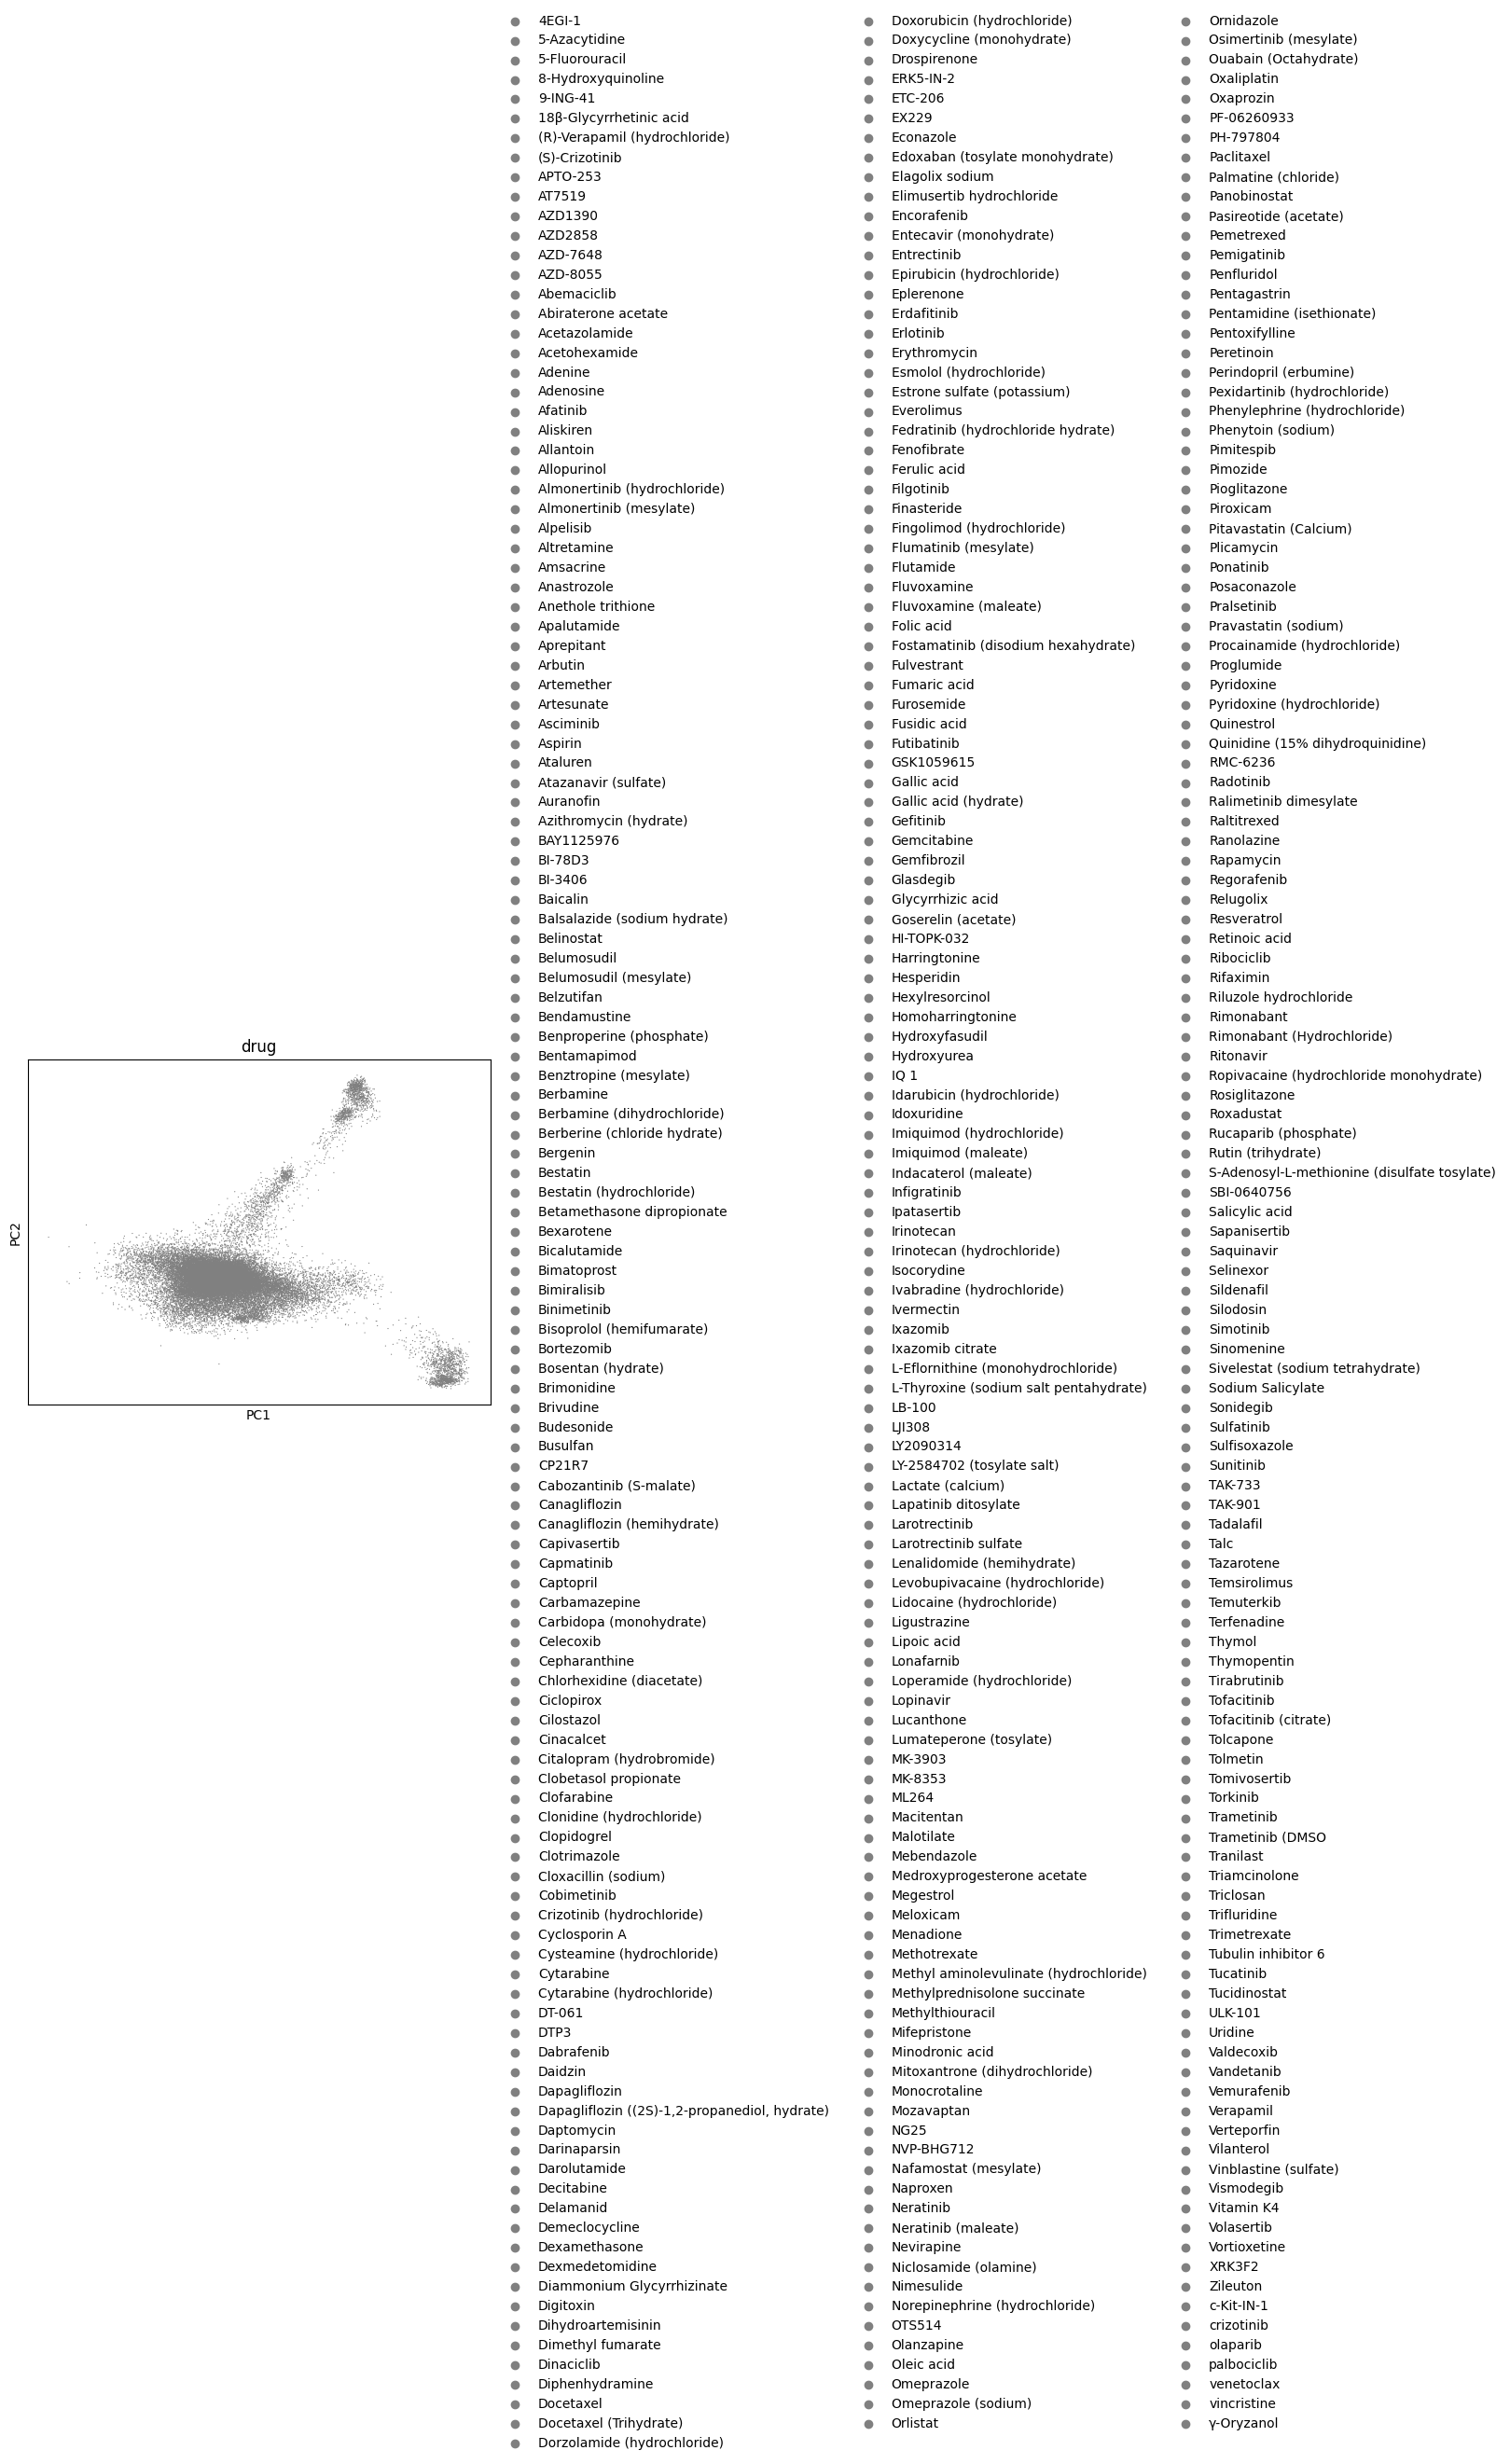

In [28]:
sc.tl.pca(adata)
sc.pl.pca(adata,color='drug')

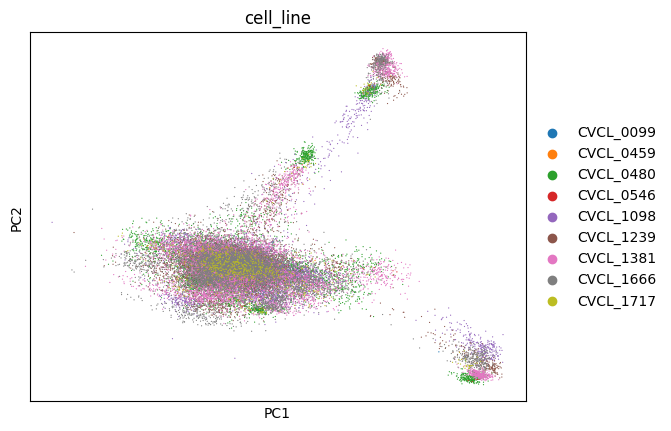

In [29]:
sc.pl.pca(adata,color='cell_line')


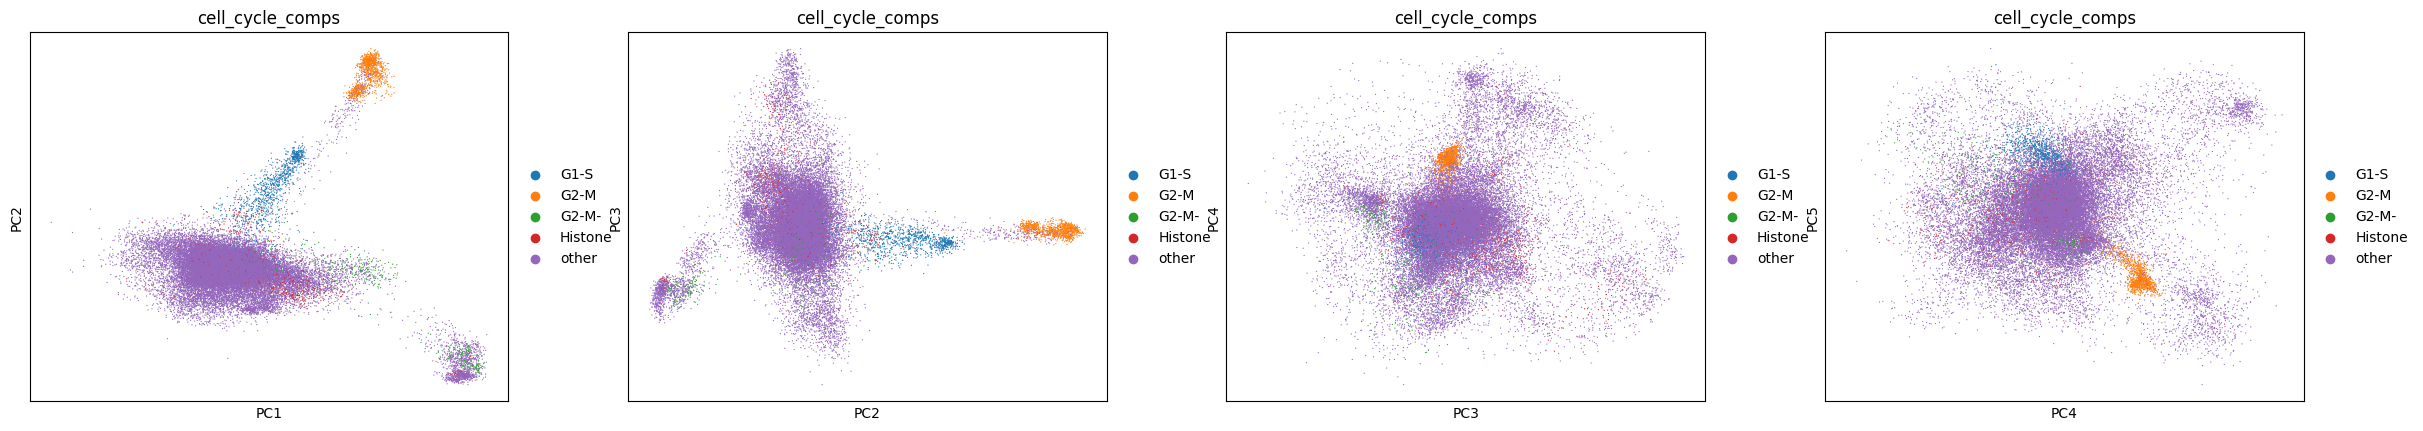

In [34]:
sc.pl.pca(adata,color='cell_cycle_comps',components=['1,2', '2,3','3,4','4,5'])

In [38]:
sc.pp.neighbors(adata,n_neighbors=100)
sc.tl.umap(adata)

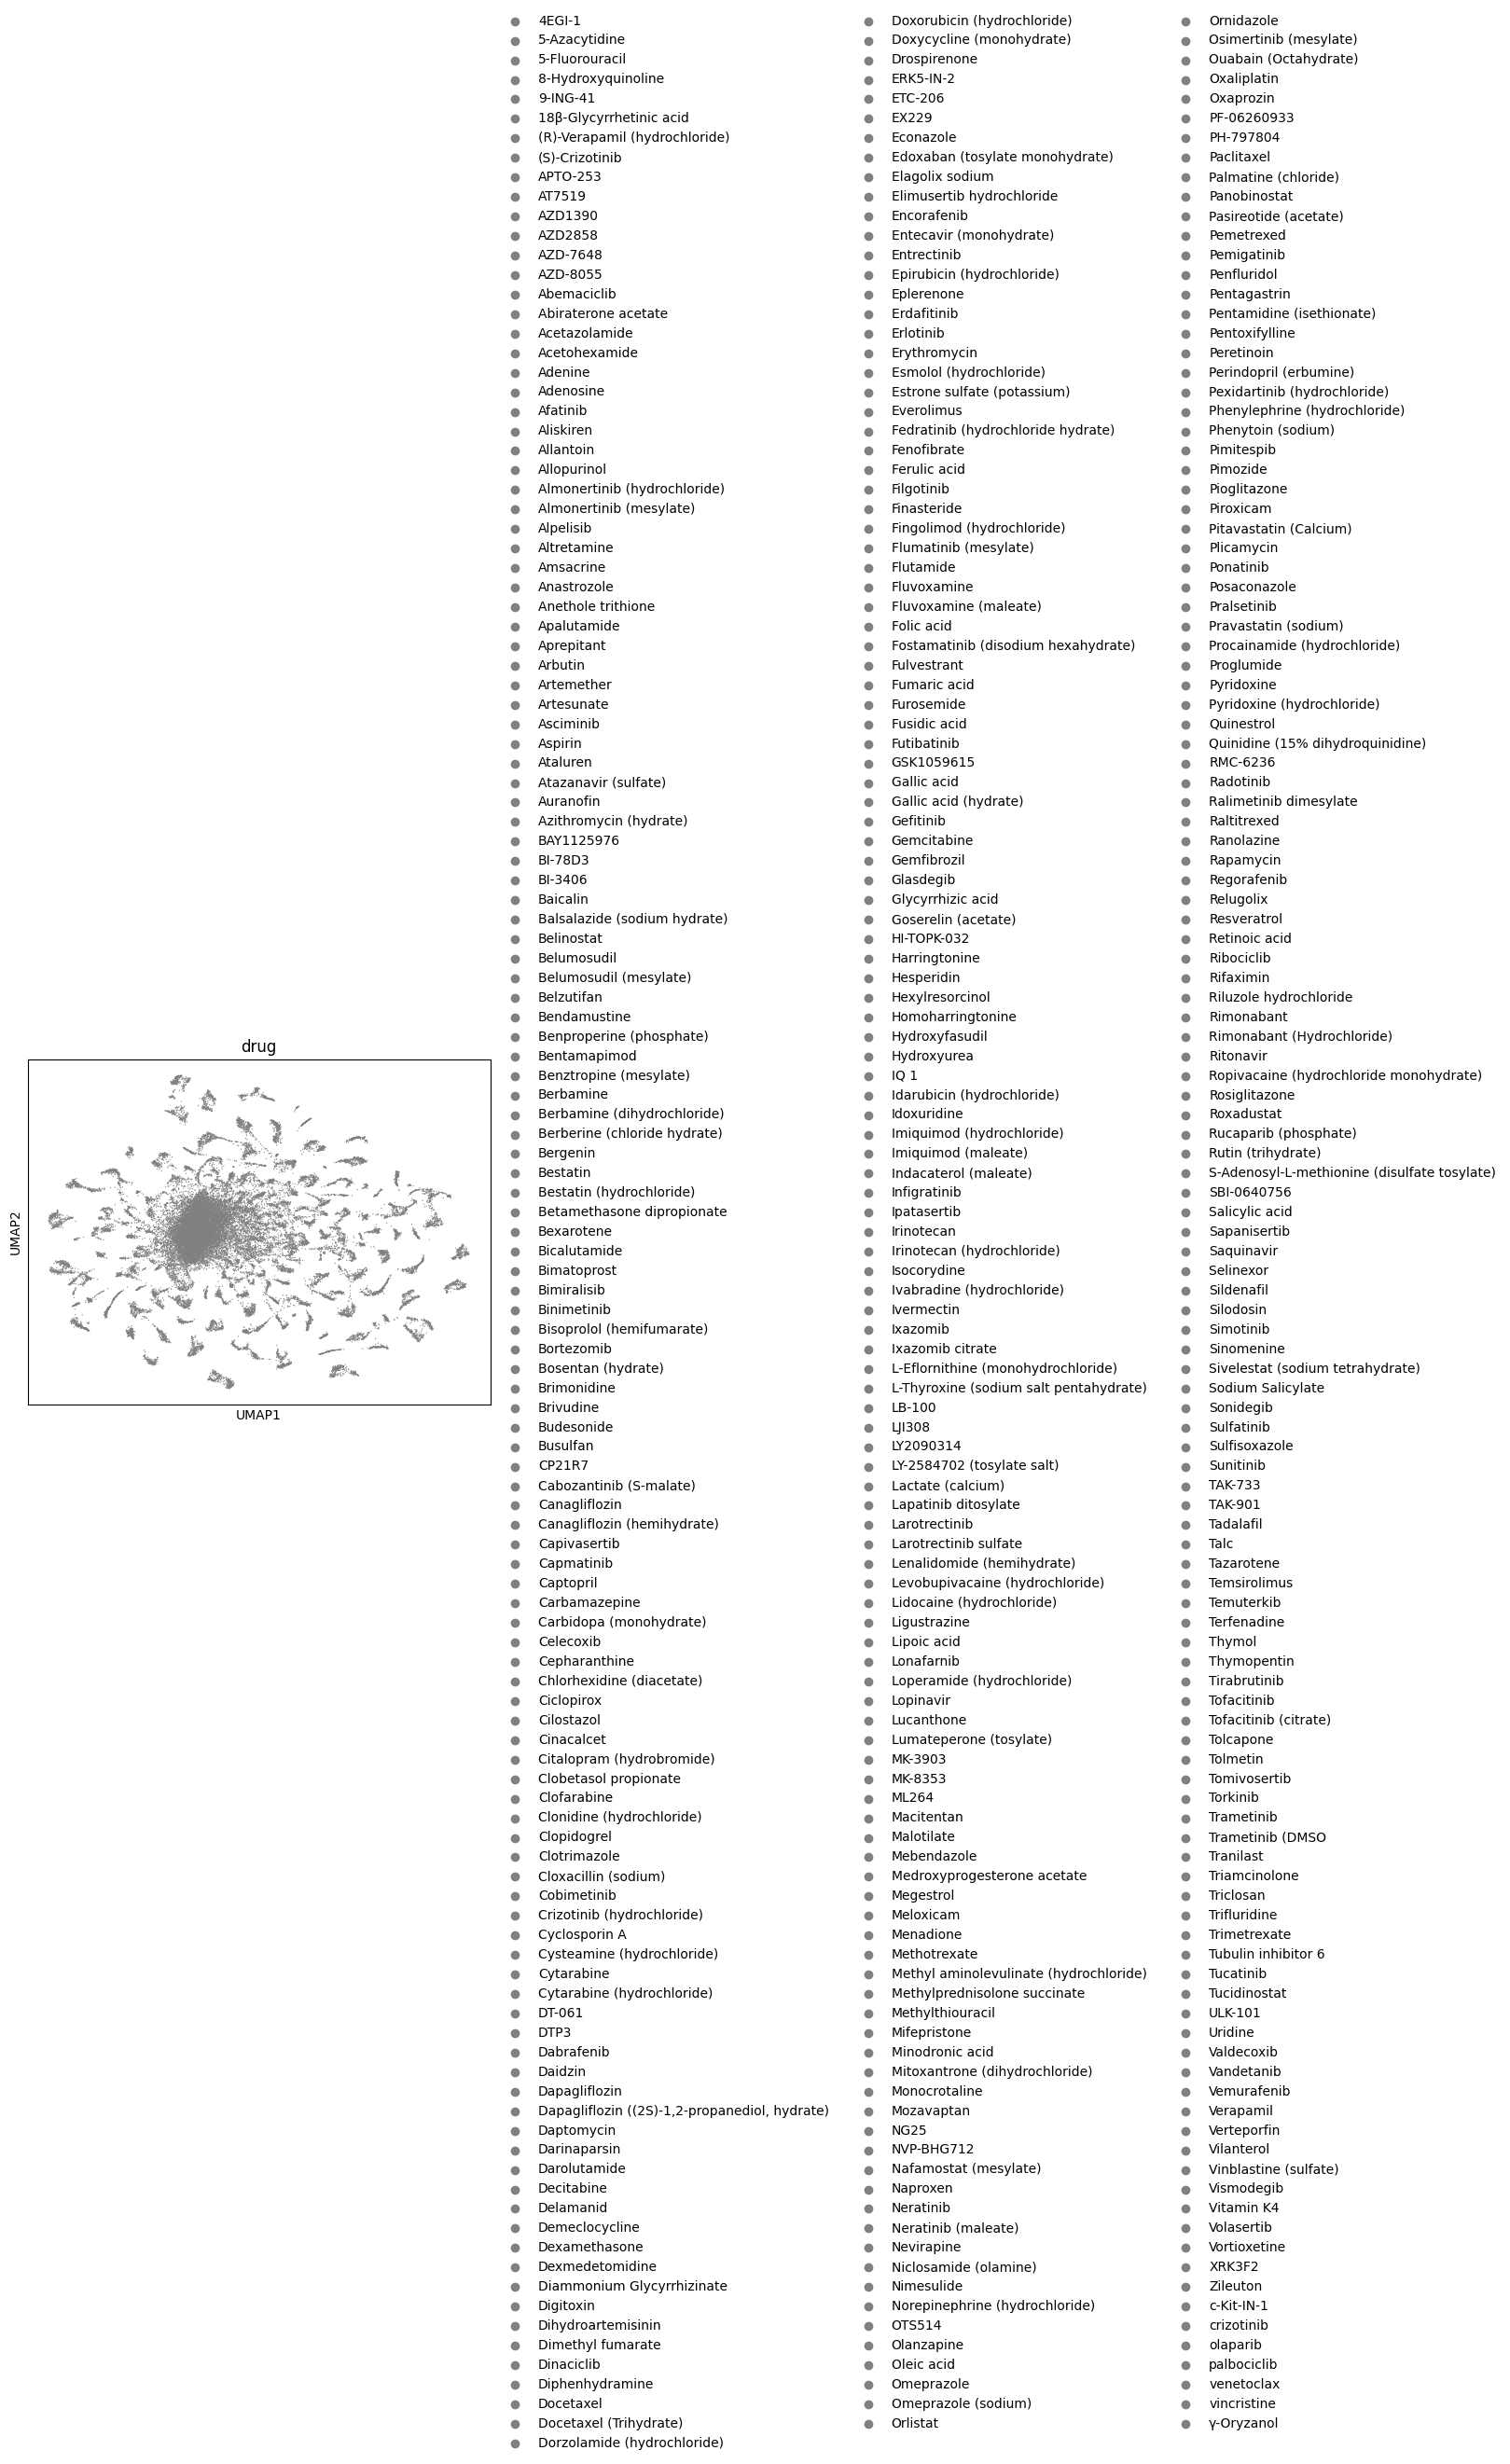

In [35]:
sc.pl.umap(adata,color='drug')

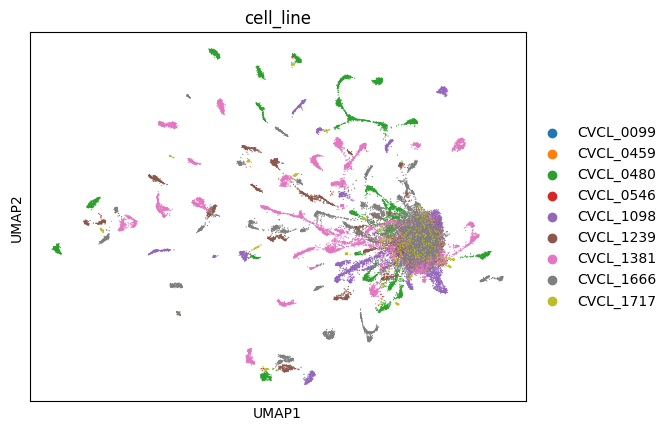

In [39]:
sc.pl.umap(adata,color='cell_line')

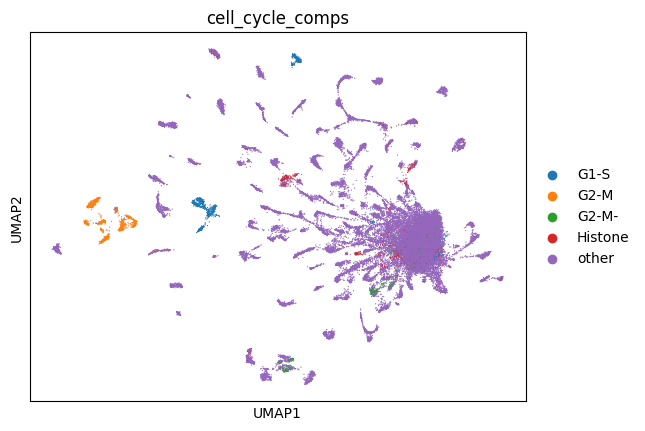

In [40]:
sc.pl.umap(adata,color='cell_cycle_comps')

In [102]:
sc.tl.leiden(adata, resolution=0.3)

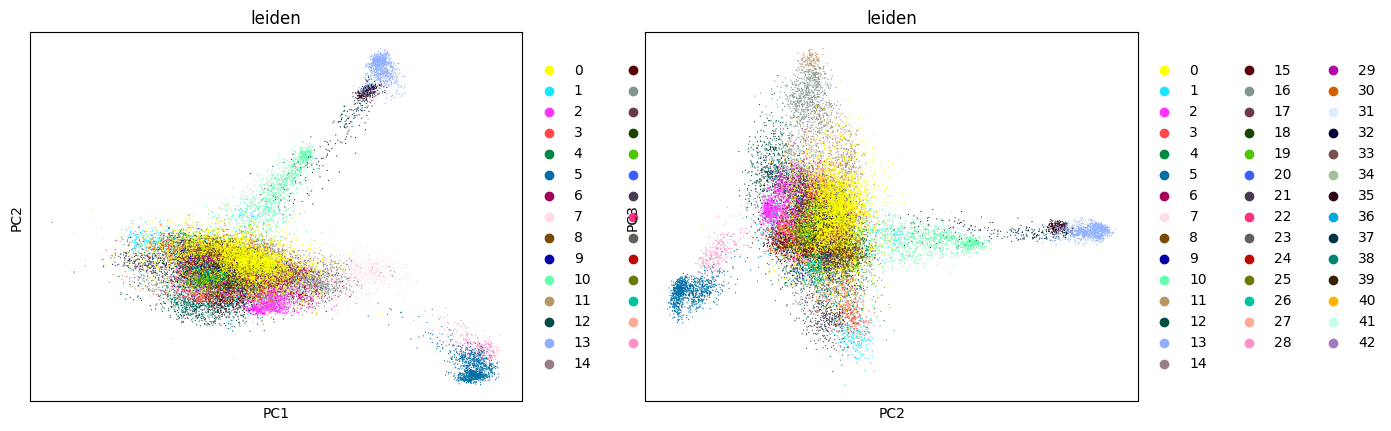

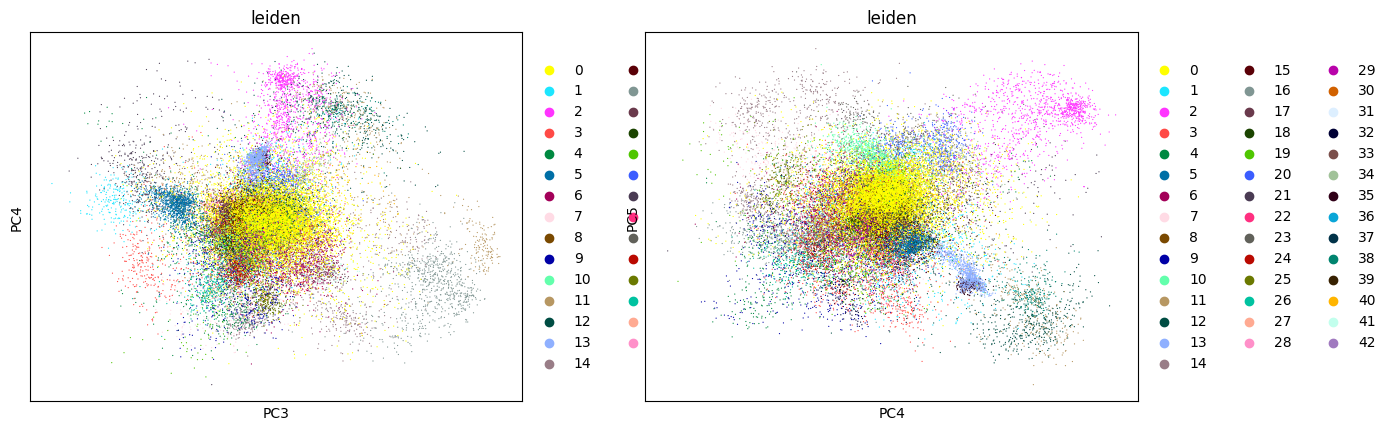

In [103]:
sc.pl.pca(adata,color='leiden',components=['1,2', '2,3'])
sc.pl.pca(adata,color='leiden',components=['3,4','4,5'])

In [104]:
from scipy.spatial.distance import pdist, squareform

X_pca = adata.obsm["X_pca"][:,:20]
clusters = adata.obs["leiden"]

# Compute centroids for each cluster
df_pca = pd.DataFrame(X_pca, index=adata.obs_names)
# Add cluster labels
df_pca["cluster"] = clusters.values
# Compute centroids: mean PCA coordinates per cluster
centroids = df_pca.groupby("cluster").mean()
cluster_order = centroids.index.tolist()
print(cluster_order)
distance_matrix = squareform(pdist(centroids, metric="euclidean"))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42']


/tmp/ipykernel_741/1991089426.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/home/zinovyev/anaconda3/envs/singlecell/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


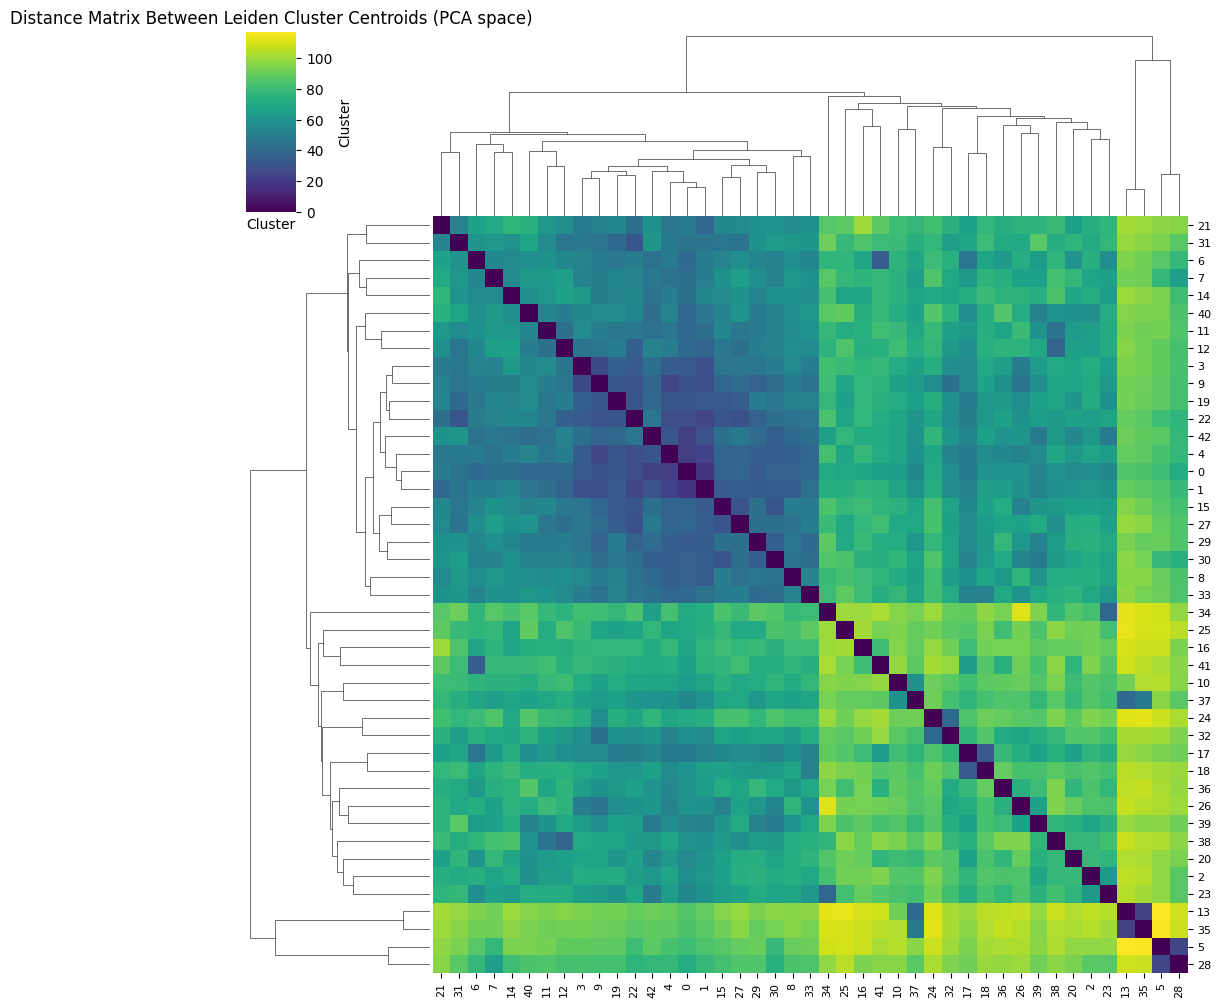

In [105]:
df_dist = pd.DataFrame(data=distance_matrix)
df_dist.index = cluster_order
df_dist.columns = cluster_order
g = sns.clustermap(df_dist, 
            cmap="viridis", annot=False)
plt.title("Distance Matrix Between Leiden Cluster Centroids (PCA space)")
plt.xlabel("Cluster")
plt.ylabel("Cluster")
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Reorder labels accordingly
reordered_row_labels = df_dist.index[row_order]
reordered_col_labels = df_dist.columns[col_order]

# Apply reordered tick labels
g.ax_heatmap.set_yticks(np.arange(len(reordered_row_labels)) + 0.5)
g.ax_heatmap.set_xticks(np.arange(len(reordered_col_labels)) + 0.5)
g.ax_heatmap.set_yticklabels(reordered_row_labels, fontsize=8, rotation=0)
g.ax_heatmap.set_xticklabels(reordered_col_labels, fontsize=8, rotation=90)
plt.show()

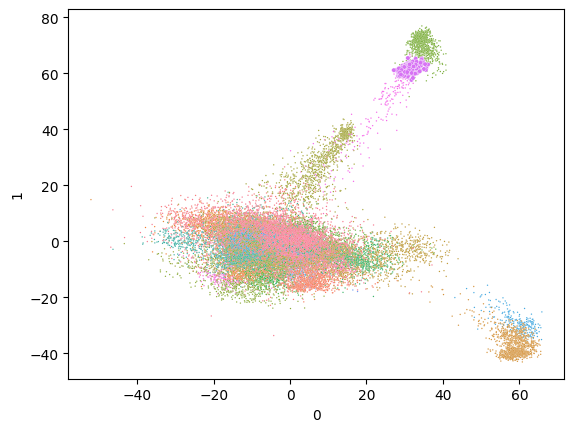

In [121]:
clusters2highlight = ['30','11','38']
clusters2highlight = ['8','46']
clusters2highlight = ['31','20','34']
clusters2highlight = ['5','28']
clusters2highlight = ['13','35']
clusters2highlight = ['24','32']
clusters2highlight = ['28']
clusters2highlight = ['35']
sns.scatterplot(df_pca,x=0,y=1,s=1,hue='cluster',legend=False)
df_temp = df_pca[df_pca['cluster'].isin(clusters2highlight)]
sns.scatterplot(df_temp,x=0,y=1,s=10,hue='cluster',legend=False)
plt.show()
#sns.scatterplot(df_temp,x=0,y=1,s=100,hue='cluster',legend=True)


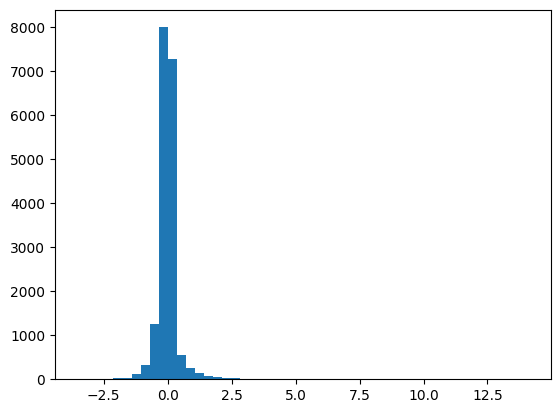

TOP2A
CENPF
MKI67
TPX2
ENSG00000284906
CENPE
ANLN
ASPM
ARL6IP1
KIF4A
SGO2
DIAPH3
CIT
CKAP2
SMC4
HJURP
KIF14
NUSAP1
BUB1
CKAP5
KIF18A
KIF2C
KIF20B
ECT2
KNL1
PRC1
PRR11
KIF18B
GAS2L3
KIF23
ARHGAP11A
DLGAP5
SCLT1
HMGB2
CKAP2L
CDK1
TACC3
AURKA
BUB1B
KIF11
RRM2
CCNB1
RACGAP1
NUF2
DEPDC1
CDCA2
TTK
MIS18BP1
NCAPD2
UBE2C
NDC80
G2E3
NCAPG
KPNA2
GPSM2
IQGAP3
NSD2
GTSE1
LMO7
CDC25C
CEP55
STIL
CDCA8
NAV2
CALM2
SPAG5
NDE1
APOLD1
FAM83D
TUBB4B
NLGN1
HP1BP3
INCENP
NEK2
RAD21
DEPDC1B
NUCKS1
DBF4
HMMR
PARPBP
PTTG1
TUBA1C
KIFC1
CCNA2
NCAPG2
BUB3
STMN1
BIRC5
CIP2A
CEP192
CCNB2
CCDC18
LINC01572
TMPO
KIF15
EYA1
TUBA1B
SHCBP1
KIF20A
CEP152
CENPA
LMNB1
RFX8
DLEU2
MELK
BRD8
POLQ
CCNF
CEP70
CNTRL
CENPI
SOGA1
CEP128
DCAF7
NCAPH
SGO1
WDPCP
PBK
CDC25B
LCORL
CDC27
CCDC88A
H2AZ2
TUBB
SPC25
CDC20
CALM3
WEE1
MPHOSPH9
CKS2
POLH
DEK
FBXO5
USP13
BRIP1
RFWD3


In [123]:
cluster = '13'
meanmg = adata[adata.obs['leiden']==cluster,:].X.mean(axis=0)
plt.hist(meanmg,bins=50)
plt.show()
irx = np.argsort(-meanmg)
for i in irx:
    #print(i,meanmg[i],adata.var_names[i])
    print(adata.var_names[i])
    if meanmg[i]<3.0:
        break

In [126]:
meanmg_s = {}
for cl in tqdm(cluster_order):
    meanmg = adata[adata.obs['leiden']==cl,:].X.mean(axis=0)
    meanmg_s['CL_'+cl] = meanmg
df_s = pd.DataFrame(data=meanmg_s)
display(df_s)

100%|██████████| 43/43 [00:36<00:00,  1.18it/s]


CL_0      CL_1      CL_2      CL_3      CL_4      CL_5      CL_6  \
0      0.030934  3.658297  0.148082  2.612089 -0.057804 -0.031133  0.126299   
1      0.083613  1.870005  1.240156  0.323518  0.246612 -1.087091 -1.533390   
2      0.046341 -0.049505 -0.386128  0.077584 -0.146630 -0.141982  0.136765   
3      0.179095  0.368774 -0.227182  2.882243  0.373616 -0.900460  0.498081   
4     -0.001273  0.217641  0.242794  0.119062 -0.178065  5.736787 -0.596777   
...         ...       ...       ...       ...       ...       ...       ...   
18288 -0.000041  0.000015 -0.000049  0.000000 -0.000070  0.000061  0.000026   
18289 -0.000050 -0.000010 -0.000063  0.000000 -0.000085  0.000078  0.000008   
18290  0.000019 -0.000051 -0.000149  0.000000  0.000036  0.000174 -0.000320   
18291  0.000026  0.000013  0.000065  0.000000 -0.000568  0.000207 -0.000171   
18292  0.000078  0.000032  0.000394  0.000000  0.000117 -0.000279  0.000901   

           CL_7      CL_8      CL_9  ...     CL_33     CL_34     CL_35  \
0     -0.086554  1.359250 -0.902122  ...  0.372109 -0.918272 -1.341526   
1     -1.370678 -0.217366  0.634802  ...  0.202982  1.645424  0.020599   
2     -0.175656  0.453337  0.557498  ...  0.125580 -0.146942 -0.033167   
3     -0.359418  2.014592  0.257723  ...  0.042156 -0.428344  1.368731   
4      1.237979  0.265964 -0.337547  ...  2.854690 -1.538719  3.125564   
...         ...       ...       ...  ...       ...       ...       ...   
18288 -0.000356  0.000108  0.000093  ...  0.000000  0.000000  0.000000   
18289 -0.000371  0.000087  0.000078  ...  0.000000  0.000000  0.000000   
18290 -0.000039  0.000143  0.000113  ...  0.000000  0.000000  0.000000   
18291 -0.000202  0.000399  0.000191  ...  0.000000  0.000000  0.000000   
18292  0.000731 -0.000362  0.000487  ...  0.000000  0.000000  0.000000   

          CL_36     CL_37     CL_38     CL_39     CL_40     CL_41     CL_42  
0      1.196704 -1.796876  3.672958  2.736130  1.504990 -0.249945 -1.158898  
1     -0.257775 -0.404400  4.913418  0.584319 -0.926243 -4.687733  0.331085  
2      0.083068  0.015062 -0.058947 -0.170178 -0.134244  0.840443 -1.006172  
3     -0.640810  2.745556 -0.562365 -2.635763  0.367355  2.097343 -2.167892  
4      0.580139  1.839586 -1.224149  2.125568  0.095543  0.064293 -2.346898  
...         ...       ...       ...       ...       ...       ...       ...  
18288  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
18289  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
18290  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
18291  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
18292  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[18293 rows x 43 columns]

In [ ]:
df_s.index = adata.var_names
df_s.to_csv('data/ICAclusters_mean_S.xls',sep='\t',index=False)

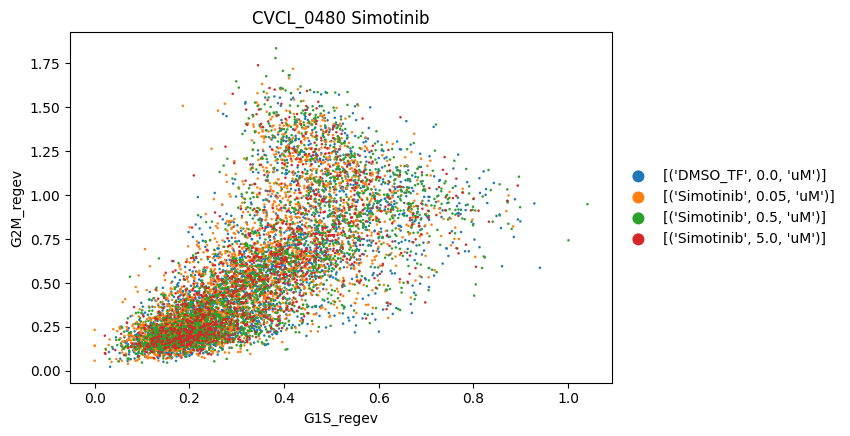

In [86]:
sc.pl.scatter(ica,x='G1S_regev',y='G2M_regev',color='drugname_drugconc',title=cl+' '+dr)

In [59]:
S = ica.uns['Metagenes']
A = ica.X
icat = an.AnnData(X=np.zeros([ica.n_obs,S.shape[0]]))
icat.var_names = ica.uns['gene_names']
icat.uns['dimRed'] = DimRedObject(ica.uns['Metagenes'].T)
icat.obsm["X_dimRed"] = ica.X
icat.uns['scycle'] = {}
icat.uns['scycle']['find_cc_components'] = {}
scycle.tl.find_cc_components(icat,thr=0.5)
cc_indices = icat.uns['scycle']['find_cc_components']['indices'].copy()


--- Selected components:
G1-S: 0 (score=5.366580)
G2-M: 1 (score=6.479641)
Histones: 23 (score=2.748755)
